# Fist thing's first

#turn On the table of content, it should apear on the left

#I have totally missed the gene that should presumably help a person with spelling (including Farsi), and the notebook is not spell checked. Please let it not bother you too much :D

#if you want to read the scenario: make sure you have the file in the same directory as the notebook

#<span class="mark">please give a name for the scenario you want to make or read</span> (use the same name for all stages of one scenario)

In [3]:
scenario_name='scenario_101_test'
fleet_size=150
DrivingRange=120 # km
charging_time=[6,1] # hours from 0% to 80% SoC, [slow, fast]

<span class="mark">#choose what you want to do:</span>
#stage= 1 for generating requests to run with no relocation or charging
#stage= 2 for generating requests to run with relocation
#stage= 3 for gnerating requets to run with charging
#stage= 4 to look at final results of scenario with charging

In [4]:
stage=3

#<span class="mark">choose prameters for generating request</span> 

In [5]:
number_nodes_per_zone=50  #number of nodes to generate per zone to use and origin and destination of requests
es_total_demand=8500     #Expected number of requests (before applying noize and bias to them)
wn_time_step, bi_morning, bi_evening=0.1,0.0,0.0  #in order white_noise_factor, morning_bias, and evening_bias
operation_start_time, operation_end_time=6, 23


#<span class="mark">number_of_chargers</span> only required for stage 3

In [6]:
number_of_slow_plugs=30
number_of_slow_stations=6
number_of_fast_plugs=4
number_of_fast_stations=2


#To change the display width of cells in notebook use below

In [7]:
size=85 #percentage relative to width of your browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:"+str(size)+"% !important; }</style>"))

## Imports

In [8]:
from __future__ import (absolute_import, division, print_function)


from geopandas import GeoSeries, GeoDataFrame,read_file, sjoin
from shapely import wkt
from shapely.geometry import box, Point, Polygon, MultiPolygon, MultiPoint, GeometryCollection,LineString,MultiLineString
from shapely.ops import cascaded_union,polygonize, polygonize_full, split,linemerge, unary_union
from scipy.spatial import Voronoi, voronoi_plot_2d
from geopy.distance import great_circle


from functools import partial
import json
from requests import post
import numpy as np
import pandas as pd
import glob
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline


from pandas.io.json import json_normalize
from copy import deepcopy
from  ast import literal_eval
from datetime import datetime, timedelta
from math import radians, log, tan, pi, atan, exp                                                                                                                                
from random import uniform, randint, sample


import gurobipy
from scipy.sparse import csr_matrix, hstack, vstack, coo_matrix, save_npz, load_npz
from scipy.stats import truncnorm
from sklearn.cluster import DBSCAN, KMeans


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<span class="burk">#If you change the stage or scenario name please run the cell below again.</span>

In [9]:
path_dic={'from_simulator':'data/vehicle_logs/',
          'scenario': scenario_name+'/',
          'auxilary':'auxilary/'}
path_dic['results']=path_dic['scenario']+'results/'+str(min(stage,3))+'/'
list_path=[path_dic['scenario']]
for i in range(1,4):
    list_path+=[path_dic['scenario']+'results/'+str(i)+'/',path_dic['scenario']+'results/'+str(i)+'/'+'toure and trajectory/']
for newpath in list_path:
        if not os.path.exists(newpath):
            os.makedirs(newpath)

## some functions that you will need

#please run all cells in the section

#consumption function

In [18]:
def link_consumption (distance, driving_range=DrivingRange):
    consumption=100*(distance/(driving_range*1000))
    return consumption

#xroute function

In [19]:
class XServer:
    """class defines Requests for 1:1 routing and Isochrone routing
    """ 
    
    def make_isochrone_request(self, profile, point, horizon_unit, horizon_bands, direction='INBOUND', fast_option=0): 
        
        assert direction in ["INBOUND","OUTBOUND"], 'wrong direction format'
        
        
        request = {"location": {},
                  "reachableAreasOptions": {
                    "horizons": [],
                      "calculationMode": ["QUALITY","PERFORMANCE"][fast_option],
                      "drivingDirection": direction,
                },                  
                "storedProfile": "{}".format(profile),                                   
                "userLogs": [],
                   "coordinateFormat": "EPSG:76131"
                }            
        if horizon_unit=='TravelTime':
            request["reachableAreasOptions"]["horizons"] += [
                                                        {"$type": "TravelTimeBasedHorizon", "travelTime": t} for t in horizon_bands
                                                    ]
        if horizon_unit=='Distance':
            request["reachableAreasOptions"]["horizons"] +=  [
                                                        {"$type": "DistanceBasedHorizon", "distance": t} for t in horizon_bands
                                                    ]            
        request["location"] = {"$type": "OnRoadRouteLocation", "coordinate": {"y": point[1], "x": point[0]}}
        
        # add id, coverage of routes to xs logfile
#         iso_request["userLogs"] += {"Isochrone Request"}

        return request   
    
    def make_route_request(self, profile, waypoints):

        request = {"waypoints": [],
                    "routeOptions": {
                        "polylineOptions": {
                          "elevations": False #True
                        }
                      },  
                   "resultFields": {
                       "polyline": False,
                      "report": True,
                       "segments": {
                           "enabled": False,
#                            "descriptors": True,
#                          "polyline": False,
#                            "roadAttributes": True
                                   },
                       "waypoints": True
                                    },
                        "routeOptions": {
                                "routingType": "CONVENTIONAL",#"HIGH_PERFORMANCE_ROUTING",
                            
                        "geographicRestrictions": {
                              "allowedCountries": [
                                "ES"
                              ]
                            },

                                },
                   "storedProfile": "{}".format(profile),   
                     "scope": "barcelona",
                   "userLogs": [],
                   "coordinateFormat": "EPSG:76131"
                   }
        
        request["waypoints"]  =[
            {"$type": "OnRoadWaypoint", "location": {"coordinate": {"y": stop[1], "x": stop[0]}}} for stop in list(waypoints)]
        
#         request["userLogs"] += {"1-1 Routing Request"}
        
        return request   

    def send_route_request(self, request):
        
        
        # returns a string representing a json object
        json_data = json.dumps(request)
        # print the JSON request to the console
        # this request can directly be used in the RawRequestRunner (RRR) by Cut&Paste
        # ATTENTION: When using the request in the RRR be sure to select the right API-endpoint "xroute, JSON, experimental, calculateRoute"
#         print(json_data)
        # send the request to the xServer using the correct Url Endpoint
        UrlCalculateRoute = "http://localhost:50000" + "/services/rs/XRoute/experimental/calculateRoute"
        header = {"content-type": "application/json;charset=utf-8"}
        json_resp = post(url=UrlCalculateRoute, data=json_data, headers=header)
#         print(json.loads(json_resp.text))

        if json_resp.status_code == 200:
            response = json_resp.text
            pyres = json.loads(response)

        else:
            print('xs2 Request failed 1')
            print(json.loads(json_resp.text))
            return -99,-99,-99

        # set geometry to zero
        distance = 0
#         print(distance)
        if "$type" in pyres:

            # read out the data of xs-response

#             polyline = pyres.get("polyline")            
            distance = pyres.get("distance")
            travel_time = pyres.get("travelTime")
            report = pyres.get("report")
#             segment_list = pyres.get("segments")
#             segment_count = len(segment_list)
            way_points = pyres.get("waypoints")

        else:
            "Couldn't read data from xs"
               
#         segment_df=json_normalize(segment_list)
        
#         segment_df['elevation_gain']=segment_df['polyline.plain.polyline'].apply(lambda x: (x[-1]['z']-x[-0]['z']))
#         segment_df['grade']=segment_df['elevation_gain']/segment_df['distance']
#         columns_used_for_segment= ['attributes.descriptors.networkClass', 
#                                    'distance',
#                                    'travelSpeed',
#                                    'travelTime', 
#                                    'type',
#                                    'grade',
#                                   'elevation_gain']
        
# #         ['distance','travelTime','travelSpeed','type','networkClass','elevation']
#         print(segment_df.columns.tolist())
#         segment_df=segment_df[columns_used_for_segment]
        
        
#         segment_1=segment_list[0]
#         segment_polyline = segment_1.get("polyline", None)
#         print(segment_polyline)

        return distance, travel_time, way_points#, report
                                
        # ----------------------------- Isochrone Request ----------------------------------
    def send_isochrone_request(self, request):
        
        # returns a string representing a json object
        json_data = json.dumps(request)                
#         print(json_data)
        UrlCalculateReachableArea = "http://localhost:50000" + "/services/rs/XRoute/experimental/calculateReachableAreas"
        header = {"content-type": "application/json;charset=utf-8"}
        json_resp = post(url=UrlCalculateReachableArea, data=json_data, headers=header)
        if json_resp.status_code == 200:
            response = json_resp.text
            pyres = json.loads(response)

        else:
            print('xs2 Request failed 2')
            print(json_resp.text)
            return -99
        
        reachableAreas = pyres.get("reachableAreas")
#         polygon=reachableAreas.get('polygon')
#         reachableAreas_df=json_normalize(reachableAreas)
        
#         columns_used_for_reachableAreas=['polygon']
        
#         reachableAreas_df=reachableAreas_df[columns_used_for_reachableAreas]
        
        
        return reachableAreas#polygon
    
    
    
    
    
    def make_cost_matrix_request(self, profile, strat_locations,destination_locations,timeout=3600):
        timeout=timeout*1000
        request={
          "$type": "CreateAndGetDistanceMatrixRequest",
          "resultFields": {
            "distances": True,
            "travelTimes": True,
            "violated": False,
            "estimatedByDirectDistance": False
          },
          "startLocations": [],
            "destinationLocations": [],
        "coordinateFormat": "EPSG:76131",
        "timeouts":{"computationTimeout": timeout}
            
          }
        
        request["startLocations"]  =[
            {"$type": "OnRoadRouteLocation", "coordinate": {"y": stop[1], "x": stop[0]}} for stop in list(strat_locations)]
        
        request["destinationLocations"]  =[
            {"$type": "OnRoadRouteLocation", "coordinate": {"y": stop[1], "x": stop[0]}} for stop in list(destination_locations)]
        
        return request   

    def send_cost_matrix_request(self, request):
        
        number_of_starts=len(request["startLocations"])
        number_of_destination=len(request["destinationLocations"])
        json_data = json.dumps(request)

        UrlCalculateRoute = "http://localhost:50000" + "/services/rs/XDima/experimental/createDistanceMatrix"
        header = {"content-type": "application/json;charset=utf-8"}
        json_resp = post(url=UrlCalculateRoute, data=json_data, headers=header)
#         print(json.loads(json_resp.text))

        if json_resp.status_code == 200:
            response = json_resp.text
            pyres = json.loads(response)

        else:
            print('xs2 Request failed 1')
            print(json.loads(json_resp.text))
            return -99,-99

        distance = 0
        if "$type" in pyres:           
            distance_list = pyres.get("contents").get("distances")
            travel_time_list = pyres.get("contents").get("travelTimes")

#         list2mat=lambda x:np.reshape(np.array(x),[number_of_starts,number_of_destination])
#         distance_mat=list2mat(distance_list)
#         travel_time_mat=list2mat(travel_time_list)
        distance_mat=np.array(distance_list)
        travel_time_mat=np.array(travel_time_list)

        return distance_mat, travel_time_mat

#rest

In [20]:
def get_df_EVehicleTours_day_agg(df_EVehicleTours_day):
    def get_active_tours(NextStopIndex,x):
        dic_tours=literal_eval(x)
        dic_tours_active=[k for k in dic_tours if k['DropoffIndex']>=NextStopIndex]
        return dic_tours_active

    def get_trip_ids(x):
        list_TripId=[k['TripId'] for k in x if k['TripId']<10000]
        return list_TripId
    def get_tours_with_pickup_in_step(timestep,x):
        dic_tours=literal_eval(x)
        dic_tours_active=[k for k in dic_tours if ((k['LatestPickupTime']['Seconds']>(timestep-1)*1800)+(k['LatestPickupTime']['Seconds']<=(timestep)*1800)==2)]
        return dic_tours_active
    def get_trip_ids_per_time_step(x):
        total = []
        for i in x:
            total += i
        total=list(set(total))
        return total

    df_EVehicleTours_day['timestep']=df_EVehicleTours_day['time'].apply(lambda x:int(x/1800)+1)
    df_EVehicleTours_day['Trips_dic_active']=df_EVehicleTours_day[['Tour.NextStopIndex','Tour.Trips']].apply(lambda row:get_active_tours(row['Tour.NextStopIndex'],row['Tour.Trips']),axis=1)  
    df_EVehicleTours_day['num_trip_active']=df_EVehicleTours_day['Trips_dic_active'].apply(lambda x:len(x))
    df_EVehicleTours_day['TripIds_active']=df_EVehicleTours_day['Trips_dic_active'].apply(lambda x:get_trip_ids(x)) 
    df_EVehicleTours_day['Trips_dic_with_pickup_in_step']=df_EVehicleTours_day[['timestep','Tour.Trips']].apply(lambda row:get_tours_with_pickup_in_step(row['timestep'],row['Tour.Trips']),axis=1)  
    df_EVehicleTours_day['TripIds_with_pickup_in_step']=df_EVehicleTours_day['Trips_dic_with_pickup_in_step'].apply(lambda x:get_trip_ids(x))  


    df_EVehicleTours_day_agg=df_EVehicleTours_day[['VehicleId', 'timestep', 'TripIds_active','TripIds_with_pickup_in_step']].groupby(['VehicleId',
                                                                                                 'timestep'])['TripIds_active'].apply(list).reset_index()
    df_EVehicleTours_day_agg_=df_EVehicleTours_day[['VehicleId', 'timestep', 'TripIds_active','TripIds_with_pickup_in_step']].groupby(['VehicleId',
                                                                                                 'timestep'])['TripIds_with_pickup_in_step'].apply(list).reset_index()

    df_EVehicleTours_day_agg['TripIds_with_pickup_in_step']=df_EVehicleTours_day_agg_['TripIds_with_pickup_in_step']
    df_EVehicleTours_day_agg['TripIds_active']=df_EVehicleTours_day_agg['TripIds_active'].apply(lambda x:get_trip_ids_per_time_step(x))
    df_EVehicleTours_day_agg['num_trips_in_30_min']=df_EVehicleTours_day_agg['TripIds_active'].apply(lambda x:len(x))
    df_EVehicleTours_day_agg['TripIds_with_pickup_in_step']=df_EVehicleTours_day_agg['TripIds_with_pickup_in_step'].apply(lambda x:get_trip_ids_per_time_step(x))
    df_EVehicleTours_day_agg['num_pickups_in_30_min']=df_EVehicleTours_day_agg['TripIds_with_pickup_in_step'].apply(lambda x:len(x))
    return df_EVehicleTours_day_agg

In [21]:
def read_daily_trejectories(path):
    def add_vehid( df,vehid):
        df.insert(0, 'VehicleId', vehid, allow_duplicates=False)
        return df
    headers = ['Datetime', 'Lon', 'Lat']
    dtypes = {'Datetime': 'str', 'Lon': 'str', 'Lat': 'str'}
    parse_dates = ['Datetime']
    df_EVehicleTrejectory_day = pd.concat([add_vehid(pd.read_csv(f,sep=',',header=None,skiprows=1, names=headers, dtype=dtypes, parse_dates=parse_dates) , int(os.path.basename(f)[7:-4])) for f in glob.glob(path+'vehicle*.csv')], ignore_index = True)   
    df_EVehicleTrejectory_day['waypoints']=df_EVehicleTrejectory_day.apply(lambda row: [row['Lon'],row['Lat']], axis=1)
    if df_EVehicleTrejectory_day['Datetime'][0].tz!= None:
        df_EVehicleTrejectory_day['Datetime']=df_EVehicleTrejectory_day['Datetime'].dt.tz_convert(None)
    min_time=datetime(1970, 1, 1, 0, 0, 0)
    df_EVehicleTrejectory_day['time_step']=df_EVehicleTrejectory_day['Datetime'].apply(lambda t: int((t-min_time).total_seconds()/(60*30))+1)
    df_EVehicleTrejectory_day_agg=df_EVehicleTrejectory_day.groupby(['VehicleId','time_step'])['waypoints'].apply(list).reset_index()
    x_server = XServer()
    def get_cunsumption_TT(waypoints, x_server, link_consumption):
        if len(waypoints)<=1:
            return [0, 0, 0]
        profile="car"
        route_request=x_server.make_route_request( profile, waypoints)
        distance, travel_time, _=x_server.send_route_request(route_request)
        cunsumption=link_consumption(distance)
        return [cunsumption, travel_time, distance]
    df_EVehicleTrejectory_day_agg['consumption_TT_dist']=df_EVehicleTrejectory_day_agg.apply(lambda row:
                                                get_cunsumption_TT(row['waypoints'],x_server,link_consumption), axis=1)
    df_EVehicleTrejectory_day_agg['consumption']=df_EVehicleTrejectory_day_agg['consumption_TT_dist'].apply(lambda x:x[0])
    df_EVehicleTrejectory_day_agg['travel_time']=df_EVehicleTrejectory_day_agg['consumption_TT_dist'].apply(lambda x:x[1])
    df_EVehicleTrejectory_day_agg['distance']=df_EVehicleTrejectory_day_agg['consumption_TT_dist'].apply(lambda x:x[2])
    fleet_size=len(glob.glob(path+'vehicle*.csv'))
    num_of_time_steps=df_EVehicleTrejectory_day['time_step'].max()
    df_merge_left=pd.DataFrame({'VehicleId':np.repeat(np.arange(fleet_size),num_of_time_steps),'time_step':np.tile(np.arange(num_of_time_steps),fleet_size)})
    df_EVehicleTrejectory_day_agg_=pd.merge(df_merge_left,df_EVehicleTrejectory_day_agg,how='left', on=['VehicleId','time_step']) 
    df_EVehicleTrejectory_day_agg_.fillna(0,inplace=True)
    df_EVehicleTrejectory_day_agg=df_EVehicleTrejectory_day_agg_
    return df_EVehicleTrejectory_day_agg, fleet_size

# Generate scenario: stage [1, 2, 3]

## read zone shapefile and OD matrix

In [600]:
data_pth = "data\BCN_Zones"
zones = read_file(os.path.join(data_pth, "BCN_Zones_zone.SHP"))

path="data\OD"
OD=pd.read_csv(path+'\BarcelonaDemand_TUD.csv', delimiter=';' ,header=0)
OD=OD[(OD.munori=='Barcelona') & (OD.mundes=='Barcelona')]
OD=OD.drop(['mundisori','mundisdes','munos','munds'],1)
OD=OD.rename(index=str, columns={"hp8": "h8", "hp18": "h18"})

Text(0, 0.5, 'Number of trips')

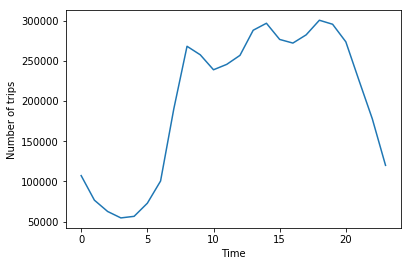

In [601]:
OD_=pd.pivot_table(OD, values=['h'+str(i) for i in range(24)], index=None, columns=['id','ori','des','od','ms_car','ms_bus','ms_met','ms_other'])
OD_=OD_.reset_index()
# OD_.head()
OD_=OD_.rename(index=str, columns={"level_0": "time", 0: "trips"})
OD_["time"]=OD_["time"].apply(lambda x:int(x[1:]))

OD_agg_over_origin=OD_.groupby(['ori']).sum()['trips']
OD_agg_over_origin=OD_agg_over_origin.reset_index()

OD_agg_over_destination=OD_.groupby(['des']).sum()['trips']
OD_agg_over_destination=OD_agg_over_destination.reset_index()

zones_=zones[(zones['NO']>300) & (zones['NO']<663) ]
zones_=pd.merge(zones_,OD_agg_over_origin,how='left',left_on='NO',right_on='ori')
zones_=pd.merge(zones_,OD_agg_over_destination,how='left',left_on='NO',right_on='des',suffixes=('_ori','_des'))
OD_agg_over_time=OD_.groupby(['time']).sum()['trips']
OD_agg_over_time=OD_agg_over_time.reset_index()
plt.plot(OD_agg_over_time['trips'])

OD_agg_over_time['morning']=0
OD_agg_over_time['evening']=0
OD_agg_over_time.loc[(OD_agg_over_time['time']>=6) &
                (OD_agg_over_time['time']<=11),'morning']=1
OD_agg_over_time.loc[(OD_agg_over_time['time']>=12) &
                (OD_agg_over_time['time']<=20),'evening']=1
plt.xlabel('Time')
plt.ylabel('Number of trips')

### cluster the zones

#there are 300+ zones in barcelona, choose how many zones to cluster them into.
#this will set resolution of the zones, later you can choose how many of them to use.
#k means clustring method is used

In [602]:
how_many_zones=30

Number of clusters: 30


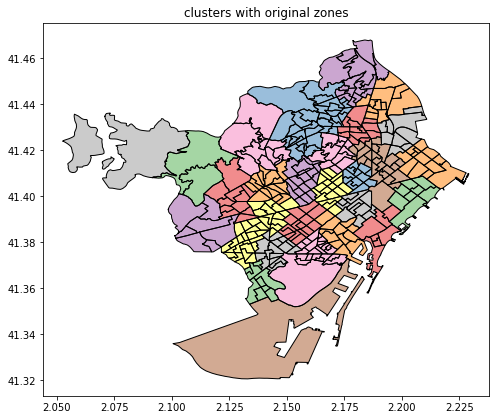

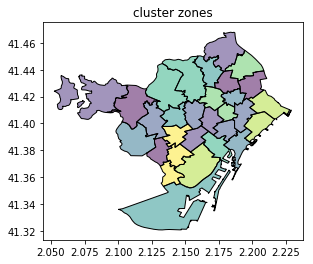

Statistics of the clusters: histogram of number of trips per day, area, and number of original zones that they contain


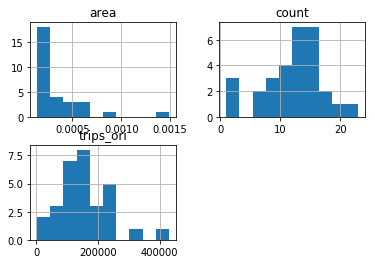

In [603]:
cluster_zones=deepcopy(zones_)
cluster_zones['lon'] = cluster_zones.geometry.apply(lambda p: p.centroid.x)
cluster_zones['lat'] = cluster_zones.geometry.apply(lambda p: p.centroid.y)
coords = cluster_zones.as_matrix(columns=['lat', 'lon'])

kms_per_radian = 6371.0088*4
epsilon = 1.5 / kms_per_radian
# db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
db = KMeans(n_clusters=how_many_zones).fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))
cluster_zones['cluster_labels']=cluster_labels

cluster_zones.plot(column='cluster_labels',cmap='Set1', figsize=(8, 8))
plt.title('clusters with original zones')
plt.show()

cluster_zones_agg=deepcopy(cluster_zones)
cluster_zones_agg=cluster_zones_agg[['geometry','trips_ori','cluster_labels']]
cluster_zones_agg['area']=cluster_zones_agg.geometry.area
cluster_zones_agg['count']=1
cluster_zones_agg=cluster_zones_agg.dissolve(by='cluster_labels', aggfunc='sum')
cluster_zones_agg.plot()
plt.title('cluster zones')
plt.show()

print('Statistics of the clusters: histogram of number of trips per day, area, and number of original zones that they contain')
cluster_zones_agg[['trips_ori','area','count']].hist()
plt.show()

cluster_zones_agg=cluster_zones_agg.reset_index()

### read data for privious stage: stage[2,3]

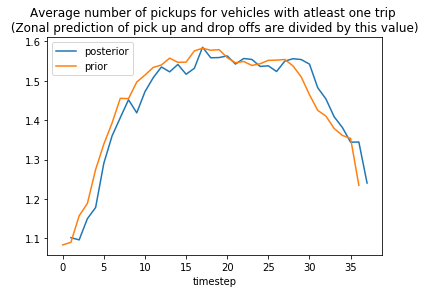

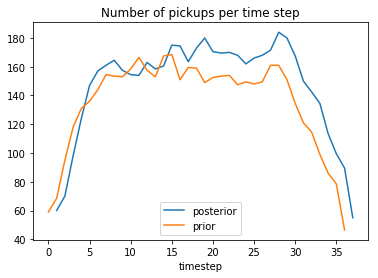

In [637]:
if stage in [2,3]:
    path=path_dic['scenario']+'results/'+str(int(stage-1))+'/toure and trajectory/'
    df_EVehicleTours_day=pd.read_csv(path+'df_EVehicleTours_day.csv',sep=';')
    df_EVehicleTours_day_agg=get_df_EVehicleTours_day_agg(df_EVehicleTours_day)
    df_EVehicleTours_day_agg_=df_EVehicleTours_day_agg[df_EVehicleTours_day_agg['num_pickups_in_30_min']>0]
    total_pick_ups=df_EVehicleTours_day_agg_.groupby('timestep')['num_pickups_in_30_min'].sum().rolling(2,min_periods=1).mean()
    devide_PU_DO_by=df_EVehicleTours_day_agg_.groupby('timestep')['num_pickups_in_30_min'].mean().rolling(4,min_periods=1).mean()
    devide_PU_DO_by=0.9*devide_PU_DO_by
    devide_PU_DO_by.plot(label='posterior')
    devide_PU_DO_by=devide_PU_DO_by.tolist()
    
    path=path_dic['scenario']
    with open(path+'devide_PU_DO_by_'+str(stage)+'.json', "w") as f:
        json.dump(devide_PU_DO_by, f)
    path=path_dic['scenario']+'devide_PU_DO_by_'+str(stage-1)+'.json'
    if os.path.exists(path):
        with open(path, "r") as f:
            devide_PU_DO_by_pre=json.load(f)
        plt.plot(devide_PU_DO_by_pre,label='prior')
    path=path_dic['scenario']
    plt.legend()
    plt.title('Average number of pickups for vehicles with atleast one trip \n (Zonal prediction of pick up and drop offs are divided by this value) ')
    plt.show()
    total_pick_ups.plot(label='posterior')
    total_pick_ups=total_pick_ups.tolist()
    with open(path+'total_pick_ups_'+str(stage)+'.json', "w") as f:
        json.dump(total_pick_ups, f)
    path=path_dic['scenario']+'total_pick_ups_'+str(stage-1)+'.json'
    if os.path.exists(path):
        with open(path, "r") as f:
            total_pick_ups_pre=json.load(f)
        plt.plot(total_pick_ups_pre,label='prior')
    plt.legend()
    plt.title('Number of pickups per time step')

## generate demand data

### functions for generating demand

In [625]:
def generate_request_nodes_for_all_zones(number_nodes_per_zone,zones):
    
    def generate_random_one_zone(number, polygon):
        df_list_of_points=pd.DataFrame(columns=['node','WGS84'])
        bounds = polygon.bounds
#         print(polygon.bounds,'\n',polygon.area)
        counter = 0
        while counter < number:
            pnt = Point(uniform(bounds['minx'], bounds['maxx']), uniform(bounds['miny'], bounds['maxy']))
            if np.sum(polygon.contains(pnt)):
#                 print(pnt.coords)
#                 print([list(pnt.coords[0])[0],list(pnt.coords[0])[1]])
                df_list_of_points.loc[counter] = [pnt, [list(pnt.coords[0])[0],list(pnt.coords[0])[1]]]
                counter += 1
        return df_list_of_points  


    df_nodes_in_zones=zones[['NO']]
    df_nodes_in_zones.index=np.arange(len(df_nodes_in_zones))
    df_nodes_in_zones=df_nodes_in_zones.reindex(df_nodes_in_zones.index.repeat(number_nodes_per_zone))
    df_nodes_in_zones['WGS84']=0
    df_nodes_in_zones['node_id']=0
    df_nodes_in_zones['node']=Point(2.1476740603436824,41.36130467168233) 
#     df_nodes_in_zones=df_nodes_in_zones.reset_index()
    count=0
    for zone_id in df_nodes_in_zones['NO'].unique().tolist():
#         print( zones.loc[zones['NO']==zone_id]['geometry'],type( zones[zones['NO']==zone_id]['geometry']))
#         print( zones.loc[zones['NO']==zone_id],type( zones[zones['NO']==zone_id]))
#         print(,type())
        df_nodes=generate_random_one_zone(number_nodes_per_zone, zones.loc[zones['NO']==zone_id,'geometry'])
#         print(df_nodes)
        df_nodes_in_zones.loc[df_nodes_in_zones['NO']==zone_id,'node_id']=np.arange(number_nodes_per_zone)
#         print(df_nodes[['x']])
        df_nodes_in_zones.loc[df_nodes_in_zones['NO']==zone_id,'WGS84']=df_nodes['WGS84'].values
#         print(df_nodes['node'].tolist())
#         print(df_nodes_in_zones[['node']].dtypes)
        df_nodes_in_zones[df_nodes_in_zones['NO']==zone_id]['node']=df_nodes['node'].values
        
    return df_nodes_in_zones



def generate_requests(OD, es_total_demand, wn_time_step, bi_morning, bi_evening,
                     node_list, number_nodes_per_zone,operation_start_time, operation_end_time,cluster_labels):
    
#     number_nodes_per_zone=len(random_nodes)
#     node_list=random_nodes
#     print('OD','\n',OD)
    OD=OD[(OD['time']>=operation_start_time)&(OD['time']<=operation_end_time)]
    OD_agg_over_time=OD.groupby(['time']).sum()['trips']
    OD_agg_over_time=OD_agg_over_time.reset_index()


    OD_agg_over_time['morning']=0
    OD_agg_over_time['evening']=0
    OD_agg_over_time.loc[(OD_agg_over_time['time']>=6) &
                    (OD_agg_over_time['time']<=11),'morning']=1
    OD_agg_over_time.loc[(OD_agg_over_time['time']>=12) &
                    (OD_agg_over_time['time']<=22),'evening']=1
    
#     print('OD_agg_over_time','\n',OD_agg_over_time)
    
    temporal_OD=OD_agg_over_time
    
    OD_for_requests=OD[['time','ori','des','trips']].copy(deep=True)
    OD_for_requests['trips']=0
    OD_for_requests['birth_time']=0
    OD_for_PUDO=OD[['time','ori','des','trips']].copy(deep=True)

    ratio=es_total_demand/temporal_OD['trips'].sum()
    assert ratio<1, 'too much demnad'
    print('ratio',ratio)
    temporal_OD_=temporal_OD.copy(deep=True)
    temporal_OD_['trips']*=ratio
#     print('number of trips just after ratio','\n',temporal_OD_['trips'].sum())
#     OD['trips'].hist()
#     plt.show()
    OD_for_PUDO['trips']*=ratio
#     print('number of trips just after ratio',OD_for_PUDO['trips'].sum())
#     OD_for_PUDO['trips'].hist()
#     plt.show()
#     OD_for_PUDO['trips']=OD_for_PUDO['trips'].apply(lambda x: np.round(x,0)).astype(int)
#     print('number of trips just after ratio, and rounding',OD_for_PUDO['trips'].sum())
    
    mu, sigma = 1, wn_time_step/2
    lower, upper = mu-2*sigma, mu+2*sigma
    X = truncnorm(
        (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma) 
    temporal_OD_['wn_time_step']=X.rvs(len(temporal_OD_))
    
    
    temporal_OD_['bi_time_step']=1
    if bi_morning!=0:
        mu, sigma = 1, abs(bi_morning)/2
        lower, upper = min(mu,mu+bi_morning),max(mu,mu+bi_morning)
        X = truncnorm(
            (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma) 
        temporal_OD_.loc[temporal_OD_['morning']==1,'bi_time_step']=X.rvs(len(temporal_OD_[temporal_OD_['morning']==1]))
        
    if bi_evening!=0:
        mu, sigma = 1, abs(bi_evening)/2
        lower, upper = min(mu,mu+bi_evening),max(mu,mu+bi_evening)
        X = truncnorm(
            (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma) 
        temporal_OD_.loc[temporal_OD_['evening']==1,'bi_time_step']=X.rvs(len(temporal_OD_[temporal_OD_['evening']==1]))
    
    
    temporal_OD_['trips']*=temporal_OD_['wn_time_step']*temporal_OD_['bi_time_step']
    
#     temporal_OD_['trips'].hist()
#     plt.show()
    temporal_OD_['trips']=temporal_OD_['trips'].apply(lambda x: np.round(x,0))
    temporal_OD_['trips']=temporal_OD_['trips'].apply(lambda x: np.maximum(x,0)).astype(int)

    print('number of trips in scenario','\n',temporal_OD_['trips'].sum())
    plt.plot(temporal_OD_['time'],temporal_OD_['trips'])
    plt.xlabel('Time')
    plt.ylabel('Number of trips') 
    plt.title('Temporal OD, after noise and biased factor')
    plt.show()    
    
    for t in range(operation_start_time, operation_end_time+1):
#         print(t)
#         print(OD[OD['time']==t])
#         print(temporal_OD_[temporal_OD_['time']==t])

        OD_t=OD[OD['time']==t]
        OD_t['acc_trips']=OD_t['trips'].cumsum()
        all_trips=OD_t['trips'].sum()
        range_=all_trips
        size=np.sum(temporal_OD_.loc[temporal_OD_['time']==t,'trips'])
        if size>0:
    #         print(range_,size)
            random_list_size_of_trips_in_t=np.array(sample(range(range_), size))
            random_list_size_of_trips_in_t=random_list_size_of_trips_in_t[np.argsort(random_list_size_of_trips_in_t)]
            OD_t['num_blow_acc_trips']=OD_t['acc_trips'].apply(lambda x: np.sum(random_list_size_of_trips_in_t<x))
#             print(OD_t)
#             print(OD_t['num_blow_acc_trips'].diff())
            first_value=OD_t.iloc[0]['num_blow_acc_trips']
            difference=OD_t['num_blow_acc_trips'].diff()
            difference[0]=first_value
            OD_for_requests.loc[OD_for_requests['time']==t,'trips']=difference
            
#             print(OD_for_requests)
    OD_for_requests['trips']=OD_for_requests['trips'].astype(int)
    print('number of trips after sampling ','\n',OD_for_requests['trips'].sum())
    requests=OD_for_requests.reindex(OD_for_requests.index.repeat(OD_for_requests['trips']))
    requests['birth_time']=requests['time'].apply(lambda t: np.random.randint(3600*(t-operation_start_time),3600*(t-operation_start_time+1)))
    requests['from_node_id']=np.random.randint(0,number_nodes_per_zone,size=len(requests))
    requests['o_WGS84']=pd.merge(requests,node_list,how='left',left_on=['ori','from_node_id'],
                                       right_on=['NO','node_id'])['WGS84'].tolist()
    requests['o_PTVMercator']=pd.merge(requests,node_list,how='left',left_on=['ori','from_node_id'],
                                       right_on=['NO','node_id'])['PTVMercator'].tolist()    
    
    requests['to_node_id']=np.random.randint(0,number_nodes_per_zone,size=len(requests))
    requests['d_WGS84']=pd.merge(requests,node_list,how='left',left_on=['des','to_node_id'],
                                       right_on=['NO','node_id'])['WGS84'].tolist()
    requests['d_PTVMercator']=pd.merge(requests,node_list,how='left',left_on=['des','to_node_id'],
                                       right_on=['NO','node_id'])['PTVMercator'].tolist()    
    
#     print(OD_for_PUDO)
#     print(OD_for_PUDO.groupby(['time','ori']).sum())
#     print(OD_for_PUDO[['ori']].dtypes)
#     print(cluster_labels[['NO','cluster_labels']].dtypes)
#     print(pd.merge(OD_for_PUDO[['ori']],cluster_labels[['NO','cluster_labels']],how='left',left_on='ori',right_on='NO')['cluster_labels'])
    OD_for_PUDO['ori']=pd.merge(OD_for_PUDO[['ori']],cluster_labels[['NO','cluster_labels']],how='left',left_on='ori',right_on='NO')['cluster_labels'].values
#     OD_for_PUDO['ori'].apply(lambda x: cluster_labels.loc[cluster_labels['NO']==x,'cluster_labels'].item())
    OD_for_PUDO['des']=pd.merge(OD_for_PUDO[['des']],cluster_labels[['NO','cluster_labels']],how='left',left_on='des',right_on='NO')['cluster_labels'].values
#     OD_for_PUDO['des'].apply(lambda x: cluster_labels.loc[cluster_labels['NO']==x,'cluster_labels'].item())
#     print(OD_for_PUDO)
    B_PU=OD_for_PUDO.groupby(['time','ori']).sum().reset_index()[['time','ori','trips']]
    B_DO=OD_for_PUDO.groupby(['time','des']).sum().reset_index()[['time','des','trips']]
    B_PUDO=pd.merge(B_PU,B_DO,how='outer',left_on=['time','ori'],right_on=['time','des'],suffixes=('_PU','_DO'))
    B_PUDO=B_PUDO[['time','ori','trips_PU','trips_DO']]
    
    df_B_PUDO=B_PUDO[:]
    print('number of requests', len(requests))
    df_B_PUDO_=df_B_PUDO.reindex(df_B_PUDO.index.repeat(2))
    df_B_PUDO_['time_step']=np.tile(np.array([0,0.5]),len(df_B_PUDO))
    df_B_PUDO_['time_step']+=df_B_PUDO_['time'].astype(float)
    if stage in [2,3]:
        path=path_dic['scenario']
        with open(path+'devide_PU_DO_by_'+str(stage)+'.json', "r") as f:
            devide_PU_DO_by=json.load(f)  
        with open(path+'total_pick_ups_'+str(stage)+'.json', "r") as f:
            total_pick_ups_simulation=json.load(f)  
        devide_PU_DO_by=np.append(devide_PU_DO_by,np.ones(max(0,len(np.sort(df_B_PUDO_['time_step'].unique()))-len(devide_PU_DO_by)))*devide_PU_DO_by[-1])
        devide_PU_DO_by=devide_PU_DO_by[:len(np.sort(df_B_PUDO_['time_step'].unique()))]
        df_devide_PU_DO_by=pd.DataFrame(data={'time_step':np.sort(df_B_PUDO_['time_step'].unique()),'devide_PU_DO_by':devide_PU_DO_by})
        df_total_pick_ups_simulation=pd.DataFrame(data={'time_step':operation_start_time+np.arange(len(total_pick_ups_simulation))/2,'PU_simulation':total_pick_ups_simulation})
        total_pick_ip_in_prediction=df_B_PUDO_.groupby(['time_step'])['trips_PU'].sum().reset_index()
        total_pick_ip_in_prediction=pd.merge(total_pick_ip_in_prediction,df_total_pick_ups_simulation,how='left',on='time_step')
        total_pick_ip_in_prediction['ratio']=total_pick_ip_in_prediction['trips_PU']/(total_pick_ip_in_prediction['PU_simulation']*2)
        total_pick_ip_in_prediction[total_pick_ip_in_prediction['ratio'].isnull()]['ratio']=total_pick_ip_in_prediction['ratio'].mean()
        df_devide_PU_DO_by=pd.merge(df_devide_PU_DO_by,total_pick_ip_in_prediction[['time_step','ratio']],how='left',on='time_step')
#         print(df_devide_PU_DO_by)
        df_devide_PU_DO_by[df_devide_PU_DO_by['ratio'].isnull()]['ratio']=df_devide_PU_DO_by['ratio'].mean()
#         print(df_devide_PU_DO_by['devide_PU_DO_by'])
        if stage==3:
            df_devide_PU_DO_by['devide_PU_DO_by']=df_devide_PU_DO_by.apply(lambda row:row['devide_PU_DO_by']*row['ratio'],axis=1)
#         print(df_devide_PU_DO_by['devide_PU_DO_by'])   
        df_B_PUDO_=pd.merge(df_B_PUDO_,df_devide_PU_DO_by,how='left',on='time_step')
#         print(df_B_PUDO_['trips_PU'])
        df_B_PUDO_['trips_PU']=df_B_PUDO_.apply(lambda row:np.round(row['trips_PU']/(row['devide_PU_DO_by']*2)),axis=1)
#         print(df_B_PUDO_['trips_PU'])
        df_B_PUDO_['trips_DO']=df_B_PUDO_.apply(lambda row:np.round(row['trips_DO']/(row['devide_PU_DO_by']*2)),axis=1)
#         print('number of pick ups after rounding:',df_B_PUDO_['trips_PU'].sum(),'number of drop offs after rounding:')
        path=path_dic['scenario']
        df_B_PUDO_.to_csv(path+'df_B_PUDO.csv',sep=';',index=False)
    return requests

def WGS84_2_PTVMercator (Arg):  
        xArg, yArg=Arg[0],Arg[1]
#         xArg=float(xArg)
#         yArg=float(yArg)
        lambda_ = xArg
        phi = yArg
        xArg = 6371000.0 * radians(((lambda_) - 0.0))
        yArg = 6371000.0 * log (tan ((pi / 4.0) + radians( phi * 0.5)))
        return [xArg, yArg]

def PTVMercator_2_WGS84 (Arg):  
        yArg=Arg[0],Arg[1]
        lambda_ = (180.0 / 3.141592653589793240) * (xArg / 6371000.0 + 0.0);
        phi = (180.0 / 3.141592653589793240) * (atan (exp (yArg / 6371000.0)) - (3.141592653589793240 / 4.0)) / 0.5;
        xArg=lambda_
        yArg=phi
#         xArg = xArg * 100000;
#         yArg = yArg * 100000;

        return [xArg, yArg]


### limit operation area (to coast line)

Text(0.5, 1.0, 'Original zones in the operation area')

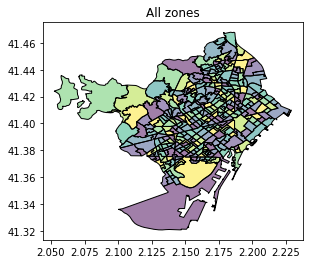

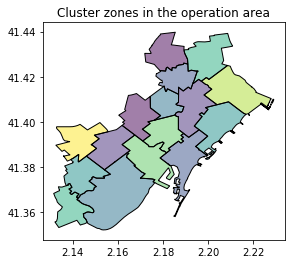

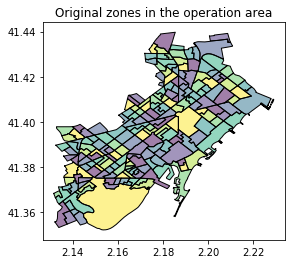

In [626]:
zones_[(zones_['trips_des']>100)].plot()
plt.title('All zones')
b=zones_[(zones_['geometry'].area<0.001)&(zones_['trips_des']>100)
                                                        &(
                                                            ((zones_['NO']>=300)&(zones_['NO']<350))
                                                          |((zones_['NO']>=350)&(zones_['NO']<400))
                                                        |((zones_['NO']>=600)&(zones_['NO']<700))
#                                                           |((zones_['NO']>=400)&(zones_['NO']<430))
#                                                           |((zones_['NO']>=460)&(zones_['NO']<525))
                                                         )]['NO'].tolist()
a=cluster_zones[cluster_zones['NO'].isin(b)]['cluster_labels'].tolist()
cluster_zones_agg[(cluster_zones_agg['geometry'].area<0.001)&(cluster_zones_agg['cluster_labels'].isin(a))].plot()
plt.title('Cluster zones in the operation area')
c=cluster_zones_agg[(cluster_zones_agg['geometry'].area<0.001)&(cluster_zones_agg['cluster_labels'].isin(a))]['cluster_labels'].tolist()
zone_list_for_requests=cluster_zones[cluster_zones['cluster_labels'].isin(c)]['NO'].tolist()
zones_[(zones_['NO'].isin(zone_list_for_requests))].plot()
plt.title('Original zones in the operation area')

### generate timestamp and location for requests 

c:\python37\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
c:\python37\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ratio 0.004280382152518577
number of trips in scenario 
 8507


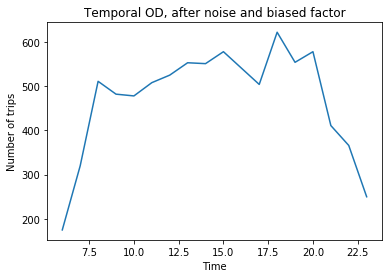

c:\python37\lib\site-packages\ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\python37\lib\site-packages\ipykernel_launcher.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


number of trips after sampling  
 8507
number of requests 8507


In [639]:
cluster_zones=cluster_zones[['geometry','NO','cluster_labels']]

scenario_properties={'Trips_in_one_day_before_noise_and_bias':es_total_demand,
                    'White_noise_factor':wn_time_step,
                    'Morning_bias_factor':bi_morning,
                    'Evening_bias_factor':bi_morning,
                    'operation_start_time':operation_start_time,
                    'operation_end_time':operation_end_time,
                    'zone_number_used':list(zone_list_for_requests),
                    'number_of_zone_pickup_and_dropoff':how_many_zones}
path=path_dic['scenario']
with open(path+'scenario_properties.json', "w") as f:
    json.dump(scenario_properties, f)

# zones_.drop(['cluster_labels_x', 'cluster_labels_y'],1,inplace=True)

def save_zone_for_online(zones,zone_list_for_requests):
    zones=zones[(zones['NO'].isin(zone_list_for_requests))]
    zones=zones.dissolve(by='cluster_labels')
    zones['PTV_mercator']=Polygon()
    zones['PTV_mercator_list']=[[] for _ in range(len(zones))]
    zones.loc[zones['geometry'].geom_type == 'Polygon','PTV_mercator_list']=zones.loc[zones['geometry'].geom_type == 'Polygon','geometry'].apply(
        lambda x: [WGS84_2_PTVMercator([x,y]) for [x,y] in np.dstack(x.exterior.coords.xy)[0].tolist()])

    zones.loc[zones['geometry'].geom_type == 'Polygon','PTV_mercator']=zones.loc[zones['geometry'].geom_type == 'Polygon','PTV_mercator_list'].apply(
    lambda x: Polygon(x))
    
    zones['geometry']=zones['PTV_mercator']
    zones=zones[zones['geometry'].apply(lambda x: x.geom_type == 'Polygon')]
    zones=zones[zones['geometry'].apply(lambda x: isinstance(x, Polygon))]
    zones=zones[zones['geometry'].apply(lambda x: len(x.centroid.coords)>0)]
    zones['centriod']=zones['geometry'].centroid.apply(lambda pnt: [list(pnt.coords[0])[0],list(pnt.coords[0])[1]])
    zone_list_for_requests=zones['NO'].tolist()
    zones['NO']=zones.index
    zone_attribute=zones[['NO','centriod']]
    zone_attribute.rename(columns={'NO': 'zone','centriod': 'zone_center_coord'}, inplace=True)
    path=path_dic['scenario']
    zone_attribute.to_csv(path+'zone_attribute.csv',sep=';',index=False)
    
    zones=zones[['NO','geometry','PTV_mercator_list']]
    path=path_dic['scenario']
#     print(zones['geometry'].geom_type)
    zones.to_csv(path+"Zones_ptv_mercator.csv",sep=';',index=False)
    
save_zone_for_online(cluster_zones,zone_list_for_requests)

path=path=path_dic['scenario']
cluster_labels_list_for_requests=pd.read_csv(path+'zone_attribute.csv',sep=';')['zone'].tolist()
if 'cluster_labels' not in zones_.columns.tolist():
    zones_=pd.merge(zones_,cluster_zones[['NO', 'cluster_labels']],how='left',on="NO")

zone_list_for_requests_2=zones_.loc[zones_['cluster_labels'].isin(cluster_labels_list_for_requests),'NO'].tolist()
zone_list_for_requests=set(zone_list_for_requests).intersection(set(zone_list_for_requests_2))
df_nodes_in_zones=generate_request_nodes_for_all_zones(number_nodes_per_zone,zones_[(zones_['NO'].isin(zone_list_for_requests))])

df_nodes_in_zones['PTVMercator']=df_nodes_in_zones[['WGS84']].apply(lambda row: WGS84_2_PTVMercator(row['WGS84']),axis=1)

df_nodes_in_zones=pd.merge(df_nodes_in_zones,cluster_zones[['NO', 'cluster_labels']],how='left',on="NO")
df_nodes_in_zones.to_csv('df_nodes_in_zones.csv',sep=';',index=False)
OD_for_request=OD_.loc[(OD_['ori'].isin(zone_list_for_requests)) & (OD_['des'].isin(zone_list_for_requests)) ]
OD_for_request=OD_.loc[(OD_['ori'].isin(zone_list_for_requests)) & (OD_['des'].isin(zone_list_for_requests)) ]
df_requests=generate_requests(OD_for_request, 
                                        es_total_demand, wn_time_step, bi_morning, bi_evening,
                                         df_nodes_in_zones, number_nodes_per_zone,
                                       operation_start_time, operation_end_time,cluster_zones[['NO', 'cluster_labels']])


### get travel time for requests

In [640]:
x_server = XServer()
def get_travel_time(o,d, x_server):
    list_coor=[o,d]  
    profile="car"
#     try:
    route_request=x_server.make_route_request( profile, list_coor)
    distance, travel_time, way_points=x_server.send_route_request(route_request)
    return [travel_time,way_points]
#     except TypeError:
#         print(list_coor) 
#         return [-11,[{'linkedCoordinate':{'x':0,'y':0}}]]
        
# df_requests['request']=df_requests.apply(lambda row:row['from_y_coordinate']+1)    

# df_requests['request']=df_requests.apply(lambda row:[[row['from_y_coordinate'],row['from_x_coordinate']],[row['to_y_coordinate'],row['to_x_coordinate']]])    
df_requests['travel_time_way_points']=df_requests[['o_PTVMercator','d_PTVMercator']].apply(lambda row:
                                        get_travel_time(row['o_PTVMercator'],row['d_PTVMercator'],x_server), axis=1)
df_requests['travel_time']=df_requests['travel_time_way_points'].apply(lambda x:x[0])
df_requests['way_points']=df_requests['travel_time_way_points'].apply(lambda x:x[1])
df_requests['o_PTVMercator']=df_requests['way_points'].apply(lambda x:[x[0]['linkedCoordinate']['x'],x[0]['linkedCoordinate']['y']])
df_requests['d_PTVMercator']=df_requests['way_points'].apply(lambda x:[x[1]['linkedCoordinate']['x'],x[1]['linkedCoordinate']['y']])

df_requests[df_requests['o_PTVMercator']!=df_requests['d_PTVMercator']]
df_requests=df_requests[df_requests['travel_time']>120]
print('number of requests, after eliminating too short trips', len(df_requests))

number of requests, after eliminating too short trips 8227


### request stat

average travel time is: 7.993478388233863 minutes


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DBC0C2F198>]],
      dtype=object)

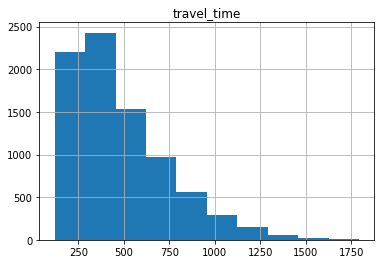

In [641]:
print('average travel time is:',df_requests['travel_time'].mean()/60, 'minutes')
df_requests.hist(['travel_time'])

### Write requests to file 

In [642]:
def write_request_in_json_format(id, birth_time,ori,des, o,d,travel_time,
                                detour_factor=1.6,
                                max_waiting_time=600):
    
    request={'Id': str(int(id)),
     'BirthTime': int(birth_time),
     'PassengersCount': 1,
     'EarliestDeparture': int(birth_time),
     'LatestDeparture': int(birth_time+max_waiting_time),
     'LatestArrival':int(birth_time+max_waiting_time+detour_factor*travel_time),
     'FromZoneId': 0,#int(ori),
     'FromZoneX': o[0],
     'FromZoneY': o[1],
     'ToZoneId': 0,#int(des),
     'ToZoneX': d[0],
     'ToZoneY': d[1],
     'FromId': 0,
     'FromX': o[0],
     'FromY': o[1],
     'ToId': 10,
     'ToX': d[0],
     'ToY': d[1],
     'BoardingAndAlightingTime': 60,
     'WalkingTimeBefore': 0,
     'WalkingTimeAfter': 0,
     'DirectTravelTime': int(travel_time),
     'StartNodeId': 0,
     'DestinationNodeId': 0
            }
#     print(request)
#     request=json.dumps(request)
    return request

df_requests.index = range(1,len(df_requests.index)+1)
df_requests['id']=df_requests.index
for col in ['id','birth_time','travel_time']:
    df_requests[col] = df_requests[col].astype(int)
df_requests['birth_time'][1]=0  
df_requests['json_format']=df_requests[['id','birth_time','ori','des','o_PTVMercator',
                                       'd_PTVMercator','travel_time']].apply(
                            lambda row: write_request_in_json_format(row['id'], row['birth_time'],row['ori'],row['des'],
                                                                     row['o_PTVMercator'],
                                                                     row['d_PTVMercator'],row['travel_time']), axis=1)


path=path_dic['scenario']
with open(path+'TripRequests.json', "w") as f:
    request_list=df_requests['json_format'].tolist()
#     TripRequest_sample = 
    json.dump(request_list, f)
# TripRequest_sample[0]

df_nodes_tetx=pd.DataFrame({'coor':df_requests['o_PTVMercator'].tolist()+df_requests['d_PTVMercator'].tolist()})
df_nodes_tetx.reset_index()
df_nodes_tetx['NO']=df_nodes_tetx.index
df_nodes_tetx['XCOORD']=df_nodes_tetx['coor'].apply(lambda x:x[0])
df_nodes_tetx['YCOORD']=df_nodes_tetx['coor'].apply(lambda x:x[1])
df_nodes_tetx=df_nodes_tetx[['NO','XCOORD','YCOORD']]
min_x=df_nodes_tetx['XCOORD'].min()
min_y=df_nodes_tetx['YCOORD'].min()
max_x=df_nodes_tetx['XCOORD'].max()
max_y=df_nodes_tetx['YCOORD'].max()
max_NO=df_nodes_tetx['NO'].max()
range_x=max_x-min_x
range_y=max_y-min_y
df_margin_nodes=pd.DataFrame(data={'NO':[max_NO+1,max_NO+2],'XCOORD':[min_x-.2*range_x,max_x+.2*range_x],
                                   'YCOORD':[min_y-.2*range_y,max_y+.2*range_y]})
df_nodes_tetx=pd.concat([df_nodes_tetx,df_margin_nodes],0)
path=path_dic['scenario']
df_nodes_tetx.to_csv(path+'Nodes.txt', index=None,sep=';')

c:\python37\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## determine charger prameters: stage[3] skip to 2.4 otherwise

### clustering plugs to charging stations

In [799]:
import random
def RandFloats(Size):
    Scalar = 1.0
    VectorSize = Size
    RandomVector = [random() for i in range(VectorSize)]
    RandomVectorSum = sum(RandomVector)
    RandomVector = [Scalar*i/RandomVectorSum for i in RandomVector]
    return RandomVector

from numpy.random import multinomial
import math
def RandIntVec(ListSize, ListSumValue, Distribution='Normal'):
    """
    Inputs:
    ListSize = the size of the list to return
    ListSumValue = The sum of list values
    Distribution = can be 'uniform' for uniform distribution, 'normal' for a normal distribution ~ N(0,1) with +/- 5 
    sigma  (default), or a list of size 'ListSize' or 'ListSize - 1' for an empirical (arbitrary) distribution.
    Probabilities of each of the p different outcomes. These should sum to 1 (however, the last element is always
    assumed to account for the remaining probability, as long as sum(pvals[:-1]) <= 1).  
    Output:
    A list of random integers of length 'ListSize' whose sum is 'ListSumValue'.
    """
    if type(Distribution) == list:
        DistributionSize = len(Distribution)
        if ListSize == DistributionSize or (ListSize-1) == DistributionSize:
            Values = multinomial(ListSumValue,Distribution,size=1)
            OutputValue = Values[0]
    elif Distribution.lower() == 'uniform': #I do not recommend this!!!! I see that it is not as random (at least on my computer) as I had hoped
        UniformDistro = [1/ListSize for i in range(ListSize)]
        Values = multinomial(ListSumValue,UniformDistro,size=1)
        OutputValue = Values[0]
    elif Distribution.lower() == 'normal':
        """
        Normal Distribution Construction....It's very flexible and hideous
        Assume a +-3 sigma range.  Warning, this may or may not be a suitable range for your implementation!
        If one wishes to explore a different range, then changes the LowSigma and HighSigma values
        """
        LowSigma    = -2#-3 sigma
        HighSigma   = 2#+3 sigma
        StepSize    = 1/(float(ListSize) - 1)
        i=0
        ZValues     = [(LowSigma * (1-i*StepSize) +(i*StepSize)*HighSigma) for i in range(int(ListSize))]
        #Construction parameters for N(Mean,Variance) - Default is N(0,1)
        Mean        = 0
        Var         = 1
        #NormalDistro= [self.NormalDistributionFunction(Mean, Var, x) for x in ZValues]
        NormalDistro= list()

        for i in list(range(len(ZValues))):
            if i==0:
                ERFCVAL = 0.5 * math.erfc(-ZValues[i]/math.sqrt(2))
                NormalDistro.append(ERFCVAL)
            elif i ==  len(ZValues) - 1:
                ERFCVAL = NormalDistro[0]
                NormalDistro.append(ERFCVAL)
            else:
                ERFCVAL1 = 0.5 * math.erfc(-ZValues[i]/math.sqrt(2))
                ERFCVAL2 = 0.5 * math.erfc(-ZValues[i-1]/math.sqrt(2))
                ERFCVAL = ERFCVAL1 - ERFCVAL2
                NormalDistro.append(ERFCVAL)  
            #print "Normal Distribution sum = %f"%sum(NormalDistro)
            Values = multinomial(ListSumValue,NormalDistro,size=1)
            OutputValue = Values[0]
#         else:
#             raise ValueError ('Cannot create desired vector')
#         return OutputValue
#     else:
#         raise ValueError ('Cannot create desired vector')
    return OutputValue


#Some Examples    
def get_cluster_pf_plugs(number_of_stations,number_of_plugs):
    ListSize = number_of_stations
    ListSumValue = number_of_plugs
    list_number_of_plugs=np.zeros(ListSize)
    while min(list_number_of_plugs)<=0:
        list_number_of_plugs=RandIntVec(ListSize, ListSumValue,Distribution='Normal')
        list_number_of_plugs=np.array(list_number_of_plugs)
    return list_number_of_plugs
list_number_of_slow_plugs=get_cluster_pf_plugs(number_of_slow_stations,number_of_slow_plugs)
list_number_of_fast_plugs=get_cluster_pf_plugs(number_of_fast_stations,number_of_fast_plugs)



list_number_of_slow_plugs

array([1, 4, 7, 8, 7, 3])

### location of chargers

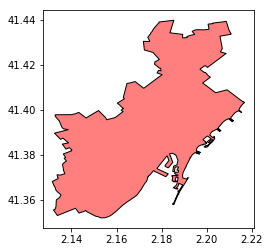

In [787]:
# completely randome charging locations
# make one polygone from 
# generate nodes within that


boundary = GeoSeries(cascaded_union(zones_[zones_['NO'].isin(zone_list_for_requests) ]['geometry'].tolist()))
boundary.plot(color = 'red')
plt.show()

def generate_random_one_zone(number, polygon):
    df_list_of_points=pd.DataFrame(columns=['node','WGS84'])
    bounds = polygon.bounds
#         print(polygon.bounds,'\n',polygon.area)
    counter = 0
    while counter < number:
        pnt = Point(uniform(bounds['minx'], bounds['maxx']), uniform(bounds['miny'], bounds['maxy']))
        if np.sum(polygon.contains(pnt)):
#                 print(pnt.coords)
#                 print([list(pnt.coords[0])[0],list(pnt.coords[0])[1]])
            df_list_of_points.loc[counter] = [pnt, [list(pnt.coords[0])[0],list(pnt.coords[0])[1]]]
            counter += 1
    df_list_of_points['PTVMercator']=df_list_of_points[['WGS84']].apply(lambda row: WGS84_2_PTVMercator(row['WGS84']),axis=1)
    return df_list_of_points  

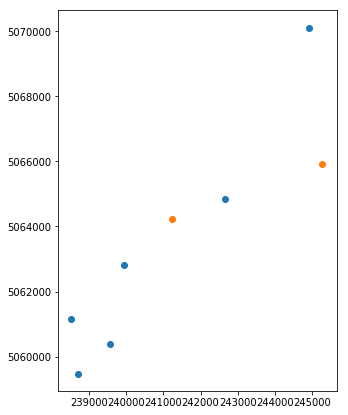

In [878]:

df_list_of_charger_coords=generate_random_one_zone(number_of_slow_stations+number_of_fast_stations,boundary)
list_number_of_slow_plugs
charger_id=np.arange(number_of_slow_stations+number_of_fast_stations)+1
capacity=np.append(list_number_of_slow_plugs,list_number_of_fast_plugs)
fast=np.append(np.zeros(number_of_slow_stations),np.ones(number_of_fast_stations))
slow=np.append(np.ones(number_of_slow_stations),np.zeros(number_of_fast_stations))
charger_location=df_list_of_charger_coords['PTVMercator'].tolist()
charger_zone=np.append(np.arange(number_of_slow_stations)+1001,np.arange(number_of_fast_stations)+10001)
charger_attribute=pd.DataFrame(data= {'charger_id':charger_id,'capacity':capacity,'fast':fast,'slow':slow,'charger_location':charger_location,'charger_zone':charger_zone})
path=path_dic['scenario']
charger_attribute.to_csv(path+'charger_attribute.csv',sep=';')
plt.figure(figsize=(5,7))
plt.scatter(charger_attribute[charger_attribute['slow']==1]['charger_location'].apply(lambda x:x[0]),
           charger_attribute[charger_attribute['slow']==1]['charger_location'].apply(lambda x:x[1]))
plt.scatter(charger_attribute[charger_attribute['fast']==1]['charger_location'].apply(lambda x:x[0]),
           charger_attribute[charger_attribute['fast']==1]['charger_location'].apply(lambda x:x[1]))


## route costs for online planning : stage [2, 3]

### Zone to Zone costs for B: stage [2, 3]

In [879]:
if stage in [2,3]:
    x_server = XServer()
    profile="car"
    df_nodes_in_zones=pd.read_csv('df_nodes_in_zones.csv',sep=';')
    df_nodes_in_zones['PTVMercator']=df_nodes_in_zones[['WGS84']].apply(lambda row: WGS84_2_PTVMercator(literal_eval(row['WGS84'])),axis=1)
    df_nodes_for_cost_matrix=df_nodes_in_zones[df_nodes_in_zones['node_id']<5]
    df_nodes_for_cost_matrix['NO']=df_nodes_for_cost_matrix['cluster_labels']
    df_nodes_for_cost_matrix=df_nodes_for_cost_matrix
    path=path_dic['scenario']
    zone_attribute=pd.read_csv(path+'zone_attribute.csv',sep=';')
    zone_center_locations=zone_attribute['zone_center_coord'].apply(lambda x: literal_eval(x)).tolist()
    zone_center_ids=zone_attribute['zone'].tolist()
    if stage==3:
        charger_attribute=pd.read_csv(path+'charger_attribute.csv',sep=';')
        charger_attribute['charger_location']=charger_attribute['charger_location'].apply(lambda x: literal_eval(x)).tolist()
        strat_locations=df_nodes_for_cost_matrix['PTVMercator'].tolist()+charger_attribute['charger_location'].tolist()
        strat_list_zone_id_for_locations=np.array(df_nodes_for_cost_matrix['NO'].tolist()+charger_attribute['charger_zone'].tolist())
        destination_locations=zone_center_locations+charger_attribute['charger_location'].tolist()
        destination_list_zone_id_for_locations=np.array(zone_center_ids+charger_attribute['charger_zone'].tolist())
    else:
        strat_locations=df_nodes_for_cost_matrix['PTVMercator'].tolist()
        strat_list_zone_id_for_locations=np.array(df_nodes_for_cost_matrix['NO'].tolist())
        destination_locations=zone_center_locations
        destination_list_zone_id_for_locations=np.array(zone_center_ids)
    
    num_id_start=len(strat_list_zone_id_for_locations)
    num_id_end=len(destination_list_zone_id_for_locations)
    Origin_zone_id=np.reshape(np.tile(strat_list_zone_id_for_locations[:,np.newaxis],[1,num_id_end]),[num_id_start*num_id_end],'C')
    
    destination_zone_id=np.reshape(np.tile(destination_list_zone_id_for_locations[np.newaxis,:],[num_id_start,1]),[num_id_start*num_id_end],'C')

    request=x_server.make_cost_matrix_request(profile, strat_locations,destination_locations)
    distance_mat,travel_time_mat=x_server.send_cost_matrix_request(request)
    df_cost_matrix=pd.DataFrame({'origin': Origin_zone_id, 'destination': destination_zone_id, 
                                 'distance':distance_mat, 'travel_time':travel_time_mat})

    df_cost_matrix=df_cost_matrix.groupby(['origin','destination']).mean().reset_index()
    path=path_dic['scenario']
    df_cost_matrix.to_csv(path+'df_cost_matrix.csv',sep=';',index=False)

c:\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### charge to zone routing cost for C: stage [3]

In [880]:
if stage in [3]:
    x_server = XServer()
    profile="car"
    path=path_dic['scenario']
    zone_attribute=pd.read_csv(path+'zone_attribute.csv',sep=';')
    charger_attribute=pd.read_csv(path+'charger_attribute.csv',sep=';')
    origin_locations=charger_attribute['charger_location'].apply(lambda x: literal_eval(x)).tolist()
    destination_locations=zone_attribute['zone_center_coord'].apply(lambda x: literal_eval(x)).tolist()
    origin_ids=np.array(charger_attribute['charger_id'].tolist())
    destination_ids=np.array(zone_attribute['zone'].tolist())
    Origin_2d_id=np.reshape(np.tile(origin_ids[:,np.newaxis],[1,len(destination_ids)]),[len(origin_ids)*len(destination_ids)],'C')
    destination_2d_id=np.reshape(np.tile(destination_ids[np.newaxis,:],[len(origin_ids),1]),[len(origin_ids)*len(destination_ids)],'C')

    request=x_server.make_cost_matrix_request(profile, origin_locations,destination_locations)
    distance_mat,travel_time_mat=x_server.send_cost_matrix_request(request)

    cost_charger_to_zone_center=pd.DataFrame({'charger': Origin_2d_id, 'zone': destination_2d_id, 
                                 'distance':distance_mat, 'travel_time':travel_time_mat})

    path=path_dic['scenario']
    cost_charger_to_zone_center.to_csv(path+'cost_charger_to_zone_center.csv',sep=';',index=False)


### generate bands showing distance to neasrest charging station: stage [3]

In [881]:
if stage in [3]:
    # make isocrones 5, 10, 15, 20, km from easch
    #merge each band 
    path=path_dic['scenario']
    df_list_of_charger_coords=pd.read_csv(path+'charger_attribute.csv',sep=';')
    df_list_of_charger_coords['charger_location']=df_list_of_charger_coords['charger_location'].apply(lambda x:literal_eval(x))
    list_of_bands=[5, 10, 15, 20]
    boundary_to_nearset_charger={}
    x_server = XServer()
    def get_isochrone(profile, point , horizon_bands,horizon_unit='Distance', direction='INBOUND', fast_option=0):
        request=x_server.make_isochrone_request(profile, point, horizon_unit, horizon_bands, direction='INBOUND', fast_option=0)
        polygon=x_server.send_isochrone_request(request)
        return polygon
    n=len(df_list_of_charger_coords)
    df_list_of_charger_coords=df_list_of_charger_coords.reindex(df_list_of_charger_coords.index.repeat(len(list_of_bands)))
    df_list_of_charger_coords['reach']=np.tile(np.array(list_of_bands),n)
    df_list_of_charger_coords.index=range(len(df_list_of_charger_coords))
    df_list_of_charger_coords['iso_response']=df_list_of_charger_coords.apply(lambda row: get_isochrone('car', row['charger_location'] , [row['reach']*1000]),axis=1) 
    df_list_of_charger_coords['iso_polygon']=df_list_of_charger_coords['iso_response'].apply(lambda
        x:  Polygon([[node['x'],node['y']] for node in x[0]['polygon']['plain']['polygonRings'][0]["polyline"]]))

    gdf_ReacableArea = GeoDataFrame(df_list_of_charger_coords[['reach']], geometry=df_list_of_charger_coords['iso_polygon'])

    path=path_dic['scenario']
    gdf_ReacableArea.to_file(path+"gdf_ReacableArea.shp")


### get closest charger (based on great-circle distance) polygons for lazy charging algorithm 

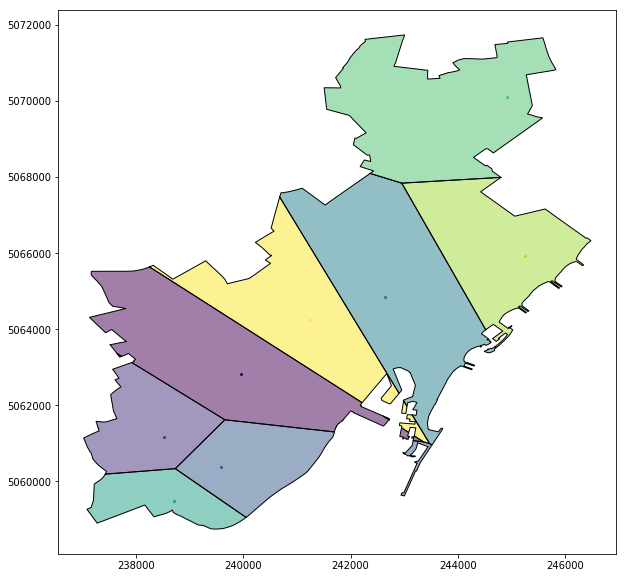

In [882]:

path=path_dic['scenario']
charger_attribute=pd.read_csv(path+'charger_attribute.csv',sep=';')
charger_attribute['charger_location']=charger_attribute['charger_location'].apply(lambda x:literal_eval(x))
charger_attribute.index=np.arange(len(charger_attribute))
chargers=charger_attribute
geometry = [Point(x) for x in chargers['charger_location'].tolist()]
crs = {'init': 'ptv_mercator'}
gdf_chargers = GeoDataFrame(chargers, crs=crs, geometry=geometry)

df=pd.read_csv(path+"Zones_ptv_mercator.csv",sep=';')
df['PTV_mercator_list']=df['PTV_mercator_list'].apply(lambda x:literal_eval(x))
geometry = [Polygon(x) for x in df.PTV_mercator_list.tolist()]
crs = {'init': 'ptv_mercator'}
zones = GeoDataFrame(df, crs=crs, geometry=geometry)
boundary = GeoSeries(cascaded_union(zones['geometry'].tolist()))

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)
points = np.array(gdf_chargers['charger_location'].tolist())[:15,:]
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)
box=boundary[0]
# colorize

geom_list=[]
for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    geom_list+=[poly]
crs = {'init': 'ptv_mercator'}
closest_charger_zones = GeoDataFrame( crs=crs, geometry=geom_list)
# closest_charger_zones=closest_charger_zones[(closest_charger_zones['geometry'].apply(lambda x:x.centroid.within(boundary[0])))]
# closest_charger_zones=closest_charger_zones[closest_charger_zones['geometry'].area>5e5]
# print(len(closest_charger_zones))
closest_charger_zones = sjoin(closest_charger_zones,gdf_chargers, how="left", op='contains')
# path_=path_dic['scenario']
# closest_charger_zones.to_csv(path+"closest_charger_zones.csv",sep=';',index=False)
fig, ax = plt.subplots(figsize = (5,7)) 
closest_charger_zones.plot(ax=ax)
gdf_chargers.plot(ax=ax)
closest_charger_zones.rename(columns={'zone':'charger_id'},inplace=True)
closest_charger_zones=GeoDataFrame( closest_charger_zones[['charger_id', 'charger_location']],
                                   crs=crs,
                                   geometry=closest_charger_zones.geometry)
path=path_dic['scenario']
closest_charger_zones.to_pickle(path+"closest_charger_zones.pkl")


# Daily planning: stage [3]

## reading data for whole day from stage 2 (with relocation and no charging)

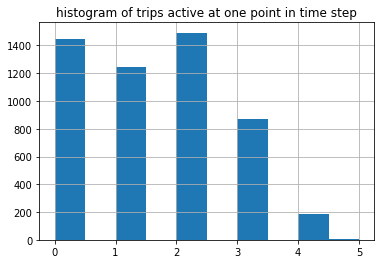

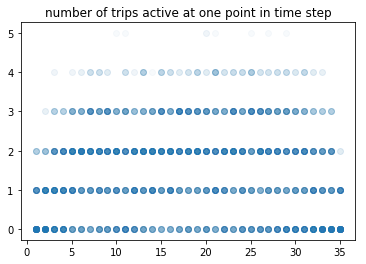

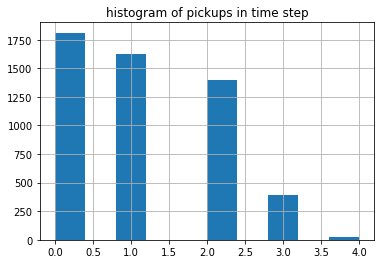

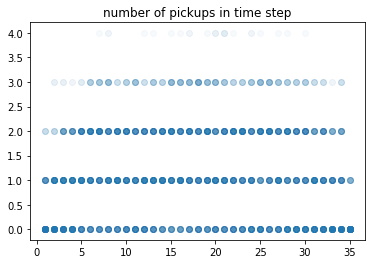

Text(0.5, 1.0, 'Average number of pickups for vehicles with atleast one trip \n (Zonal prediction of pick up and drop offs are divided by this value) ')

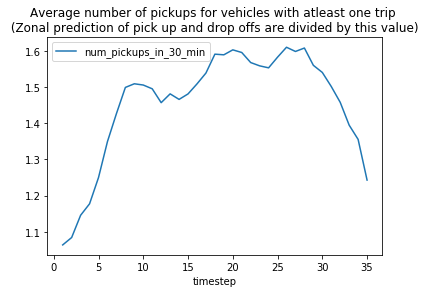

In [1017]:
path=path_dic['scenario']+'results/'+str(int(stage-1))+'/toure and trajectory/'
df_EVehicleTours_day=pd.read_csv(path+'df_EVehicleTours_day.csv',sep=';')
df_EVehicleTours_day_agg=get_df_EVehicleTours_day_agg(df_EVehicleTours_day)
df_EVehicleTours_day_agg['num_trips_in_30_min'].hist()
plt.title('histogram of trips active at one point in time step')
plt.show()
plt.scatter(df_EVehicleTours_day_agg['timestep'],df_EVehicleTours_day_agg['num_trips_in_30_min'],alpha=0.03)
plt.title('number of trips active at one point in time step')
plt.show()
df_EVehicleTours_day_agg['num_pickups_in_30_min'].hist()
plt.title('histogram of pickups in time step')
plt.show()
plt.scatter(df_EVehicleTours_day_agg['timestep'],df_EVehicleTours_day_agg['num_pickups_in_30_min'],alpha=0.03)
plt.title('number of pickups in time step')
plt.show()

df_EVehicleTours_day_agg_=df_EVehicleTours_day_agg[df_EVehicleTours_day_agg['num_pickups_in_30_min']>0]
devide_PU_DO_by=df_EVehicleTours_day_agg_.groupby('timestep')['num_pickups_in_30_min'].mean().rolling(4,min_periods=1).mean()
devide_PU_DO_by=0.9*devide_PU_DO_by
devide_PU_DO_by.plot()
devide_PU_DO_by=devide_PU_DO_by.tolist()
path=path_dic['scenario']
with open(path+'devide_PU_DO_by.json', "w") as f:
    json.dump(devide_PU_DO_by, f)
# path=path_dic['scenario']+'devide_PU_DO_by_prior.json'
# if os.path.exists(newpath):
#     with open(path, "r") as f:
#         devide_PU_DO_by_pre=json.load(f)
#     plt.plot(devide_PU_DO_by_pre,label='prior')
plt.legend()
plt.title('Average number of pickups for vehicles with atleast one trip \n (Zonal prediction of pick up and drop offs are divided by this value) ')

In [1018]:
path=path_dic['scenario']+'results/'+str(int(stage-1))+'/toure and trajectory/'
df_EVehicleTrejectory_day_agg,fleet_size=read_daily_trejectories(path)

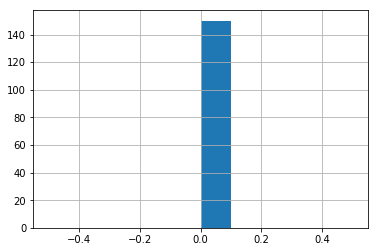

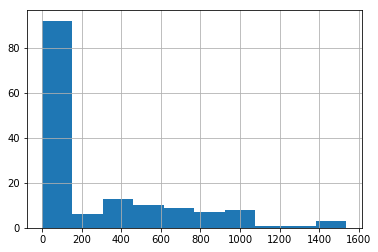

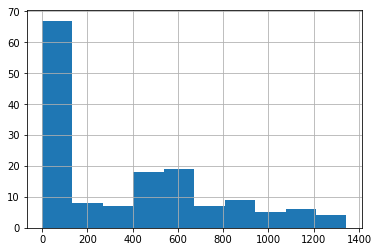

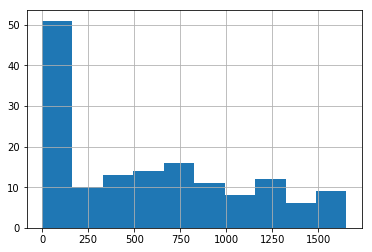

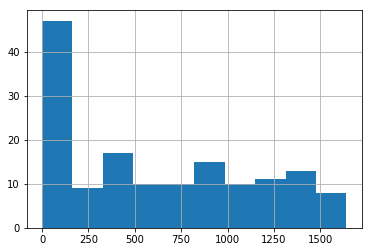

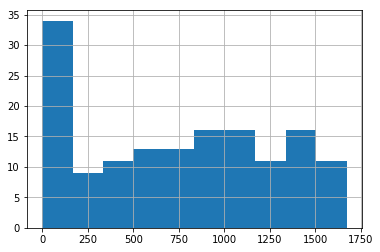

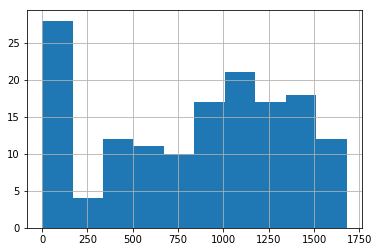

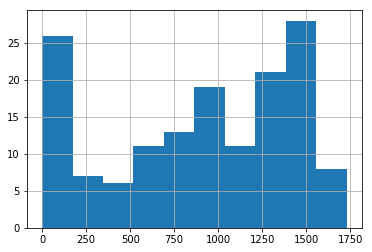

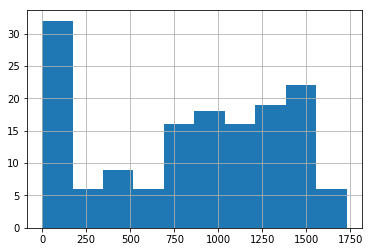

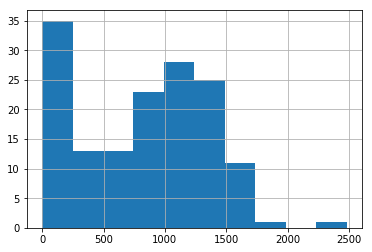

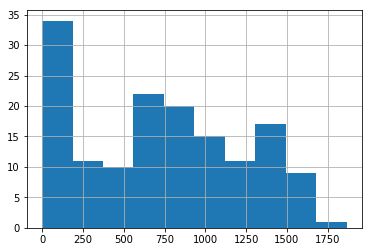

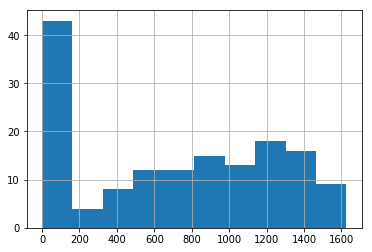

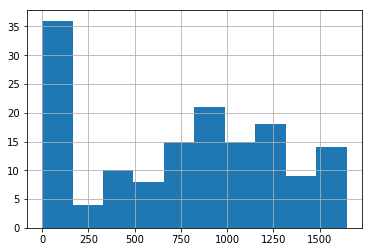

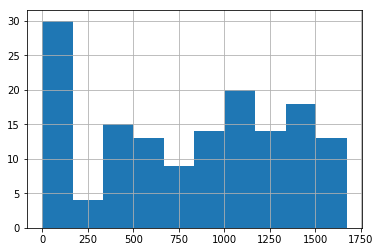

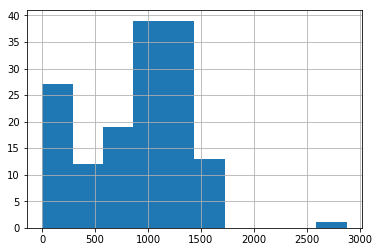

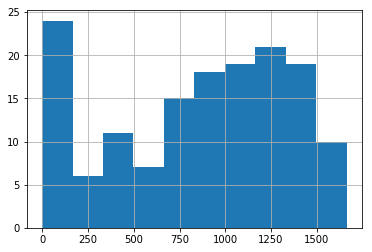

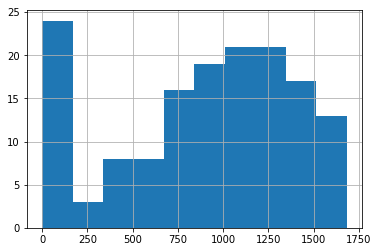

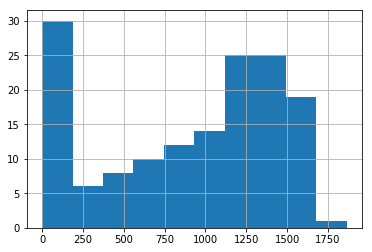

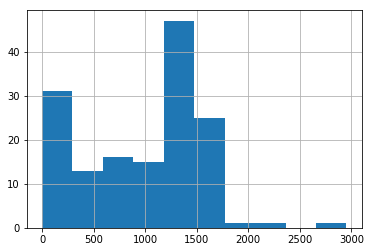

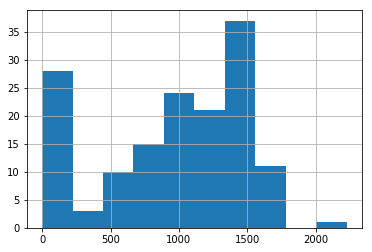

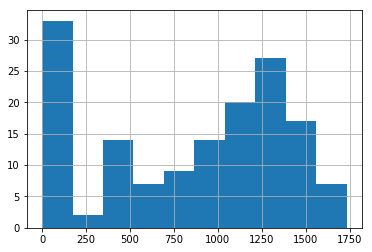

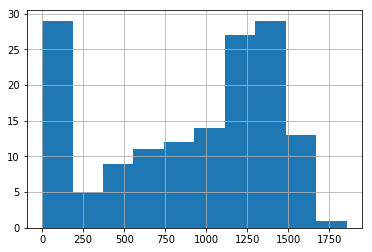

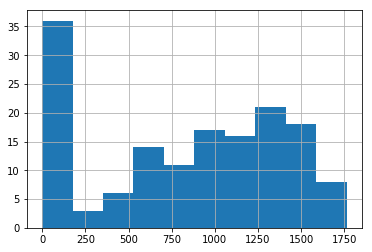

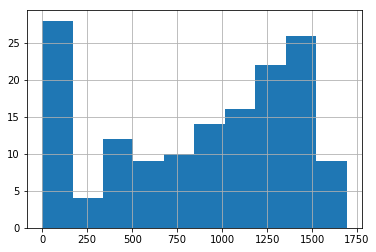

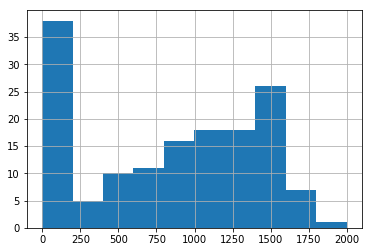

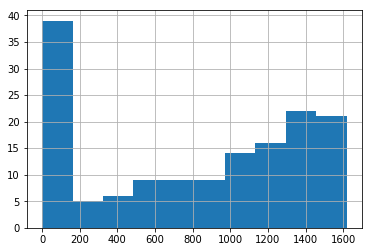

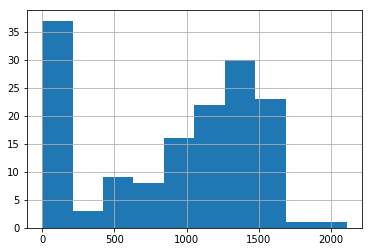

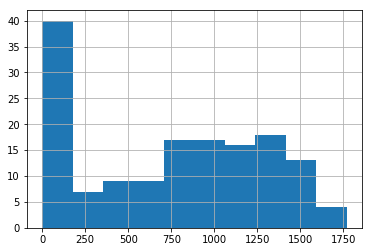

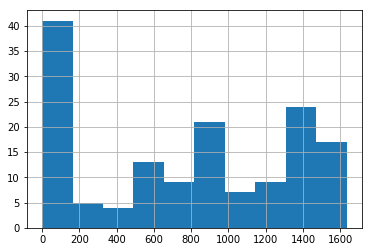

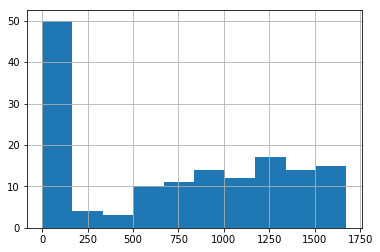

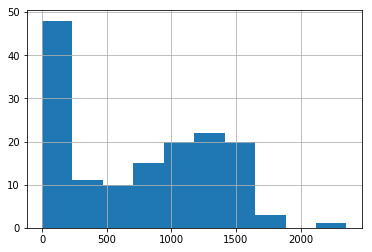

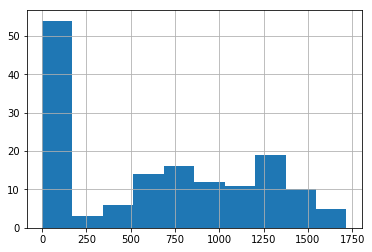

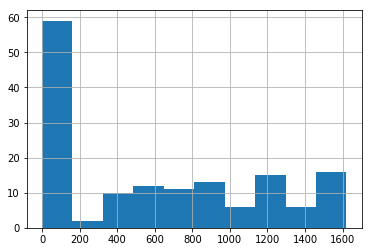

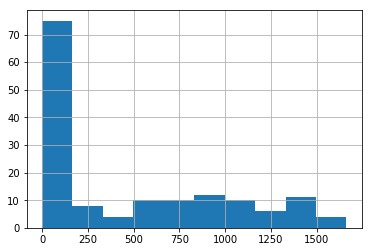

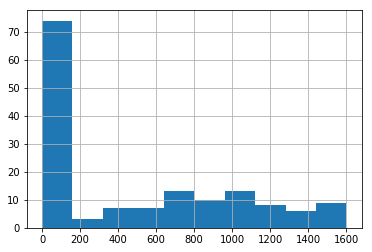

In [1019]:
num_of_time_steps=df_EVehicleTrejectory_day_agg['time_step'].max()
for t in range(num_of_time_steps):
    print()
    df_EVehicleTrejectory_day_agg[df_EVehicleTrejectory_day_agg['time_step']==t]['travel_time'].hist()
    plt.show()

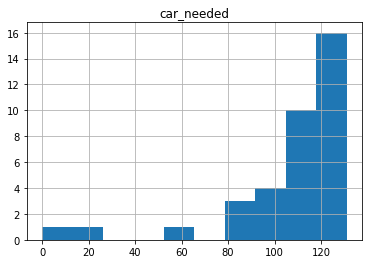

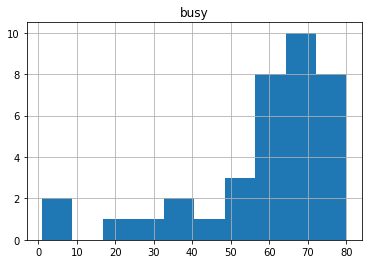

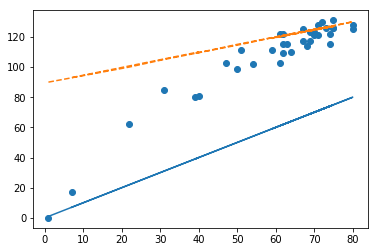

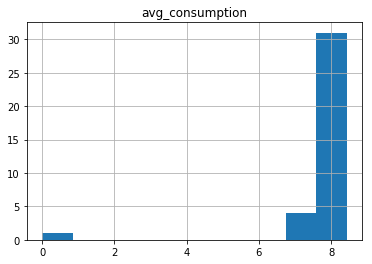

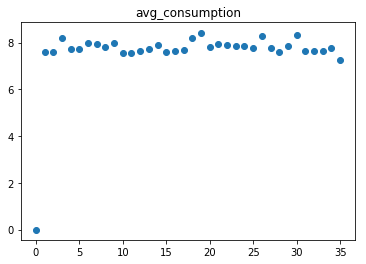

In [1020]:
df_EVehicleTrejectory_day_agg.loc[df_EVehicleTrejectory_day_agg['travel_time']>1800,'travel_time']=1800
df_EVehicleTrejectory_day_agg['car_needed']=df_EVehicleTrejectory_day_agg['travel_time'].apply(lambda x:x>0)
df_num_busy=df_EVehicleTrejectory_day_agg.groupby(['time_step'])['consumption','travel_time','car_needed'].sum().reset_index()
df_num_busy['busy']=df_num_busy['travel_time'].apply(lambda x:int(x/1800)+1)
df_num_busy['avg_consumption']=df_num_busy['consumption']/df_num_busy['busy']

df_num_busy[['car_needed']].hist()
plt.show()
df_num_busy[['busy']].hist()
plt.show()
plt.scatter(df_num_busy['busy'],df_num_busy['car_needed'])
plt.plot(df_num_busy['busy'],df_num_busy['busy'])
number_of_cars=150
number_of_time_slots=len(df_num_busy['busy'])

def busy_cars_to_charged_cars_needed(x,number_of_cars=number_of_cars):
    if x<=number_of_cars*0.5:
        y=number_of_cars*0.5+x
    if x>number_of_cars*.5:
        y=number_of_cars
    y=int(y)
    return y
number_charged_cars_needed=np.zeros_like(df_num_busy['busy'].values)
for i in range(number_of_time_slots):
    number_charged_cars_needed[i]=busy_cars_to_charged_cars_needed(df_num_busy['busy'].values[i])
plt.plot(df_num_busy['busy'],number_charged_cars_needed,linestyle='--')
plt.show()
df_num_busy[['avg_consumption']].hist()
plt.show()
plt.scatter(df_num_busy['time_step'],df_num_busy['avg_consumption'])
plt.title('avg_consumption')
plt.show()

In [1021]:

def get_input_for_A(df_EVehicleTrejectory_day_agg):
#     df_EVehicleTrejectory_day_agg.loc[df_EVehicleTrejectory_day_agg['travel_time']>1800,'travel_time']=1800
    df_EVehicleTrejectory_day_agg['car_needed']=df_EVehicleTrejectory_day_agg['travel_time'].apply(lambda x:x>0)
    df_num_busy=df_EVehicleTrejectory_day_agg.groupby(['time_step'])['consumption','travel_time','car_needed'].sum().reset_index()
    df_num_busy['busy']=df_num_busy['travel_time'].apply(lambda x:int(x/1800)+1)
    df_num_busy['avg_consumption']=df_num_busy['consumption']/df_num_busy['busy']
    demand=df_num_busy['busy'].values
    car_needed_lower_bound=df_num_busy['car_needed'].values
    consumption_per_step=df_num_busy.loc[df_num_busy['avg_consumption']>3,'avg_consumption'].mean()
    def busy_cars_to_charged_cars_needed(x,number_of_cars=number_of_cars):
        if x<number_of_cars*.3:
    #         y=x+0.3*(0.7-(x/number_of_cars))*number_of_cars
            y=10+x+1.2*(x)**0.5
        if x>number_of_cars*.3:
            y=x+0.7*(1-(x/number_of_cars))*number_of_cars
        y=x+0.5*(1.2-(x/number_of_cars))*number_of_cars
        y=int(y)
        y=min(y,0.9*number_of_cars)
        return y
    number_charged_cars_needed=np.zeros_like(demand)
    for i in range(number_of_time_slots):
        number_charged_cars_needed[i]=busy_cars_to_charged_cars_needed(demand[i])    
    return demand, consumption_per_step,car_needed_lower_bound,number_charged_cars_needed

demand_for_A, consumption_per_step,car_needed_lower_bound,number_charged_cars_needed_for_A = get_input_for_A(df_EVehicleTrejectory_day_agg)

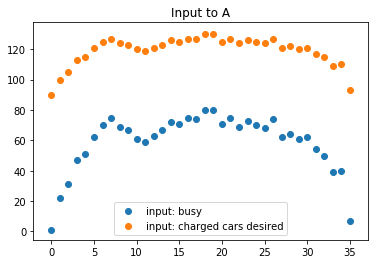

In [1022]:
def plot_A_input(demand_for_A,car_needed_lower_bound,number_charged_cars_needed):
    x=np.arange(len(demand_for_A))
    plt.scatter(x,demand_for_A,label='input: busy')
#     plt.scatter(x,car_needed_lower_bound,label='imperical lower bound for charge cars needed (to check)')
    plt.scatter(x,number_charged_cars_needed,label='input: charged cars desired')
    plt.title('Input to A')
    plt.legend()
    plt.show()
plot_A_input(demand_for_A,car_needed_lower_bound,number_charged_cars_needed)


In [1023]:
df_EVehicleTrejectory_day_agg.loc[df_EVehicleTrejectory_day_agg['travel_time']>1800,'travel_time']=1800
df_EVehicleTrejectory_day_agg['car_needed']=df_EVehicleTrejectory_day_agg['travel_time'].apply(lambda x:x>300)
df_num_busy=df_EVehicleTrejectory_day_agg.groupby(['time_step'])['consumption','travel_time','car_needed'].sum().reset_index()
df_num_busy['busy']=df_num_busy['travel_time'].apply(lambda x:int(x/1800)+1)
df_num_busy['avg_consumption']=df_num_busy['consumption']/df_num_busy['busy']



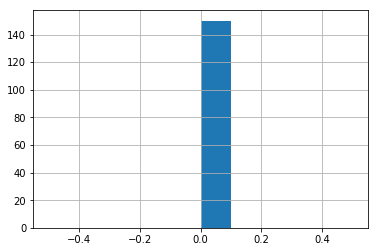

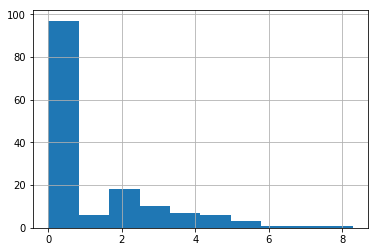

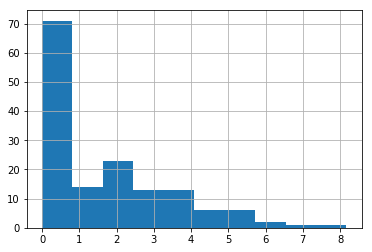

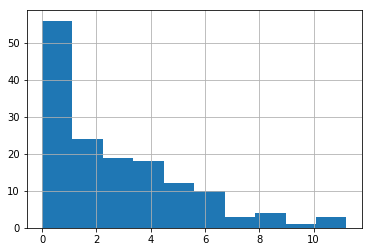

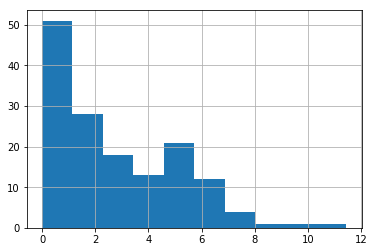

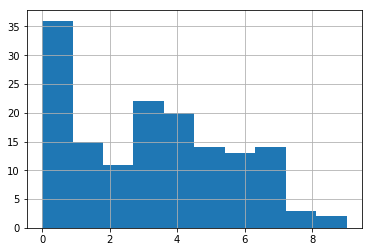

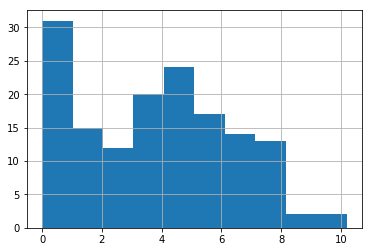

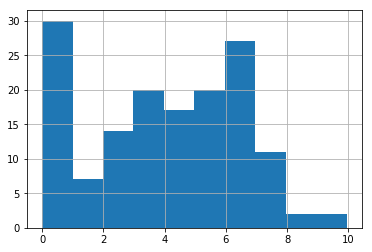

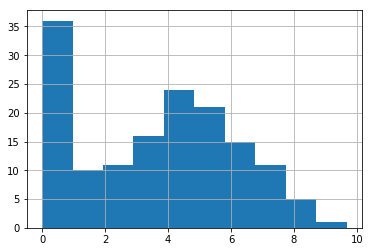

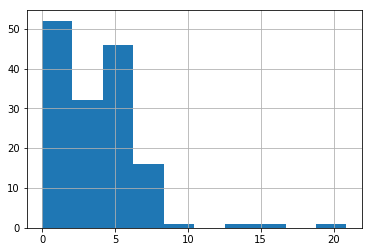

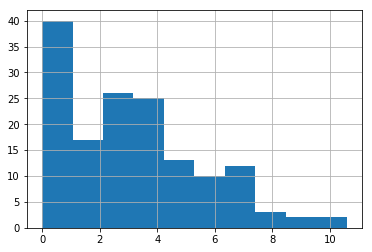

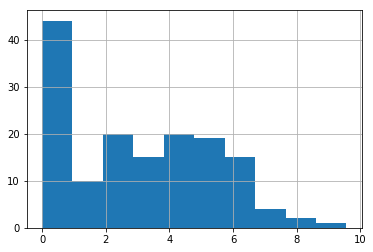

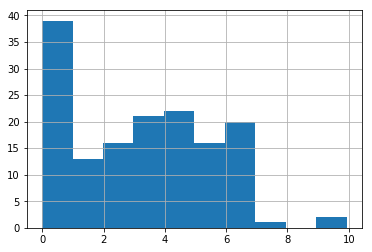

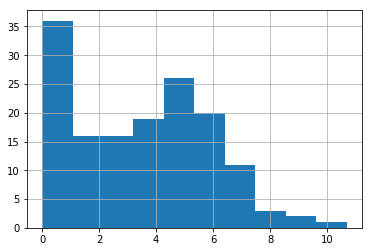

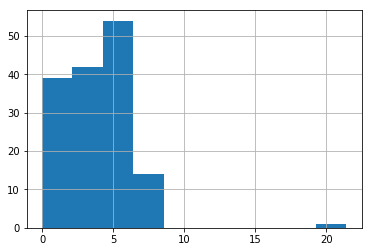

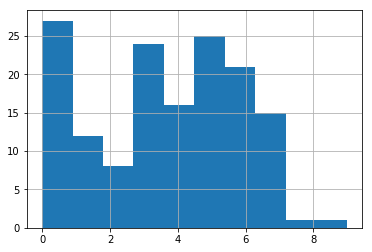

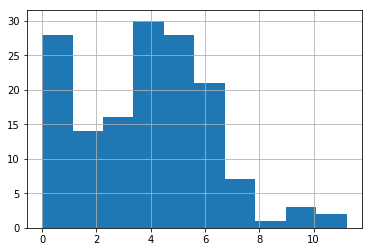

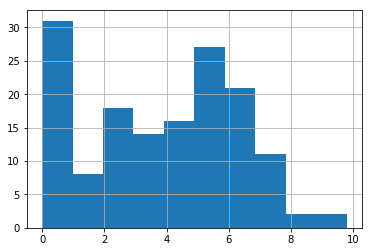

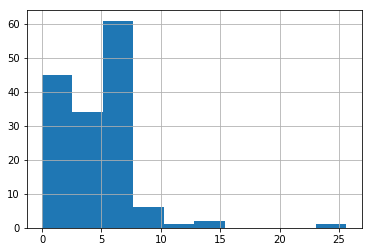

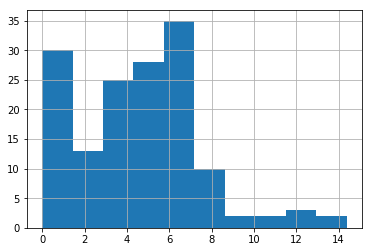

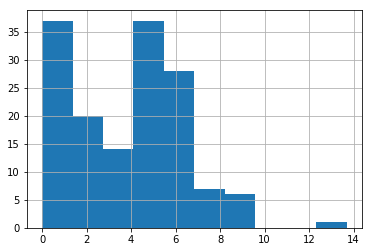

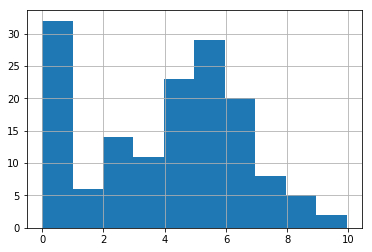

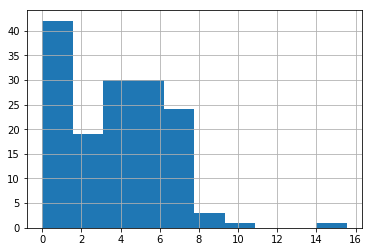

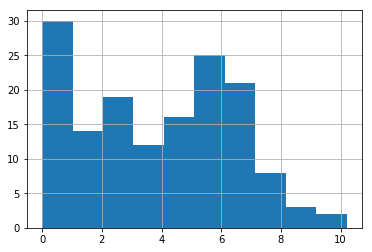

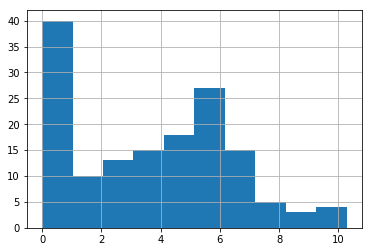

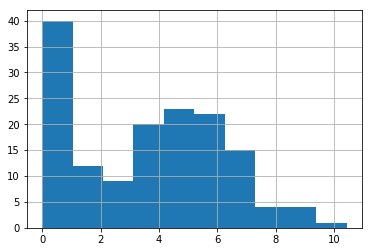

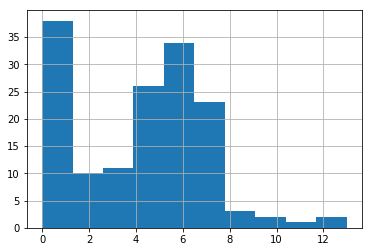

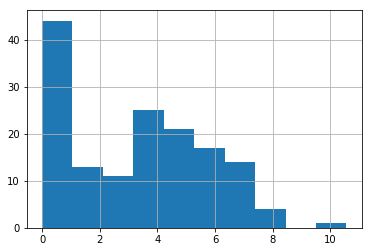

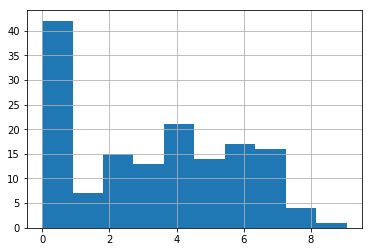

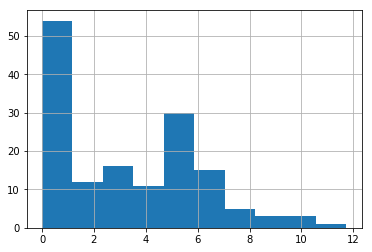

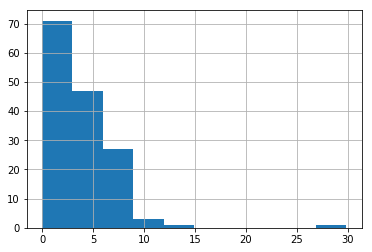

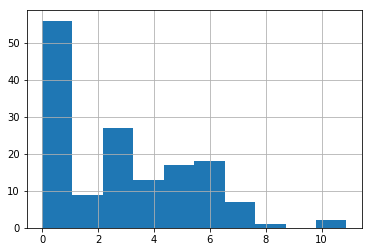

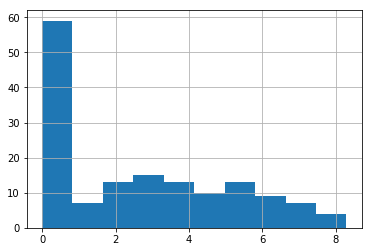

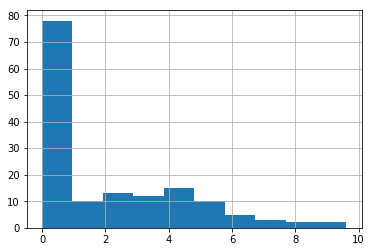

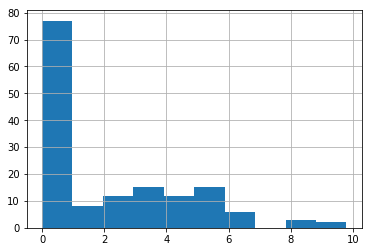

In [1024]:
for t in range(num_of_time_steps):
    print()
    df_EVehicleTrejectory_day_agg[df_EVehicleTrejectory_day_agg['time_step']==t]['consumption'].hist()
    plt.show()

## A

### make problem

In [1025]:
def stage_A_complete__get_A_b(number_of_time_slots, number_of_cars, number_of_chargers, demand_sum_over_zones_,number_charged_cars_needed,
                     decharge_rate, charging_rate, initial_charge,penalty_A
                    ):
    
    battery_1=80
    battery_2=20
#     number_charged_cars_needed=np.minimum((0.9*number_of_cars*np.ones(number_of_time_slots)).astype(int),
#                                           np.apply_along_axis(lambda x:x+0.2*(1-(x/number_of_cars))*number_of_cars,0,
#                                                               demand_sum_over_zones[:number_of_time_slots]).astype(int))
    num_set=number_of_time_slots*number_of_cars
    num_vars=14*num_set+2*number_of_time_slots
    make_x=lambda x: np.zeros([np.shape(x)[0],num_vars])
    
    dictionaty_x={'x_slow':0,'h_slow':1,'x_fast':2,'h_fast':3,'demand':4,
                  'u_slow':5,'u_fast':6,'v':7,'w':8,'q':9,'a_slow':10,'a_fast':11,'b':12 ,'z':13}
    make_range=lambda x:list(range(dictionaty_x[x]*num_set,(dictionaty_x[x]+1)*num_set))
    dictionaty_A_ub={}
    dictionaty_b_ub={}
    
    
    #constraint    #on number of chargers
    Y_from_X_dummy_t_by_t=np.tril(np.ones(([number_of_time_slots,number_of_time_slots])))
    Y_from_X=np.zeros([num_set,num_set])
    SUM_over_Y=np.zeros([number_of_time_slots,num_set])
    Y_from_h_dummy_t_by_t=np.eye(number_of_time_slots,number_of_time_slots)
    Y_from_h=np.zeros([num_set,num_set])
    for i in range(number_of_cars):
        ii=i*number_of_time_slots
        Y_from_X[ii:ii+number_of_time_slots,ii:ii+number_of_time_slots]=Y_from_X_dummy_t_by_t
    for i in range(number_of_cars):
        ii=i*number_of_time_slots
        Y_from_h[ii:ii+number_of_time_slots,ii:ii+number_of_time_slots]=Y_from_h_dummy_t_by_t
    for i in range(number_of_cars):
        ii=i*number_of_time_slots
        SUM_over_Y[:,ii:ii+number_of_time_slots]=np.eye(number_of_time_slots)

    Y_from_x_h = np.append(Y_from_X,-1*Y_from_X,1)         
    
    sparse_Y_from_x_h=csr_matrix(Y_from_x_h)
    sparse_SUM_over_Y=csr_matrix(SUM_over_Y)
    sparse_A_ub=sparse_SUM_over_Y.dot(sparse_Y_from_x_h)
    A_ub=make_x(sparse_A_ub)
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=sparse_A_ub.todense()
    b_ub=number_of_chargers[0]*np.ones(number_of_time_slots)
    dictionaty_A_ub['slow_charger_capacity']=csr_matrix(A_ub)
    dictionaty_b_ub['slow_charger_capacity']=b_ub
    
    A_ub=make_x(sparse_A_ub)
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=sparse_A_ub.todense()
    b_ub=number_of_chargers[1]*np.ones(number_of_time_slots)
    dictionaty_A_ub['fast_charger_capacity']=csr_matrix(A_ub)
    dictionaty_b_ub['fast_charger_capacity']=b_ub
    del SUM_over_Y,Y_from_X_dummy_t_by_t,Y_from_X,Y_from_h,Y_from_h_dummy_t_by_t,A_ub,sparse_A_ub

    

    

    #constraint    #battery capacity

    lower_bound_80=np.minimum(initial_charge,battery_1)
    upper_bound_80=battery_1-np.minimum(initial_charge,battery_1)
    lower_bound_20=np.maximum(initial_charge-battery_1,0)
    upper_bound_20=battery_2-np.maximum(initial_charge-battery_1,0)
    Acc_dummy=np.tril(np.ones([number_of_time_slots,number_of_time_slots]))
    Acc=np.zeros([num_set,num_set])
                        
    for i in range(number_of_cars):     
        ii=i*number_of_time_slots
        Acc[ii:ii+number_of_time_slots,ii:ii+number_of_time_slots]=Acc_dummy
        
    A_ub=make_x(Acc)
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=csr_matrix(charging_rate[0]*Acc).dot(sparse_Y_from_x_h).todense()
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=csr_matrix(charging_rate[2]*Acc).dot(sparse_Y_from_x_h).todense()
    A_ub[:,make_range('u_slow')]=-1*Acc
    A_ub[:,make_range('u_fast')]=-1*Acc
    A_ub[:,make_range('v')]=-1*Acc

    b_ub=upper_bound_80
    dictionaty_A_ub['battery_80_roof']=csr_matrix(A_ub)
    dictionaty_b_ub['battery_80_roof']=b_ub 
    b_ub=lower_bound_80
    dictionaty_A_ub['battery_80_floor']=csr_matrix(-1*A_ub)
    dictionaty_b_ub['battery_80_floor']=b_ub 

    A_ub=make_x(Acc)
    A_ub[:,make_range('demand')]=-1*decharge_rate*Acc
    A_ub[:,make_range('u_slow')]=(charging_rate[1]/charging_rate[0])*Acc
    A_ub[:,make_range('u_fast')]=(charging_rate[3]/charging_rate[2])*Acc
    A_ub[:,make_range('v')]=Acc
    A_ub[:,make_range('w')]=-1*Acc

    b_ub=upper_bound_20
    dictionaty_A_ub['battery_20_roof']=csr_matrix(A_ub)
    dictionaty_b_ub['battery_20_roof']=b_ub     
    b_ub=lower_bound_20
    dictionaty_A_ub['battery_20_floor']=csr_matrix(-1*A_ub)
    dictionaty_b_ub['battery_20_floor']=b_ub     

    
    #constraint on axillary variables related to battery
 
    #on u and v against a and b
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('w')]=np.eye(num_set)
    A_ub[:,make_range('u_slow')]=-1*(charging_rate[1]/charging_rate[0])*np.eye(num_set)
    A_ub[:,make_range('u_fast')]=-1*(charging_rate[3]/charging_rate[2])*np.eye(num_set)
    A_ub=0.01*A_ub
    #A_ub[:,make_range('v')]=np.eye(num_set)
    A_ub[:,make_range('b')]=np.eye(num_set)
    b_ub=np.ones([num_set])-0.01*np.maximum(initial_charge-battery_1,0)
    A_ub=A_ub+0.01*(dictionaty_A_ub['battery_20_roof'].todense())    
        
    dictionaty_A_ub['v_b_1']=csr_matrix(A_ub)
    dictionaty_b_ub['v_b_1']=b_ub  
    
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('v')]=np.eye(num_set)
    A_ub[:,make_range('b')]=-battery_1*np.eye(num_set)
    b_ub=np.zeros([num_set])  
        
    dictionaty_A_ub['v_b_2']=csr_matrix(A_ub)
    dictionaty_b_ub['v_b_2']=b_ub 
  
    A_ub=make_x(np.eye(num_set))    
    A_ub[:,make_range('v')]=np.eye(num_set)
    #A_ub[:,make_range('u_slow')]=np.eye(num_set)
    A_ub[:,make_range('u_fast')]=np.eye(num_set)
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=-1*charging_rate[2]*sparse_Y_from_x_h.todense()
    A_ub=A_ub+dictionaty_A_ub['battery_80_roof'].todense()
    A_ub=A_ub*-1    
    #A_ub[:,make_range('u_slow')]=np.eye(num_set)
    A_ub[:,make_range('a_slow')]=(battery_1)*np.eye(num_set)
               
    b_ub=np.minimum(initial_charge,battery_1)
    dictionaty_A_ub['u_a_slow_1']=csr_matrix(A_ub)
    dictionaty_b_ub['u_a_slow_1']=b_ub     
   
    A_ub=make_x(np.eye(num_set))    
    A_ub[:,make_range('u_slow')]=np.eye(num_set)
    A_ub[:,make_range('a_slow')]=-charging_rate[0]*np.eye(num_set)
    b_ub=np.zeros([num_set])
    dictionaty_A_ub['u_a_slow_2']=csr_matrix(A_ub)
    dictionaty_b_ub['u_a_slow_2']=b_ub 
    
    
    
    A_ub=make_x(np.eye(num_set))    
    A_ub[:,make_range('v')]=np.eye(num_set)
    #A_ub[:,make_range('u_fast')]=np.eye(num_set)
    A_ub[:,make_range('u_slow')]=np.eye(num_set)
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=-1*charging_rate[0]*sparse_Y_from_x_h.todense()
    A_ub=A_ub+dictionaty_A_ub['battery_80_roof'].todense()
    A_ub=A_ub*-1    
    #A_ub[:,make_range('u_fast')]=np.eye(num_set)
    A_ub[:,make_range('a_fast')]=battery_1*np.eye(num_set)
               
    b_ub=np.zeros([num_set])+np.minimum(initial_charge,battery_1)
    dictionaty_A_ub['u_a_fast_1']=csr_matrix(A_ub)
    dictionaty_b_ub['u_a_fast_1']=b_ub  
    
    
    A_ub=make_x(np.eye(num_set))    
    A_ub[:,make_range('u_fast')]=np.eye(num_set)
    A_ub[:,make_range('a_fast')]=-charging_rate[2]*np.eye(num_set)
    b_ub=np.zeros([num_set])
    dictionaty_A_ub['u_a_fast_2']=csr_matrix(A_ub)
    dictionaty_b_ub['u_a_fast_2']=b_ub                
               
    #on a and b
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('w')]=(-0.01)*np.eye(num_set)
    A_ub[:,make_range('v')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('u_slow')]=(0.01)*(charging_rate[1]/charging_rate[0])*np.eye(num_set)
    A_ub[:,make_range('u_fast')]=(0.01)*(charging_rate[3]/charging_rate[2])*np.eye(num_set)
    A_ub[:,make_range('b')]=-1*np.eye(num_set)

    b_ub=np.zeros([num_set])+np.maximum(initial_charge-battery_1,0)*0.01
    dictionaty_A_ub['b_1']=csr_matrix(A_ub+(-0.01)*(dictionaty_A_ub['battery_20_roof'].todense()))
    dictionaty_b_ub['b_1']=b_ub     
    
    A_ub=make_x(np.eye(num_set))
    dictionaty_A_ub['b_0']=-1*dictionaty_A_ub['b_1']
    b_ub=np.ones([num_set])-(0.01*np.maximum(initial_charge-battery_1,0))
    dictionaty_b_ub['b_0']=b_ub 
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('b')]=np.eye(num_set)
    A_ub[:,make_range('demand')]=-1*np.eye(num_set)
    dictionaty_A_ub['b_0_']=csr_matrix(A_ub)
    b_ub=np.zeros([num_set])
    dictionaty_b_ub['b_0_']=b_ub 
    
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('v')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('u_slow')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('u_fast')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('a_slow')]=-1*np.eye(num_set)
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=-1*(0.01)*charging_rate[2]*sparse_Y_from_x_h.todense()
    
    b_ub=np.zeros([num_set])-(np.minimum(initial_charge,battery_1)-battery_1)*0.01
    dictionaty_A_ub['a_slow_1']=csr_matrix(A_ub+(0.01)*(dictionaty_A_ub['battery_80_roof'].todense()))
    dictionaty_b_ub['a_slow_1']=b_ub     
    
    dictionaty_A_ub['a_slow_0']=-1*dictionaty_A_ub['a_slow_1']
    b_ub=np.ones([num_set])+(np.minimum(initial_charge,battery_1)-battery_1)*0.01
    dictionaty_b_ub['a_slow_0']=b_ub 

    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('a_slow')]=np.eye(num_set)
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=-1*(sparse_Y_from_x_h).todense()        
    dictionaty_A_ub['a_slow_0_']=csr_matrix(A_ub)
    b_ub=np.zeros([num_set])
    dictionaty_b_ub['a_slow_0_']=b_ub 
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('a_fast')]=np.eye(num_set)
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=-1*(sparse_Y_from_x_h).todense()  
    dictionaty_A_ub['a_fast_0_']=csr_matrix(A_ub)
    b_ub=np.zeros([num_set])
    dictionaty_b_ub['a_fast_0_']=b_ub 
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('v')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('u_slow')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('u_fast')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('a_fast')]=-1*np.eye(num_set)
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=-1*(0.01)*charging_rate[0]*sparse_Y_from_x_h.todense()
    
    b_ub=np.zeros([num_set])+(np.minimum(initial_charge,battery_1)-battery_1)*0.01
    dictionaty_A_ub['a_fast_1']=csr_matrix(A_ub+(0.01)*(dictionaty_A_ub['battery_80_roof'].todense()))
    dictionaty_b_ub['a_fast_1']=b_ub     
    
    dictionaty_A_ub['a_fast_0']=-1*dictionaty_A_ub['a_fast_1']
    b_ub=np.ones([num_set])-(np.minimum(initial_charge,battery_1)-battery_1)*0.01
    dictionaty_b_ub['a_fast_0']=b_ub 
    
    
    #constraint    #satisfy demand
    SUM_over_cars_dummy_t_by_t=np.eye(number_of_time_slots,number_of_time_slots)
    SUM_over_cars=np.zeros([number_of_time_slots,num_set])
    for i in range(number_of_cars):
        ii=i*number_of_time_slots
        SUM_over_cars[:,ii:ii+number_of_time_slots]=SUM_over_cars_dummy_t_by_t
    A_ub=make_x(SUM_over_cars)
    A_ub[:,make_range('demand')]=SUM_over_cars
    A_ub[:,-number_of_time_slots:]=-1*np.eye(number_of_time_slots)
    b_ub=demand_sum_over_zones_[0:number_of_time_slots]
    dictionaty_A_ub['demand']=csr_matrix(A_ub)
    dictionaty_b_ub['demand']=b_ub    

        
        
    #constraint    #Y between 0 and 1 
    A_ub=make_x(sparse_Y_from_x_h)
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=(sparse_Y_from_x_h).todense()    
    b_ub=np.ones(num_set)
    dictionaty_A_ub['Y_slow_1']=csr_matrix(A_ub)
    dictionaty_b_ub['Y_slow_1']=b_ub

    A_ub=make_x(sparse_Y_from_x_h)
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=-1*(sparse_Y_from_x_h).todense()    
    b_ub=np.zeros(num_set)
    dictionaty_A_ub['Y_slow_0']=csr_matrix(A_ub)
    dictionaty_b_ub['Y_slow_0']=b_ub

    A_ub=make_x(sparse_Y_from_x_h)
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=(sparse_Y_from_x_h).todense()    
    b_ub=np.ones(num_set)
    dictionaty_A_ub['Y_fast_1']=csr_matrix(A_ub)
    dictionaty_b_ub['Y_fast_1']=b_ub

    A_ub=make_x(sparse_Y_from_x_h)
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=-1*(sparse_Y_from_x_h).todense()    
    b_ub=np.zeros(num_set)
    dictionaty_A_ub['Y_fast_0']=csr_matrix(A_ub)
    dictionaty_b_ub['Y_fast_0']=b_ub


    #constrain    #cars in charge cannot be assigned to demand
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=(sparse_Y_from_x_h).todense()
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=(sparse_Y_from_x_h).todense()
    A_ub[:,make_range('demand')]=np.eye(num_set)
    b_ub=np.ones(num_set)
    dictionaty_A_ub['car_occupied']=csr_matrix(A_ub)
    dictionaty_b_ub['car_occupied']=b_ub
    
    

    #constraint    #number of charged cars
    SUM_over_cars_dummy_t_by_t=np.eye(number_of_time_slots,number_of_time_slots)
    SUM_over_cars=np.zeros([number_of_time_slots,num_set])
    for i in range(number_of_cars):
        ii=i*number_of_time_slots
        SUM_over_cars[:,ii:ii+number_of_time_slots]=SUM_over_cars_dummy_t_by_t
    A_ub=make_x(SUM_over_cars)
    A_ub[:,make_range('q')]=-1*SUM_over_cars
    A_ub[:,-2*number_of_time_slots:-number_of_time_slots]=-1*np.eye(number_of_time_slots)
    b_ub=-1*number_charged_cars_needed[0:number_of_time_slots]
    A_ub=A_ub+dictionaty_A_ub['fast_charger_capacity']+dictionaty_A_ub['slow_charger_capacity']
    dictionaty_A_ub['charged_cars']=csr_matrix(A_ub)
    dictionaty_b_ub['charged_cars']=b_ub       
    
    A_ub=make_x(np.eye(num_set))

    A_ub[:,make_range('q')]=-1*np.eye(num_set)
    
    b_ub=0.2*np.ones([num_set])-np.minimum(initial_charge,battery_1)*0.01
    dictionaty_A_ub['q_1']=csr_matrix(A_ub+(0.01)*dictionaty_A_ub['battery_80_roof'].todense())
    dictionaty_b_ub['q_1']=b_ub     
    
    dictionaty_A_ub['q_0']=-1*dictionaty_A_ub['q_1']
    b_ub=0.8*np.ones([num_set])+np.minimum(initial_charge,battery_1)*0.01
    dictionaty_b_ub['q_0']=b_ub     
    

    #constraint to have good looking solutions
    
    #cant go ro charger while above 80
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=(sparse_Y_from_x_h).todense()
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=(sparse_Y_from_x_h).todense()
    A_ub[:,make_range('x_slow')]=+np.eye(num_set)
    A_ub[:,make_range('x_fast')]=+np.eye(num_set)
    A_ub[:,make_range('z')]=np.eye(num_set)
    b_ub=2*np.ones(num_set)
    dictionaty_A_ub['go_to_charge_SoC_below_z']=csr_matrix(A_ub)
    dictionaty_b_ub['go_to_charge_SoC_below_z']=b_ub
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('z')]=-1*np.eye(num_set)
    b_ub=0.8*np.ones([num_set])-initial_charge*0.01
    dictionaty_A_ub['z_1']=csr_matrix(A_ub+(0.01)*(dictionaty_A_ub['battery_80_roof'].todense()+dictionaty_A_ub['battery_20_roof'].todense()))
    dictionaty_b_ub['z_1']=b_ub     
    dictionaty_A_ub['z_0']=-1*dictionaty_A_ub['z_1']
    b_ub=0.2*np.ones([num_set])+np.minimum(initial_charge,battery_1)*0.01
    dictionaty_b_ub['z_0']=b_ub     
    
    
    #variationin in charger utilization in successive times steps 
    A_ub=dictionaty_A_ub['slow_charger_capacity']
    b_ub=round(number_of_chargers[0]*0.3+0.5)*np.ones(number_of_time_slots)
    
    diff=np.eye(number_of_time_slots)-np.concatenate([np.zeros([number_of_time_slots,1]),
                                                      np.concatenate([np.eye(number_of_time_slots-1),
                                                      np.zeros([1,number_of_time_slots-1])],0) ],1)
    diff[-1,-1]=0
    A_ub=csr_matrix(diff).dot(A_ub)
    dictionaty_A_ub['change_in_chargers_usage_1']=A_ub
    dictionaty_b_ub['change_in_chargers_usage_1']=b_ub
    
    A_ub=-1*dictionaty_A_ub['change_in_chargers_usage_1']
    b_ub=round(number_of_chargers[0]*0.3+0.5)*np.ones(number_of_time_slots)

    dictionaty_A_ub['change_in_chargers_usage_2']=csr_matrix(A_ub)
    dictionaty_b_ub['change_in_chargers_usage_2']=b_ub
    
    #max sum of x per vehicle
    sum_over_time=np.zeros([number_of_cars,num_set])
    for i in range(number_of_cars):
        sum_over_time[i,(i*number_of_time_slots):(i+1)*number_of_time_slots]=1
    A_ub=make_x(sum_over_time)
    A_ub[:,make_range('x_slow')]=sum_over_time
    A_ub[:,make_range('x_fast')]=sum_over_time
    
    b_ub=10*np.ones(number_of_cars)
    dictionaty_A_ub['total_go_to_charge']=csr_matrix(A_ub)
    dictionaty_b_ub['total_go_to_charge']=b_ub
    
    
#     #constraints for symmetry breaking
#     sum_over_time=np.zeros([number_of_cars,num_set])
#     for i in range(number_of_cars):
#         sum_over_time[i,(i*number_of_time_slots):int((i+0.5)*number_of_time_slots)]=np.arange(1,int(0.5*number_of_time_slots)+1)
#     A_ub=make_x(sum_over_time)
#     A_ub[:,make_range('demand')]=sum_over_time
#     diff=np.eye(number_of_cars)-np.concatenate([np.zeros([number_of_cars,1]),np.concatenate([1*np.eye(number_of_cars-1),np.zeros([1,number_of_cars-1])],0)
#                                                   ],1)
#     diff[-1,-1]=0
#     b_ub=np.zeros(number_of_cars)
#     dictionaty_A_ub['symmetry']=csr_matrix(diff).dot(csr_matrix(A_ub))
#     dictionaty_b_ub['symmetry']=b_ub    
    
    #with demand in objective function 
    #combining constraints 
#     print([type(i) for i in list(dictionaty_A_ub.values())])
    A_ub=vstack(list(dictionaty_A_ub.values()))
    b_ub=np.concatenate(list(dictionaty_b_ub.values()),0)

    c=make_x(np.zeros([1,1]))
    c[:,make_range('x_slow')]=penalty_A['go_to_charge_slow']
    c[:,make_range('x_fast')]=penalty_A['go_to_charge_fast']
    c[:,make_range('demand')]=-1*penalty_A['busy']
    c[:,-2*number_of_time_slots:-number_of_time_slots]=penalty_A['charged']
    c[:,-1*number_of_time_slots:]=penalty_A['busy']
    
    
    E_price_numset=np.tile(penalty_A['E_price'],number_of_cars)
#     concatenate([np.tile(E_price,number_of_cars*13),np.zeros([2*number_of_time_slots])],0)    
    
    c_E_1=make_x(np.zeros([1,1]))
    c_E_2=make_x(np.zeros([1,1]))
    c_E_1[:,make_range('u_slow')]=(-1+(charging_rate[1]/charging_rate[0]))*np.ones([num_set])*E_price_numset
    c_E_1[:,make_range('u_fast')]=(-1+(charging_rate[3]/charging_rate[2]))*np.ones([num_set])*E_price_numset    
    c_E_2[:,make_range('x_slow')+make_range('h_slow')]=np.sum(np.multiply((charging_rate[0]*(sparse_Y_from_x_h).todense() ) , E_price_numset[:, np.newaxis]),0)
    c_E_2[:,make_range('x_fast')+make_range('h_fast')]=np.sum(np.multiply((charging_rate[2]*(sparse_Y_from_x_h).todense() ) , E_price_numset[:, np.newaxis]),0)  
    
    c=c+(c_E_1+c_E_2)
    c=c.flatten()
    S_ub = coo_matrix(A_ub).tocsr()
    S_eq=[]
    b_eq=[]

    return S_ub, b_ub, S_eq, b_eq, c, sparse_Y_from_x_h, dictionaty_A_ub, dictionaty_b_ub, 



#### complete

#### pricing

In [1326]:
def stage_A_pricing_problem__get_A_b(number_of_time_slots, decharge_rate, charging_rate, initial_charge,penalty_A, dual_vars,LB ):
    number_of_cars=1
    battery_1=80
    battery_2=20
    
    dual_vars=np.array(dual_vars)
    num_set=number_of_time_slots*number_of_cars
    num_vars=14*num_set
    make_x=lambda x: np.zeros([np.shape(x)[0],num_vars])
    
    dictionaty_x={'x_slow':0,'h_slow':1,'x_fast':2,'h_fast':3,'demand':4,
                  'u_slow':5,'u_fast':6,'v':7,'w':8,'q':9,'a_slow':10,'a_fast':11,'b':12 ,'z':13}
    
    dictionaty_dual_input={'Y_slow':0, 'Y_fast':1,'demand':2, 'q':3}
    dictionaty_dual_output={'x_slow':0,'h_slow':1,'x_fast':2,'h_fast':3,'demand':4, 'q':5}
        
        
    make_range=lambda x:list(range(dictionaty_x[x]*num_set,(dictionaty_x[x]+1)*num_set))
    make_range_dual_input=lambda x:list(range(dictionaty_dual_input[x]*num_set,(dictionaty_dual_input[x]+1)*num_set))
    make_range_dual_output=lambda x:list(range(dictionaty_dual_output[x]*num_set,(dictionaty_dual_output[x]+1)*num_set))
    dictionaty_A_ub={}
    dictionaty_b_ub={}
    
    
    #constraint    #on number of chargers
    Y_from_X_dummy_t_by_t=np.tril(np.ones(([number_of_time_slots,number_of_time_slots])))
    Y_from_X=np.zeros([num_set,num_set])
    SUM_over_Y=np.zeros([number_of_time_slots,num_set])
    Y_from_h_dummy_t_by_t=np.eye(number_of_time_slots,number_of_time_slots)
    Y_from_h=np.zeros([num_set,num_set])
    for i in range(number_of_cars):
        ii=i*number_of_time_slots
        Y_from_X[ii:ii+number_of_time_slots,ii:ii+number_of_time_slots]=Y_from_X_dummy_t_by_t
    for i in range(number_of_cars):
        ii=i*number_of_time_slots
        Y_from_h[ii:ii+number_of_time_slots,ii:ii+number_of_time_slots]=Y_from_h_dummy_t_by_t
    for i in range(number_of_cars):
        ii=i*number_of_time_slots
        SUM_over_Y[:,ii:ii+number_of_time_slots]=np.eye(number_of_time_slots)

    Y_from_x_h = np.append(Y_from_X,-1*Y_from_X,1)         
    
    sparse_Y_from_x_h=csr_matrix(Y_from_x_h)
#     del SUM_over_Y,Y_from_X_dummy_t_by_t,Y_from_X,Y_from_h,Y_from_h_dummy_t_by_t,A_ub,sparse_A_ub

    

    dual_vars_=np.zeros([6*num_set])
    dual_vars_y=dual_vars[make_range_dual_input('Y_slow')]
    dual_vars_[make_range_dual_output('x_slow')+
               make_range_dual_output('h_slow')]=np.sum(np.multiply(dual_vars_y[:,
                                                            np.newaxis],Y_from_x_h),0)
    dual_vars_y=dual_vars[make_range_dual_input('Y_fast')]
    dual_vars_[make_range_dual_output('x_fast')+
               make_range_dual_output('h_fast')]=np.sum(np.multiply(dual_vars_y[:,
                                                            np.newaxis],Y_from_x_h),0)

#     dual_vars_y=dual_vars[make_range_dual_input('Y_slow')]
#     print('should be',len(make_range_dual_output('x_slow')+
#                make_range_dual_output('h_slow')))
#     print(np.linalg.lstsq(Y_from_x_h, dual_vars_y)[0])
#     print('it is',len(np.linalg.lstsq(Y_from_x_h, dual_vars_y)[0]))

    

#     dual_vars_[make_range_dual_output('x_slow')+
#                make_range_dual_output('h_slow')]=np.linalg.lstsq(Y_from_x_h, dual_vars_y)[0]

#     dual_vars_y=dual_vars[make_range_dual_input('Y_fast')]
#     dual_vars_[make_range_dual_output('x_fast')+
#                make_range_dual_output('h_fast')]=np.linalg.lstsq(Y_from_x_h, dual_vars_y)[0]
    
    dual_vars_[make_range_dual_output('demand')]=dual_vars[make_range_dual_input('demand')]
    dual_vars_[make_range_dual_output('q')]=dual_vars[make_range_dual_input('q')]
    
    
    #constraint    #battery capacity

    lower_bound_80=np.minimum(initial_charge,battery_1)
    upper_bound_80=battery_1-np.minimum(initial_charge,battery_1)
    lower_bound_20=np.maximum(initial_charge-battery_1,0)
    upper_bound_20=battery_2-np.maximum(initial_charge-battery_1,0)
    Acc_dummy=np.tril(np.ones([number_of_time_slots,number_of_time_slots]))
    Acc=np.zeros([num_set,num_set])
                        
    for i in range(number_of_cars):     
        ii=i*number_of_time_slots
        Acc[ii:ii+number_of_time_slots,ii:ii+number_of_time_slots]=Acc_dummy
        
    A_ub=make_x(Acc)
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=csr_matrix(charging_rate[0]*Acc).dot(sparse_Y_from_x_h).todense()
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=csr_matrix(charging_rate[2]*Acc).dot(sparse_Y_from_x_h).todense()
    A_ub[:,make_range('u_slow')]=-1*Acc
    A_ub[:,make_range('u_fast')]=-1*Acc
    A_ub[:,make_range('v')]=-1*Acc

    b_ub=upper_bound_80
    dictionaty_A_ub['battery_80_roof']=csr_matrix(A_ub)
    dictionaty_b_ub['battery_80_roof']=b_ub 
    b_ub=lower_bound_80
    dictionaty_A_ub['battery_80_floor']=csr_matrix(-1*A_ub)
    dictionaty_b_ub['battery_80_floor']=b_ub 

    A_ub=make_x(Acc)
    A_ub[:,make_range('demand')]=-1*decharge_rate*Acc
    A_ub[:,make_range('u_slow')]=(charging_rate[1]/charging_rate[0])*Acc
    A_ub[:,make_range('u_fast')]=(charging_rate[3]/charging_rate[2])*Acc
    A_ub[:,make_range('v')]=Acc
    A_ub[:,make_range('w')]=-1*Acc

    b_ub=upper_bound_20
    dictionaty_A_ub['battery_20_roof']=csr_matrix(A_ub)
    dictionaty_b_ub['battery_20_roof']=b_ub     
    b_ub=lower_bound_20
    dictionaty_A_ub['battery_20_floor']=csr_matrix(-1*A_ub)
    dictionaty_b_ub['battery_20_floor']=b_ub     

    
    #constraint on axillary variables related to battery
 
    #on u and v against a and b
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('w')]=np.eye(num_set)
    A_ub[:,make_range('u_slow')]=-1*(charging_rate[1]/charging_rate[0])*np.eye(num_set)
    A_ub[:,make_range('u_fast')]=-1*(charging_rate[3]/charging_rate[2])*np.eye(num_set)
    A_ub=0.01*A_ub
    #A_ub[:,make_range('v')]=np.eye(num_set)
    A_ub[:,make_range('b')]=np.eye(num_set)
    b_ub=np.ones([num_set])-0.01*np.maximum(initial_charge-battery_1,0)
    A_ub=A_ub+0.01*(dictionaty_A_ub['battery_20_roof'].todense())    
        
    dictionaty_A_ub['v_b_1']=csr_matrix(A_ub)
    dictionaty_b_ub['v_b_1']=b_ub  
    
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('v')]=np.eye(num_set)
    A_ub[:,make_range('b')]=-battery_1*np.eye(num_set)
    b_ub=np.zeros([num_set])  
        
    dictionaty_A_ub['v_b_2']=csr_matrix(A_ub)
    dictionaty_b_ub['v_b_2']=b_ub 
  
    A_ub=make_x(np.eye(num_set))    
    A_ub[:,make_range('v')]=np.eye(num_set)
    #A_ub[:,make_range('u_slow')]=np.eye(num_set)
    A_ub[:,make_range('u_fast')]=np.eye(num_set)
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=-1*charging_rate[2]*sparse_Y_from_x_h.todense()
    A_ub=A_ub+dictionaty_A_ub['battery_80_roof'].todense()
    A_ub=A_ub*-1    
    #A_ub[:,make_range('u_slow')]=np.eye(num_set)
    A_ub[:,make_range('a_slow')]=(battery_1)*np.eye(num_set)
               
    b_ub=np.minimum(initial_charge,battery_1)
    dictionaty_A_ub['u_a_slow_1']=csr_matrix(A_ub)
    dictionaty_b_ub['u_a_slow_1']=b_ub     
   
    A_ub=make_x(np.eye(num_set))    
    A_ub[:,make_range('u_slow')]=np.eye(num_set)
    A_ub[:,make_range('a_slow')]=-charging_rate[0]*np.eye(num_set)
    b_ub=np.zeros([num_set])
    dictionaty_A_ub['u_a_slow_2']=csr_matrix(A_ub)
    dictionaty_b_ub['u_a_slow_2']=b_ub 
    
    
    
    A_ub=make_x(np.eye(num_set))    
    A_ub[:,make_range('v')]=np.eye(num_set)
    #A_ub[:,make_range('u_fast')]=np.eye(num_set)
    A_ub[:,make_range('u_slow')]=np.eye(num_set)
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=-1*charging_rate[0]*sparse_Y_from_x_h.todense()
    A_ub=A_ub+dictionaty_A_ub['battery_80_roof'].todense()
    A_ub=A_ub*-1    
    #A_ub[:,make_range('u_fast')]=np.eye(num_set)
    A_ub[:,make_range('a_fast')]=battery_1*np.eye(num_set)
               
    b_ub=np.zeros([num_set])+np.minimum(initial_charge,battery_1)
    dictionaty_A_ub['u_a_fast_1']=csr_matrix(A_ub)
    dictionaty_b_ub['u_a_fast_1']=b_ub  
    
    
    A_ub=make_x(np.eye(num_set))    
    A_ub[:,make_range('u_fast')]=np.eye(num_set)
    A_ub[:,make_range('a_fast')]=-charging_rate[2]*np.eye(num_set)
    b_ub=np.zeros([num_set])
    dictionaty_A_ub['u_a_fast_2']=csr_matrix(A_ub)
    dictionaty_b_ub['u_a_fast_2']=b_ub                
               
    #on a and b
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('w')]=(-0.01)*np.eye(num_set)
    A_ub[:,make_range('v')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('u_slow')]=(0.01)*(charging_rate[1]/charging_rate[0])*np.eye(num_set)
    A_ub[:,make_range('u_fast')]=(0.01)*(charging_rate[3]/charging_rate[2])*np.eye(num_set)
    A_ub[:,make_range('b')]=-1*np.eye(num_set)

#     b_ub=np.zeros([num_set])+np.maximum(initial_charge-battery_1,0)*0.01
#     dictionaty_A_ub['b_1']=csr_matrix(A_ub+(-0.01)*(dictionaty_A_ub['battery_20_roof'].todense()))
#     dictionaty_b_ub['b_1']=b_ub     
    
#     A_ub=make_x(np.eye(num_set))
#     dictionaty_A_ub['b_0']=-1*dictionaty_A_ub['b_1']
#     b_ub=np.ones([num_set])-(0.01*np.maximum(initial_charge-battery_1,0))
#     dictionaty_b_ub['b_0']=b_ub 
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('b')]=np.eye(num_set)
    A_ub[:,make_range('demand')]=-1*np.eye(num_set)
    dictionaty_A_ub['b_0_']=csr_matrix(A_ub)
    b_ub=np.zeros([num_set])
    dictionaty_b_ub['b_0_']=b_ub 
    
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('v')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('u_slow')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('u_fast')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('a_slow')]=-1*np.eye(num_set)
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=-1*(0.01)*charging_rate[2]*sparse_Y_from_x_h.todense()
    
#     b_ub=np.zeros([num_set])-(np.minimum(initial_charge,battery_1)-battery_1)*0.01
#     dictionaty_A_ub['a_slow_1']=csr_matrix(A_ub+(0.01)*(dictionaty_A_ub['battery_80_roof'].todense()))
#     dictionaty_b_ub['a_slow_1']=b_ub     
    
    dictionaty_A_ub['a_slow_0']=-1*csr_matrix(A_ub+(0.01)*(dictionaty_A_ub['battery_80_roof'].todense()))
    b_ub=np.ones([num_set])+(np.minimum(initial_charge,battery_1)-battery_1)*0.01
    dictionaty_b_ub['a_slow_0']=b_ub 

    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('a_slow')]=np.eye(num_set)
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=-1*(sparse_Y_from_x_h).todense()        
    dictionaty_A_ub['a_slow_0_']=csr_matrix(A_ub)
    b_ub=np.zeros([num_set])
    dictionaty_b_ub['a_slow_0_']=b_ub 
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('a_fast')]=np.eye(num_set)
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=-1*(sparse_Y_from_x_h).todense()  
    dictionaty_A_ub['a_fast_0_']=csr_matrix(A_ub)
    b_ub=np.zeros([num_set])
    dictionaty_b_ub['a_fast_0_']=b_ub 
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('v')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('u_slow')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('u_fast')]=(0.01)*np.eye(num_set)
    A_ub[:,make_range('a_fast')]=-1*np.eye(num_set)
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=-1*(0.01)*charging_rate[0]*sparse_Y_from_x_h.todense()
    
#     b_ub=np.zeros([num_set])+(np.minimum(initial_charge,battery_1)-battery_1)*0.01
#     dictionaty_A_ub['a_fast_1']=csr_matrix(A_ub+(0.01)*(dictionaty_A_ub['battery_80_roof'].todense()))
#     dictionaty_b_ub['a_fast_1']=b_ub     
    
    dictionaty_A_ub['a_fast_0']=-1*csr_matrix(A_ub+(0.01)*(dictionaty_A_ub['battery_80_roof'].todense()))
    b_ub=np.ones([num_set])-(np.minimum(initial_charge,battery_1)-battery_1)*0.01
    dictionaty_b_ub['a_fast_0']=b_ub    

        
        
    #constraint    #Y between 0 and 1 
    A_ub=make_x(sparse_Y_from_x_h)
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=(sparse_Y_from_x_h).todense()    
    b_ub=np.ones(num_set)
    dictionaty_A_ub['Y_slow_1']=csr_matrix(A_ub)
    dictionaty_b_ub['Y_slow_1']=b_ub

    A_ub=make_x(sparse_Y_from_x_h)
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=-1*(sparse_Y_from_x_h).todense()    
    b_ub=np.zeros(num_set)
    dictionaty_A_ub['Y_slow_0']=csr_matrix(A_ub)
    dictionaty_b_ub['Y_slow_0']=b_ub

    A_ub=make_x(sparse_Y_from_x_h)
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=(sparse_Y_from_x_h).todense()    
    b_ub=np.ones(num_set)
    dictionaty_A_ub['Y_fast_1']=csr_matrix(A_ub)
    dictionaty_b_ub['Y_fast_1']=b_ub

    A_ub=make_x(sparse_Y_from_x_h)
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=-1*(sparse_Y_from_x_h).todense()    
    b_ub=np.zeros(num_set)
    dictionaty_A_ub['Y_fast_0']=csr_matrix(A_ub)
    dictionaty_b_ub['Y_fast_0']=b_ub


    #constrain    #cars in charge cannot be assigned to demand
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=(sparse_Y_from_x_h).todense()
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=(sparse_Y_from_x_h).todense()
    A_ub[:,make_range('demand')]=np.eye(num_set)
    b_ub=np.ones(num_set)
    dictionaty_A_ub['car_occupied']=csr_matrix(A_ub)
    dictionaty_b_ub['car_occupied']=b_ub
    
    

    #constraint    #number of charged cars     
    A_ub=make_x(np.eye(num_set))

    A_ub[:,make_range('q')]=-1*np.eye(num_set)
    
    b_ub=0.2*np.ones([num_set])-np.minimum(initial_charge,battery_1)*0.01
    dictionaty_A_ub['q_1']=csr_matrix(A_ub+(0.01)*dictionaty_A_ub['battery_80_roof'].todense())
    dictionaty_b_ub['q_1']=b_ub     
    
    dictionaty_A_ub['q_0']=-1*dictionaty_A_ub['q_1']
    b_ub=0.8*np.ones([num_set])+np.minimum(initial_charge,battery_1)*0.01
    dictionaty_b_ub['q_0']=b_ub     
    

    #constraint to have good looking solutions
    
    #cant go ro charger while above 80
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('x_slow')+make_range('h_slow')]=(sparse_Y_from_x_h).todense()
    A_ub[:,make_range('x_fast')+make_range('h_fast')]=(sparse_Y_from_x_h).todense()
    A_ub[:,make_range('x_slow')]+=np.eye(num_set)
    A_ub[:,make_range('x_fast')]+=np.eye(num_set)
    A_ub[:,make_range('z')]=np.eye(num_set)
    b_ub=2*np.ones(num_set)
    dictionaty_A_ub['go_to_charge_SoC_below_z']=csr_matrix(A_ub)
    dictionaty_b_ub['go_to_charge_SoC_below_z']=b_ub
    
    A_ub=make_x(np.eye(num_set))
    A_ub[:,make_range('z')]=-1*np.eye(num_set)
    b_ub=0.8*np.ones([num_set])-initial_charge*0.01
    dictionaty_A_ub['z_1']=csr_matrix(A_ub+(0.01)*(dictionaty_A_ub['battery_80_roof'].todense()+dictionaty_A_ub['battery_20_roof'].todense()))
    dictionaty_b_ub['z_1']=b_ub     
    dictionaty_A_ub['z_0']=-1*dictionaty_A_ub['z_1']
    b_ub=0.2*np.ones([num_set])+np.minimum(initial_charge,battery_1)*0.01
    dictionaty_b_ub['z_0']=b_ub     
    

    #max sum of x per vehicle
    sum_over_time=np.zeros([number_of_cars,num_set])
    for i in range(number_of_cars):
        sum_over_time[i,(i*number_of_time_slots):(i+1)*number_of_time_slots]=1
    A_ub=make_x(sum_over_time)
    A_ub[:,make_range('x_slow')]=sum_over_time
    A_ub[:,make_range('x_fast')]=sum_over_time
    
    b_ub=10*np.ones(number_of_cars)
    dictionaty_A_ub['total_go_to_charge']=csr_matrix(A_ub)
    dictionaty_b_ub['total_go_to_charge']=b_ub
    
       
    #build cost coeficients 
    
    c=make_x(np.zeros([1,1]))
    c[:,make_range('x_slow')]=penalty_A['go_to_charge_slow']
    c[:,make_range('x_fast')]=penalty_A['go_to_charge_fast']
    c[:,make_range('demand')]=-1*penalty_A['busy']
#     c[:,make_range('q')]=-1*penalty_A['charged']

    
    E_price_numset=np.tile(penalty_A['E_price'],number_of_cars)
#     concatenate([np.tile(E_price,number_of_cars*13),np.zeros([2*number_of_time_slots])],0)    
    
    c_E_1=make_x(np.zeros([1,1]))
    c_E_2=make_x(np.zeros([1,1]))
    c_E_1[:,make_range('u_slow')]=(-1+(charging_rate[1]/charging_rate[0]))*np.ones([num_set])*E_price_numset
    c_E_1[:,make_range('u_fast')]=(-1+(charging_rate[3]/charging_rate[2]))*np.ones([num_set])*E_price_numset    
    c_E_2[:,make_range('x_slow')+make_range('h_slow')]=np.sum(np.multiply((charging_rate[0]*(sparse_Y_from_x_h).todense() ) , E_price_numset[:, np.newaxis]),0)
    c_E_2[:,make_range('x_fast')+make_range('h_fast')]=np.sum(np.multiply((charging_rate[2]*(sparse_Y_from_x_h).todense() ) , E_price_numset[:, np.newaxis]),0)  
    
    c=c+(c_E_1+c_E_2)
    
    cost=c[:,make_range('x_slow')+make_range('h_slow')+
                      make_range('x_fast')+make_range('h_fast')+
                      make_range('demand')+make_range('q')]
    cost=cost.flatten()
    
    
#     A_ub=make_x(np.array([0]))
#     A_ub=-1*c
    
#     b_ub=np.array([-1*LB])
#     dictionaty_A_ub['Lower_bound_cut']=csr_matrix(A_ub)
#     dictionaty_b_ub['Lower_bound_cut']=b_ub
    
    
    c[:,make_range('x_slow')+make_range('h_slow')]-=dual_vars_[make_range_dual_output('x_slow')+
                                                              make_range_dual_output('h_slow')]
    c[:,make_range('x_fast')+make_range('h_fast')]-=dual_vars_[make_range_dual_output('x_fast')+
                                                              make_range_dual_output('h_fast')]
    c[:,make_range('demand')]-=dual_vars_[make_range_dual_output('demand')]
    c[:,make_range('q')]+=dual_vars_[make_range_dual_output('q')]
                                     
  

    #combining constraints 
#     print([type(i) for i in list(dictionaty_A_ub.values())])
    A_ub=vstack(list(dictionaty_A_ub.values()))
    b_ub=np.concatenate(list(dictionaty_b_ub.values()),0)
                                     
                                     
    c=c.flatten()
    S_ub = coo_matrix(A_ub).tocsr()
    S_eq=[]
    b_eq=[]

    return S_ub, b_ub, S_eq, b_eq, c, sparse_Y_from_x_h, dictionaty_A_ub, dictionaty_b_ub, cost


#### master

In [1027]:
def stage_A_master_problem__get_A_b(number_of_time_slots, number_of_cars, number_of_chargers, demand_sum_over_zones_,number_charged_cars_needed,
                     penalty_A, columns, columns_cost, dual_LB, dual_UB, dual_penalty):

    
    M=1000

#     number_charged_cars_needed=np.minimum((0.9*number_of_cars*np.ones(number_of_time_slots)).astype(int),
#                                           np.apply_along_axis(lambda x:x+0.2*(1-(x/number_of_cars))*number_of_cars,0,
#                                                               demand_sum_over_zones[:number_of_time_slots]).astype(int))
    k=len(columns_cost)
    num_set=number_of_time_slots
    num_vars=k+number_of_time_slots+1
    make_x=lambda x: np.zeros([np.shape(x)[0],num_vars])
    
    dictionaty_columns={'Y_slow':0, 'Y_fast':1,'demand':2, 'q':3}
    
    make_range=lambda x:list(range(dictionaty_columns[x]*num_set,(dictionaty_columns[x]+1)*num_set))
    dictionaty_A_ub={}
    dictionaty_b_ub={}
    dictionaty_A_eq={}
    dictionaty_b_eq={}
    A_ub=np.zeros([4*number_of_time_slots, num_vars])
    A_ub[:,:k]=columns
    A_ub[make_range('q'),-number_of_time_slots-1:-1]=-1*np.eye(number_of_time_slots)
    A_ub[make_range('q'),:k]*=-1
    dictionaty_A_ub['all']=csr_matrix(A_ub)

    #with demand in objective function 
    #combining constraints 
#     print([type(i) for i in list(dictionaty_A_ub.values())])
    #constraint    #on number of chargers
    b_ub=number_of_chargers[0]*np.ones(number_of_time_slots)
    dictionaty_b_ub['slow_charger_capacity']=b_ub

    b_ub=number_of_chargers[1]*np.ones(number_of_time_slots)
    dictionaty_b_ub['fast_charger_capacity']=b_ub
    
    #constraint    #satisfy demand
    b_ub=demand_sum_over_zones_[0:number_of_time_slots]
    dictionaty_b_ub['demand']=b_ub    


    #constraint    #number of charged cars
    b_ub=-1*number_charged_cars_needed[0:number_of_time_slots]
    dictionaty_b_ub['charged_cars']=b_ub       
    
    
    #constraint    #number of cars
    A_eq=np.zeros([1, num_vars])
    A_eq[0,:k]=1
    A_eq[0,-1]=1
    dictionaty_A_eq['num_cars']=csr_matrix(A_eq)
    dictionaty_b_eq['num_cars']=np.array([number_of_cars])  
    
    
#     #Boxmethod on duals
    A_ub=vstack(list(dictionaty_A_ub.values()))
    b_ub=np.concatenate(list(dictionaty_b_ub.values()),0)  
    
    A_eq=vstack(list(dictionaty_A_eq.values()))
    b_eq=np.concatenate(list(dictionaty_b_eq.values()),0)  
    
#     A_up_rows=np.shape(A_ub)[0]
#     A_up_cols=np.shape(A_ub)[1]
#     y_slak=csr_matrix(np.eye(A_up_rows))
#     y_surplus=csr_matrix(-1*np.eye(A_up_rows))
# #     zero_line=csr_matrix(np.zeros([1,A_up_rows]))
# #     y_slak=vstack([y_slak,zero_line])
# #     y_surplus=vstack([y_surplus,zero_line])
#     A_ub=hstack([A_ub,y_surplus,y_slak])
#     y_penalty=np.zeros([2*A_up_rows,A_up_cols+2*A_up_rows])
#     y_penalty[:,-2*A_up_rows:]=np.eye(2*A_up_rows)
#     A_ub=vstack([A_ub,csr_matrix(y_penalty)])
#     b_ub=np.concatenate([b_ub,dual_penalty],0)
    
    
    

    #constraint to have good looking solutions     
#     #variationin in charger utilization in successive times steps 
#     A_ub=dictionaty_A_ub['slow_charger_capacity']
#     b_ub=round(number_of_chargers[0]*0.3+0.5)*np.ones(number_of_time_slots)
    
#     diff=np.eye(number_of_time_slots)-np.concatenate([np.zeros([number_of_time_slots,1]),
#                                                       np.concatenate([np.eye(number_of_time_slots-1),
#                                                       np.zeros([1,number_of_time_slots-1])],0) ],1)
#     diff[-1,-1]=0
#     A_ub=csr_matrix(diff).dot(A_ub)
#     dictionaty_A_ub['change_in_chargers_usage_1']=A_ub
#     dictionaty_b_ub['change_in_chargers_usage_1']=b_ub
    
#     A_ub=-1*dictionaty_A_ub['change_in_chargers_usage_1']
#     b_ub=round(number_of_chargers[0]*0.3+0.5)*np.ones(number_of_time_slots)

#     dictionaty_A_ub['change_in_chargers_usage_2']=csr_matrix(A_ub)
#     dictionaty_b_ub['change_in_chargers_usage_2']=b_ub
    


    c=make_x(np.zeros([1,1]))
    c[:,:k]=columns_cost
    c[:,-number_of_time_slots-1:-1]=penalty_A['charged']
    
    c[:,-1]=M
    c=c.flatten()
#     c=np.concatenate([c,-1*dual_LB,dual_UB],0)
#     assert np.shape(c)[0]==num_vars+2*A_up_rows, 'cost in master problem does not have the right length'
    S_ub = coo_matrix(A_ub).tocsr()
    S_eq=coo_matrix(A_eq).tocsr()
#     print(A_ub.todense(), '\n', b_ub, '\n', columns)
#     S_eq=[]
#     b_eq=[]
    return S_ub, b_ub, S_eq, b_eq, c



### solve

#### pricing

In [1028]:
def stage_A_pricing__solve_gurobi(S_ub, b_ub, S_eq, b_eq, c, number_of_time_slots, gap, Eps):
    #print(c)
    number_of_cars=1
    dictionaty_x={'x_slow':0,'h_slow':1,'x_fast':2,'h_fast':3,'demand':4,
                  'u_slow':5,'u_fast':6,'v':7,'w':8,'q':9,'a_slow':10,'a_fast':11,'b':12, 'z': 13}

    dictionaty_type={'x_slow':'b','h_slow':'b','x_fast':'b','h_fast':'i','demand':'b',
                  'u_slow':'f','u_fast':'f','v':'f','w':'f','q':'b','a_slow':'b','a_fast':'b','b':'b', 'z':'b'}
    model = gurobipy.Model()
    model.setParam("OutputFlag",0)
    rows_ub, rows_eq, cols = len(b_ub),len(b_eq), len(c)
#     print(rows_ub, rows_eq, cols)
    x_answer=np.zeros([cols])
    x = []
    
    num_set=number_of_time_slots*number_of_cars
    
    for type in list(dictionaty_x.keys()):
        if dictionaty_type[type]=='b':
            for j in range(num_set*dictionaty_x[type],num_set*(dictionaty_x[type]+1)):
                x.append(model.addVar( obj=c[j], vtype=gurobipy.GRB.BINARY))
#                 x[-1].start=start[j]
        elif dictionaty_type[type]=='i':
            for j in range(num_set*dictionaty_x[type],num_set*(dictionaty_x[type]+1)):
                #print(c[j])
                x.append(model.addVar(lb=0, obj=c[j], vtype=gurobipy.GRB.INTEGER))
#                 x[-1].start=start[j]
        else:
            for j in range(num_set*dictionaty_x[type],num_set*(dictionaty_x[type]+1)):
                x.append(model.addVar(lb=0, obj=c[j]))  
#                 x[-1].start=start[j]
    model.update()

    for j in range(cols-2*number_of_time_slots,cols):
        x.append(model.addVar(lb=0, obj=c[j])) 
#         x[-1].start=start[j]
    model.update()


#     print('variables introduced')


    for i in range(rows_ub):
      start = S_ub.indptr[i]
      end   = S_ub.indptr[i+1]
      variables = [x[j] for j in S_ub.indices[start:end]]
      coeff     = S_ub.data[start:end]
      #print(coeff,b_ub[i])
      expr = gurobipy.LinExpr(coeff, variables)
      model.addConstr(lhs=expr, sense=gurobipy.GRB.LESS_EQUAL, rhs=b_ub[i])
    model.update()           

#     print('constraints are written')
    
    model.ModelSense = gurobipy.GRB.MINIMIZE
    #model.setParam("SolutionLimit", 4)
    #model.setParam("MAXINT", 2000)
#     model.setParam("MIPFocus", 3)  
    model.setParam("MIPGap", gap)
#     model.setParam("Symmetry", 2)
#     model.setParam('Method',3)
    model.setParam('Presolve',2)
    model.setParam('Heuristics',0.2)
    model.setParam('Cutoff',Eps)
 
    model.setParam('PoolSolutions',10)
    model.setParam('PoolGap',0.3)
    model.setParam('PoolSearchMode',1)      

    
    model.update()  
    return model

#### master

In [1029]:
def stage_A_master__solve_gurobi(S_ub, b_ub, S_eq, b_eq, c, number_of_time_slots, k, gap):
#     print('master c',c)

    model = gurobipy.Model()
    model.setParam("OutputFlag",0)
    rows_ub, rows_eq, cols = len(b_ub),len(b_eq), len(c)
#     print(rows_ub, rows_eq, cols)
    x_answer=np.zeros([cols])
    x = []

    for j in range(k+number_of_time_slots+1):
        x.append(model.addVar(lb=0, obj=c[j], vtype=gurobipy.GRB.INTEGER)) 
#         x[-1].start=start[j]
    model.update()
    
#     assert k+number_of_time_slots+1==cols,'in box method mode number of variables dont match'

#     for j in range(k+number_of_time_slots+1,cols):
#         x.append(model.addVar(lb=0, obj=c[j]))#, vtype=gurobipy.GRB.INTEGER)) 
# #         x[-1].start=start[j]
#     model.update()

#     print('variables introduced')


    for i in range(rows_ub):
      start = S_ub.indptr[i]
      end   = S_ub.indptr[i+1]
      variables = [x[j] for j in S_ub.indices[start:end]]
      coeff     = S_ub.data[start:end]
      #print(coeff,b_ub[i])
      expr = gurobipy.LinExpr(coeff, variables)
      model.addConstr(lhs=expr, sense=gurobipy.GRB.LESS_EQUAL, rhs=b_ub[i])
    model.update()     
    
    for i in range(rows_eq):
      start = S_eq.indptr[i]
      end   = S_eq.indptr[i+1]
      variables = [x[j] for j in S_eq.indices[start:end]]
      coeff     = S_eq.data[start:end]
      #print(coeff,b_ub[i])
      expr = gurobipy.LinExpr(coeff, variables)
      model.addConstr(lhs=expr, sense=gurobipy.GRB.EQUAL, rhs=b_eq[i])
    model.update() 

#     print('constraints are written')
    
    model.ModelSense = gurobipy.GRB.MINIMIZE
    #model.setParam("SolutionLimit", 4)
    #model.setParam("MAXINT", 2000)
    model.setParam("MIPFocus", 1)  
    model.setParam("MIPGap", gap)
#     model.setParam("Symmetry", 2)
#     model.setParam('Method',3)
    model.setParam('Presolve',2)
#     model.setParam('Heuristics',0.2)
#     model.setParam('NodeMethod',2)
#     model.setParam('ImproveStartGap',0.2)

    
    model.update()  

    return model

#### complete

#### complete

In [1030]:
def stage_A_complete__solve_gurobi(S_ub, b_ub, S_eq, b_eq, c,  number_of_cars, number_of_time_slots, start, gap, timelimit):
    #print(c)
    dictionaty_x={'x_slow':0,'h_slow':1,'x_fast':2,'h_fast':3,'demand':4,
                  'u_slow':5,'u_fast':6,'v':7,'w':8,'q':9,'a_slow':10,'a_fast':11,'b':12, 'z': 13}

    dictionaty_type={'x_slow':'b','h_slow':'b','x_fast':'b','h_fast':'i','demand':'b',
                  'u_slow':'f','u_fast':'f','v':'f','w':'f','q':'b','a_slow':'b','a_fast':'b','b':'b', 'z':'b'}
    model = gurobipy.Model()
#     model.Params.OutputFlag = 0
    rows_ub, rows_eq, cols = len(b_ub),len(b_eq), len(c)
#     print(rows_ub, rows_eq, cols)
    x_answer=np.zeros([cols])
    x = []
    
    num_set=number_of_time_slots*number_of_cars
    
    for type in list(dictionaty_x.keys()):
        if dictionaty_type[type]=='b':
            for j in range(num_set*dictionaty_x[type],num_set*(dictionaty_x[type]+1)):
                x.append(model.addVar( obj=c[j], vtype=gurobipy.GRB.BINARY))
                x[-1].start=start[j]
        elif dictionaty_type[type]=='i':
            for j in range(num_set*dictionaty_x[type],num_set*(dictionaty_x[type]+1)):
                #print(c[j])
                x.append(model.addVar(lb=0, obj=c[j], vtype=gurobipy.GRB.INTEGER))
                x[-1].start=start[j]
        else:
            for j in range(num_set*dictionaty_x[type],num_set*(dictionaty_x[type]+1)):
                x.append(model.addVar(lb=0, obj=c[j]))  
                x[-1].start=start[j]
    model.update()

    for j in range(cols-2*number_of_time_slots,cols):
        x.append(model.addVar(lb=0, obj=c[j])) 
#         x[-1].start=start[j]
    model.update()


#     print('variables introduced')


    for i in range(rows_ub):
      start = S_ub.indptr[i]
      end   = S_ub.indptr[i+1]
      variables = [x[j] for j in S_ub.indices[start:end]]
      coeff     = S_ub.data[start:end]
      #print(coeff,b_ub[i])
      expr = gurobipy.LinExpr(coeff, variables)
      model.addConstr(lhs=expr, sense=gurobipy.GRB.LESS_EQUAL, rhs=b_ub[i])
    model.update()           

#     print('constraints are written')
    
    model.ModelSense = gurobipy.GRB.MINIMIZE
    #model.setParam("SolutionLimit", 4)
    #model.setParam("MAXINT", 2000)
    model.setParam("MIPFocus", 1)  
    model.setParam("MIPGap", gap)
    model.setParam("Symmetry", 2)
#     model.setParam('Method',3)
    model.setParam('Presolve',2)
    model.setParam('TimeLimit',timelimit)
#     model.setParam('Heuristics',0.2)
#     model.setParam('NodeMethod',2)
#     model.setParam('ImproveStartGap',0.2)
      

    
    model.update()  
    
#     print('optimizing')
    model.optimize()
#     print('getting variables')
    if (model.status == gurobipy.GRB.Status.OPTIMAL):
        i=0
        for v in model.getVars():
            x_answer[i]=v.x
            i+=1

        start = time.time()
        return x_answer, 1
    else:
        return [], 0


### CG function

In [1031]:
def solve_A_with_CG(number_of_time_slots, number_of_cars, number_of_chargers, demand_sum_over_zones_,number_charged_cars_needed,
                     decharge_rate, charging_rate, initial_charge,penalty_A,columns,columns_cost):
    
    
    initial_charge_scaler=100
    initial_charge=np.ones([number_of_time_slots])*initial_charge_scaler
    dictionaty_x_pricing={'x_slow':0,'h_slow':1,'x_fast':2,'h_fast':3,'demand':4,
                  'u_slow':5,'u_fast':6,'v':7,'w':8,'q':9,'a_slow':10,'a_fast':11,'b':12, 'z': 13}
    num_set=number_of_time_slots
    make_range_x_pricing=lambda x:list(range(dictionaty_x_pricing[x]*num_set,(dictionaty_x_pricing[x]+1)*num_set))
    LOG = True
    EPS = 0
    master_obj_sequesnce=[]
    master_delta_obj_stop=1   
    last_reduced_cost=-1e5
    performance={}
    performance['subproblem']=[]
    performance['masterproblem']=[]
    
    """
    
    """

    # generate initial patterns with one size for each item width!!!!!how? with normal A
#     columns=[]
#     columns_cost=[]
      
#     if LOG:

    iteration = 0
    k = np.shape(columns_cost)[0]
    
    columns_non_basic_count=[0]*k
#     dual_UB=np.zeros([4*number_of_time_slots])
#     dual_LB=np.concatenate([2*np.ones([number_of_time_slots]),20*np.ones([number_of_time_slots]),
#                             20*np.ones([number_of_time_slots]),1*np.ones([number_of_time_slots])])
#     dual_LB=-1*dual_LB
#     dual_penalty=10000*np.ones([4*number_of_time_slots])
    
    
    dual_UB=None
    dual_LB=None
    dual_LB=None
    dual_penalty=None
    S_ub, b_ub, S_eq, b_eq, c= stage_A_master_problem__get_A_b(number_of_time_slots, number_of_cars, 
                                                               number_of_chargers, demand_sum_over_zones_,number_charged_cars_needed,
                                                               penalty_A, columns, columns_cost, dual_LB, dual_UB, dual_penalty)

    master=stage_A_master__solve_gurobi(S_ub, b_ub, S_eq, b_eq, c, number_of_time_slots, k, 0.02)  
    

    while 1:
#         print('k',k,'columns',np.shape(columns),'columns_cost',np.shape(columns_cost))
        assert np.shape(columns)[1]==k, 'k is not equal number of columns'+'iter:'+str(iteration)
        
#         if iteration%1==0:
#             print('iteraron:',iteration,'    k:',k)
#             print('master_obj',master_obj_sequesnce)
#             print('dual_LB',dual_LB)
#             print('dual_UB',dual_UB)
#             print('dual_penalty',dual_penalty)
#             print('dual_vars',dual_vars)
        relax = master.relax()
        relax.Params.OutputFlag = 0
        start=time.time()
        relax.optimize()
#         print('best column',np.min(columns_cost))
#         relax_answer=[]
#         for v in relax.getVars():
#             relax_answer+=[v.x]
#         print('answer_of_relax',sum(relax_answer[:k]),relax_answer[-1])
        end=time.time()
        performance['masterproblem']+=[end-start]
#         print('status relas',relax.Status)
        master_obj_sequesnce+=[relax.ObjVal]
        if len(master_obj_sequesnce)>15:
            master_obj_sequesnce.pop(0)
#             master_obj_sequesnce=
#             master_obj_sequesnce=master_obj_sequesnce[master_obj_sequesnce>-50000]
            if (np.mean(np.array(master_obj_sequesnce)[:5])-np.mean(np.array(master_obj_sequesnce)[-5:]))< abs(min(master_obj_sequesnce))*0.002:
#                 print(master_obj_sequesnce,(master_obj_sequesnce[0]-master_obj_sequesnce[9]),master_delta_obj_stop)
#                 print('master objective did not change')
                break
        dual_vars = np.array([c.Pi for c in relax.getConstrs()]) # keep dual variables
        dual_vars =dual_vars[:4*number_of_time_slots]
#         print(dual_vars)
#         dual_box_width=dual_vars-dual_LB
# #         assert np.min(dual_box_width)>=0, 'dual upper bound is not higher than lower bound'
#         dual_box_width=dual_box_width+10*np.greater_equal(0,dual_box_width)
# #         dual_reached_UB=np.greater_equal(dual_vars,dual_UB)
#         dual_reached_LB=np.greater_equal(dual_LB,dual_vars)
#         dual_reached_bound=dual_reached_LB
#         dual_box_width=dual_box_width-0.2*dual_box_width*(dual_reached_bound==0)
# #         dual_UB=np.minimum(dual_vars+0.5*dual_box_width,0)
#         dual_LB=np.minimum(dual_vars-1*dual_box_width,0)
#         dual_penalty=dual_penalty-0.7*dual_penalty*dual_reached_bound+0.5*dual_penalty*(dual_reached_bound==0)
        
        if iteration==0:
            dual_mat=dual_vars[np.newaxis,:]
        else:
            dual_mat=np.append(dual_mat,dual_vars[np.newaxis,:],0)
        
        m=0
        for v in relax.getVars():
            if m<k:
                if v.x ==0 :
                    columns_non_basic_count[m]+=1

    #                 if k> (number_of_cars/2):
                    if columns_non_basic_count[m] >= 15:
                        columns=np.delete(columns,[m],1)
                        columns_cost=np.delete(columns_cost,[m],0)
                        columns_non_basic_count.pop(m)
                        k=k-1
#                         print('column ',str(m),' deleted')
                else:
                    columns_non_basic_count[m]=0
            m+=1
#         LB=(master_obj_sequesnce[-1]/number_of_cars)+last_reduced_cost
        LB=-1000
        S_ub, b_ub, S_eq, b_eq, c_pricing, sparse_Y_from_x_h, dictionaty_A_ub, dictionaty_b_ub, cost=  stage_A_pricing_problem__get_A_b(number_of_time_slots, decharge_rate, 
                                                                           charging_rate, initial_charge,penalty_A, dual_vars, LB)

        sub_problem =stage_A_pricing__solve_gurobi(S_ub, b_ub, S_eq, b_eq, c_pricing, number_of_time_slots, gap, EPS)
        sub_problem.Params.OutputFlag = 0 # silent mode
        start=time.time()
        sub_problem.optimize()
        end=time.time()
        performance['subproblem']+=[end-start]
#         print(sub_problem.Status)
        
        
        
#         if LOG and iteration%5==0:
#             print ("objective of sub-problem:", sub_problem.ObjVal, 'lowe_bound', LB, 'column cost', columns_cost[-1])
        
        last_reduced_cost=sub_problem.ObjVal

        if sub_problem.Status==6 and sub_problem.ObjVal > EPS:   
#         if sub_problem.ObjVal > -1*EPS: # break if no more columns
#             print('from subproblem cutoff')
            break
        for l in range (sub_problem.SolCount):
            sub_problem.setParam('SolutioNumber',l)
            sub_problem_answer=[]
            for v in sub_problem.getVars():
                sub_problem_answer+=[v.Xn]
            sub_problem_answer=np.array(sub_problem_answer)
            sub_problem_answer_for_cost=sub_problem_answer[
                                                make_range_x_pricing('x_slow')+make_range_x_pricing('h_slow')+
                                                make_range_x_pricing('x_fast')+make_range_x_pricing('h_fast')+
                                                make_range_x_pricing('demand')+make_range_x_pricing('q')]
            sub_problem_answer=np.concatenate([sparse_Y_from_x_h.dot(sub_problem_answer[
                                                make_range_x_pricing('x_slow')+make_range_x_pricing('h_slow')]),
                                               sparse_Y_from_x_h.dot(sub_problem_answer[
                                                make_range_x_pricing('x_fast')+make_range_x_pricing('h_fast')]),
                                               sub_problem_answer[make_range_x_pricing('demand')],
                                              sub_problem_answer[make_range_x_pricing('q')]],0)
            
            columns=np.append(columns,np.expand_dims(np.array(sub_problem_answer),1),1)
            columns_cost=np.append(columns_cost,np.sum(cost*sub_problem_answer_for_cost))
            columns_non_basic_count+=[0]
            k += 1 

#         if LOG:
#             print "shadow prices and new pattern:"
#             for i,d in enumerate(pi):
#                 print "\t%5d%12g%7d" % (i,d,pat[i])
#             print

        # add new column to the master problem
#         print('columns_cost',columns_cost)

        S_ub, b_ub, S_eq, b_eq, c= stage_A_master_problem__get_A_b(number_of_time_slots, number_of_cars, 
                                                                                number_of_chargers, demand_sum_over_zones_,number_charged_cars_needed,
                                                                                     penalty_A, columns, columns_cost, dual_LB, dual_UB, dual_penalty)

        master=stage_A_master__solve_gurobi(S_ub, b_ub, S_eq, b_eq, c, number_of_time_slots, k, 0.02) 
        iteration += 1
#         if iteration==30:
#             break
        
    
    
    performance['iterations']=iteration
    performance['subproblem_mean']=np.mean(np.array(performance['subproblem']))
    # Finally, solve the IP
    if LOG:
        master.Params.OutputFlag = 1 # verbose mode
    master.optimize()
    master_answer=[]
    for v in master.getVars():
        master_answer+=[v.x]
    master_answer=np.array(master_answer)
    M=master_answer[-1]
    master_answer=master_answer[:k]
    return columns[:3*number_of_time_slots,master_answer>0],master_answer[master_answer>0], M, performance, dual_mat, columns_cost[master_answer>0]




## get input for A

In [1314]:
# for run time test
factor=1

number_of_time_slots=len(demand_for_A)
#A complete example run #CG
number_of_time_slots=len(demand_for_A)
E_price=0.5*np.ones([number_of_time_slots])
E_price[[8,9,10,11,12,13,17,18,19,20,21,22,23]]=1.5
# E_price=np.zeros([number_of_time_slots])


 # in hr for below 80% SoC, [slow, fast]
charging_rate=[100/(2*charging_time[0]),100/(2*charging_time[0]*2),
               100/(2*charging_time[1]),100/(2*charging_time[1]*2)]
decharge_rate=consumption_per_step#*(5/4)
initial_charge_scaler=100
demand_sum_over_zones=(demand_for_A*factor).astype(int)
number_charged_cars_needed=number_charged_cars_needed_for_A*factor
number_of_cars=fleet_size*factor


path=path_dic['scenario']
charger_attribute=pd.read_csv(path+'charger_attribute.csv',sep=';')
charger_attribute['charger_location']=charger_attribute['charger_location'].apply(lambda x:literal_eval(x))
number_of_slow_plugs=charger_attribute[charger_attribute['slow']==1]['capacity'].sum()
number_of_fast_plugs=charger_attribute[charger_attribute['fast']==1]['capacity'].sum()
number_of_chargers=[number_of_slow_plugs*factor,number_of_fast_plugs*factor]



## run A

In [1318]:
def stage_A__set_resolution(demand_sum_over_zones,number_charged_cars_needed, number_of_cars, number_of_chargers, group_size):
    IP_demand_sum_over_zones=((1/group_size)*demand_sum_over_zones).astype(int)+int(1)
    IP_number_charged_cars_needed=((1/group_size)*number_charged_cars_needed).astype(int)+int(1)
    IP_number_of_cars=int(number_of_cars/group_size)
    IP_number_of_chargers=[int(i/group_size) for i in number_of_chargers]
    return IP_demand_sum_over_zones,IP_number_charged_cars_needed, IP_number_of_cars, IP_number_of_chargers

In [1327]:

penalty_A={'busy':150, 'charged':20, 'go_to_charge_slow':10,'go_to_charge_fast':14,'E_price':E_price}
'charged':.3, 'go_to_charge_slow':.5,'go_to_charge_fast':.7,'E_price':E_price}
start_A=time.time()
group_size=int(number_of_cars/10)
IP_demand_sum_over_zones_cg,IP_number_charged_cars_needed, IP_number_of_cars_cg, IP_number_of_chargers_cg =stage_A__set_resolution(demand_sum_over_zones,number_charged_cars_needed,number_of_cars,number_of_chargers,group_size)
gap=0.4
print('group_size:',group_size,'num chargers',IP_number_of_chargers_cg)
num_set=number_of_time_slots*IP_number_of_cars_cg
x=np.zeros(14*num_set)
dictionaty_x={'x_slow':0,'h_slow':1,'x_fast':2,'h_fast':3,'demand':4,
              'u_slow':5,'u_fast':6,'v':7,'w':8,'q':9,'a_slow':10,'a_fast':11,'b':12, 'z':13}

make_range=lambda x:list(range(dictionaty_x[x]*num_set,(dictionaty_x[x]+1)*num_set))
        
initial_charge=np.ones([IP_number_of_cars_cg*number_of_time_slots])*initial_charge_scaler
S_ub_cg, b_ub_cg, S_eq_cg, b_eq_cg, c_cg, sparse_Y_from_x_h_cg,dic_A_cg,dic_b_cg=stage_A_complete__get_A_b(number_of_time_slots, IP_number_of_cars_cg, 
                                                                                                           IP_number_of_chargers_cg, IP_demand_sum_over_zones_cg,
                                                                                                           IP_number_charged_cars_needed,
                     decharge_rate, charging_rate, initial_charge, penalty_A)
start=np.zeros(len(c_cg))
timelimit=60*5
x_answer_cg,code= stage_A_complete__solve_gurobi(S_ub_cg, b_ub_cg, S_eq_cg, b_eq_cg, c_cg, IP_number_of_cars_cg, number_of_time_slots,start, gap,timelimit)

if code==1:

    print('demand satisfied',np.sum(x_answer_cg[make_range('demand')]),
          '\n','demand',np.sum(IP_demand_sum_over_zones_cg[:number_of_time_slots]))



    in_charge_slow=np.reshape(sparse_Y_from_x_h_cg.dot(x_answer_cg[make_range('x_slow')+make_range('h_slow')]), [IP_number_of_cars_cg, number_of_time_slots])

    in_charge_fast=np.reshape(sparse_Y_from_x_h_cg.dot(x_answer_cg[make_range('x_fast')+make_range('h_fast')]), [IP_number_of_cars_cg, number_of_time_slots])

    demand=np.reshape(x_answer_cg[make_range('demand')], [IP_number_of_cars_cg, number_of_time_slots])

    q=np.reshape(x_answer_cg[make_range('q')], [IP_number_of_cars_cg, number_of_time_slots])

    make_veh_plan_by_columns=lambda a: np.concatenate([np.reshape(a,[number_of_time_slots,IP_number_of_cars_cg*6],'F')[:,i*IP_number_of_cars_cg:(i+1)*IP_number_of_cars_cg] for i in range(6)])

    individual_cost=make_veh_plan_by_columns(c_cg[make_range('x_slow')+make_range('h_slow')+make_range('x_fast')+make_range('h_fast')+
                     make_range('demand')+make_range('q')])
    individual_cost_x=make_veh_plan_by_columns(x_answer_cg[make_range('x_slow')+make_range('h_slow')+make_range('x_fast')+make_range('h_fast')+
                     make_range('demand')+make_range('q')])
    columns_cost=np.sum(np.multiply(individual_cost,individual_cost_x),0)
    columns=np.transpose(np.concatenate([in_charge_slow,in_charge_fast,demand,q],1))

    print('initial columns_cost',columns_cost)
    start_CG=time.time()
    group_plan, num_of_each, M, performance, dual_mat, optimal_column_costs= solve_A_with_CG(number_of_time_slots, number_of_cars, number_of_chargers, demand_sum_over_zones,number_charged_cars_needed,
                         decharge_rate, charging_rate, initial_charge,penalty_A,columns,columns_cost)
    end_CG=time.time()

    print('CG took:', start_CG-end_CG)
    print('for fleetsize',number_of_cars,'A took:', start_A-end_CG)
    num_of_each=np.round(np.array(num_of_each)).astype(int)
else:
    "increse timelimit of complete A"

group_size: 15 num chargers [1, 0]
Changed value of parameter MIPFocus to 1
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPGap to 0.4
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Changed value of parameter Symmetry to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter TimeLimit to 300.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 10666 rows, 5112 columns and 911012 nonzeros
Variable types: 1512 continuous, 3600 integer (3240 binary)
Coefficient statistics:
  Matrix range     [5e-03, 2e+03]
  Objective range  [3e-01, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 8e+01]

MIP start did not produce a new incumbent solution
MIP start violates constraint R8784 by 0.600000000

Found heuristic solution: objective 270.0000000
Presolve removed 182 rows and 50 columns
Presolve time: 3.40s
Presolved: 10484 ro


     0     0 -307067.80    0   78 258000.000 -307067.80   219%     -    0s
H    0     0                    -119885.1696 -307067.80   156%     -    0s
H    0     0                    -155877.1702 -307067.80  97.0%     -    0s
H    0     0                    -214431.0057 -307067.80  43.2%     -    0s
H    0     0                    -219315.8357 -307067.80  40.0%     -    0s
     0     0 -307038.47    0   79 -219315.84 -307038.47  40.0%     -    0s
     0     0 -307018.85    0   76 -219315.84 -307018.85  40.0%     -    0s
     0     0 -307015.47    0   75 -219315.84 -307015.47  40.0%     -    0s
     0     0 -307015.03    0   77 -219315.84 -307015.03  40.0%     -    0s
     0     0 -307013.73    0   79 -219315.84 -307013.73  40.0%     -    0s
     0     0 -307010.90    0   80 -219315.84 -307010.90  40.0%     -    0s
     0     0 -306988.84    0   75 -219315.84 -306988.84  40.0%     -    0s
H    0     0                    -263313.5049 -306988.84  16.6%     -    0s
     0     0 -306988.54 

In [1060]:
# for rang in [[i*number_of_time_slots,(i+1)*number_of_time_slots] for i in range(4)]:
#     plt.figure(figsize=[12,5])
#     dual_mat_=dual_mat[10:,rang[0]:rang[1]]
#     plt.plot(np.tile(np.arange(np.shape(dual_mat_)[0])[:,np.newaxis],[1,(np.shape(dual_mat_)[1])]),dual_mat_)
# #     plt.grid('minor')
#     plt.grid(b=True, which='major', axis='y')
#     plt.grid(b=True, which='minor', axis='y', color='blue',alpha=0.7)
#     plt.show()

## see results

In [1328]:
def calc_battery(slow, fast, demand):
    batt_1=80
    batt_2=20
    initial_charge=100
    SoC=np.array([initial_charge_scaler])
    charge_go_to_charge=np.empty([1,number_of_time_slots])
    charge_go_to_charge[:]=np.nan
    charge_cut_charge=np.empty([1,number_of_time_slots])
    charge_cut_charge[:]=np.nan
    go_to_charge_slow=np.zeros([1,number_of_time_slots])
    go_to_charge_fast=np.zeros([1,number_of_time_slots])
    
    for i in range(number_of_time_slots):
        if slow[i]+fast[i]+demand[i]>1 :
            print('car used twice in a step')
            print(slow[i],fast[i],demand[i])
            print('time',i)
        next_SoC=SoC[-1]
        if slow[i]==1:
            if slow[i-1]==0:
                charge_go_to_charge[:,i]=next_SoC
                go_to_charge_slow[:,i]=1
            if next_SoC<80:
                next_SoC+=charging_rate[0]
                if next_SoC>80:
                    next_SoC=80+(next_SoC-80)*charging_rate[1]/charging_rate[0]
            else:
                next_SoC+=charging_rate[1]
        if fast[i]==1:
            if fast[i-1]==0:
                charge_go_to_charge[:,i]=next_SoC
                go_to_charge_fast[:,i]=1
            if next_SoC<80:
                next_SoC+=charging_rate[2]
                if next_SoC>80:
                    next_SoC=80+(next_SoC-80)*(charging_rate[3]/charging_rate[2])
            else:
                next_SoC+=charging_rate[3]
        next_SoC=np.minimum(next_SoC,100)
            
        if demand[i]==1:
            next_SoC-=decharge_rate
            
        if fast[i]==0 and slow[i]==0:
            if fast[i-1]==1 or slow[i-1]==1:
                charge_cut_charge[:,i]=SoC[-1]

        SoC=np.append(SoC,next_SoC)
    return SoC, charge_go_to_charge, charge_cut_charge, go_to_charge_slow, go_to_charge_fast
        

No handles with labels found to put in legend.


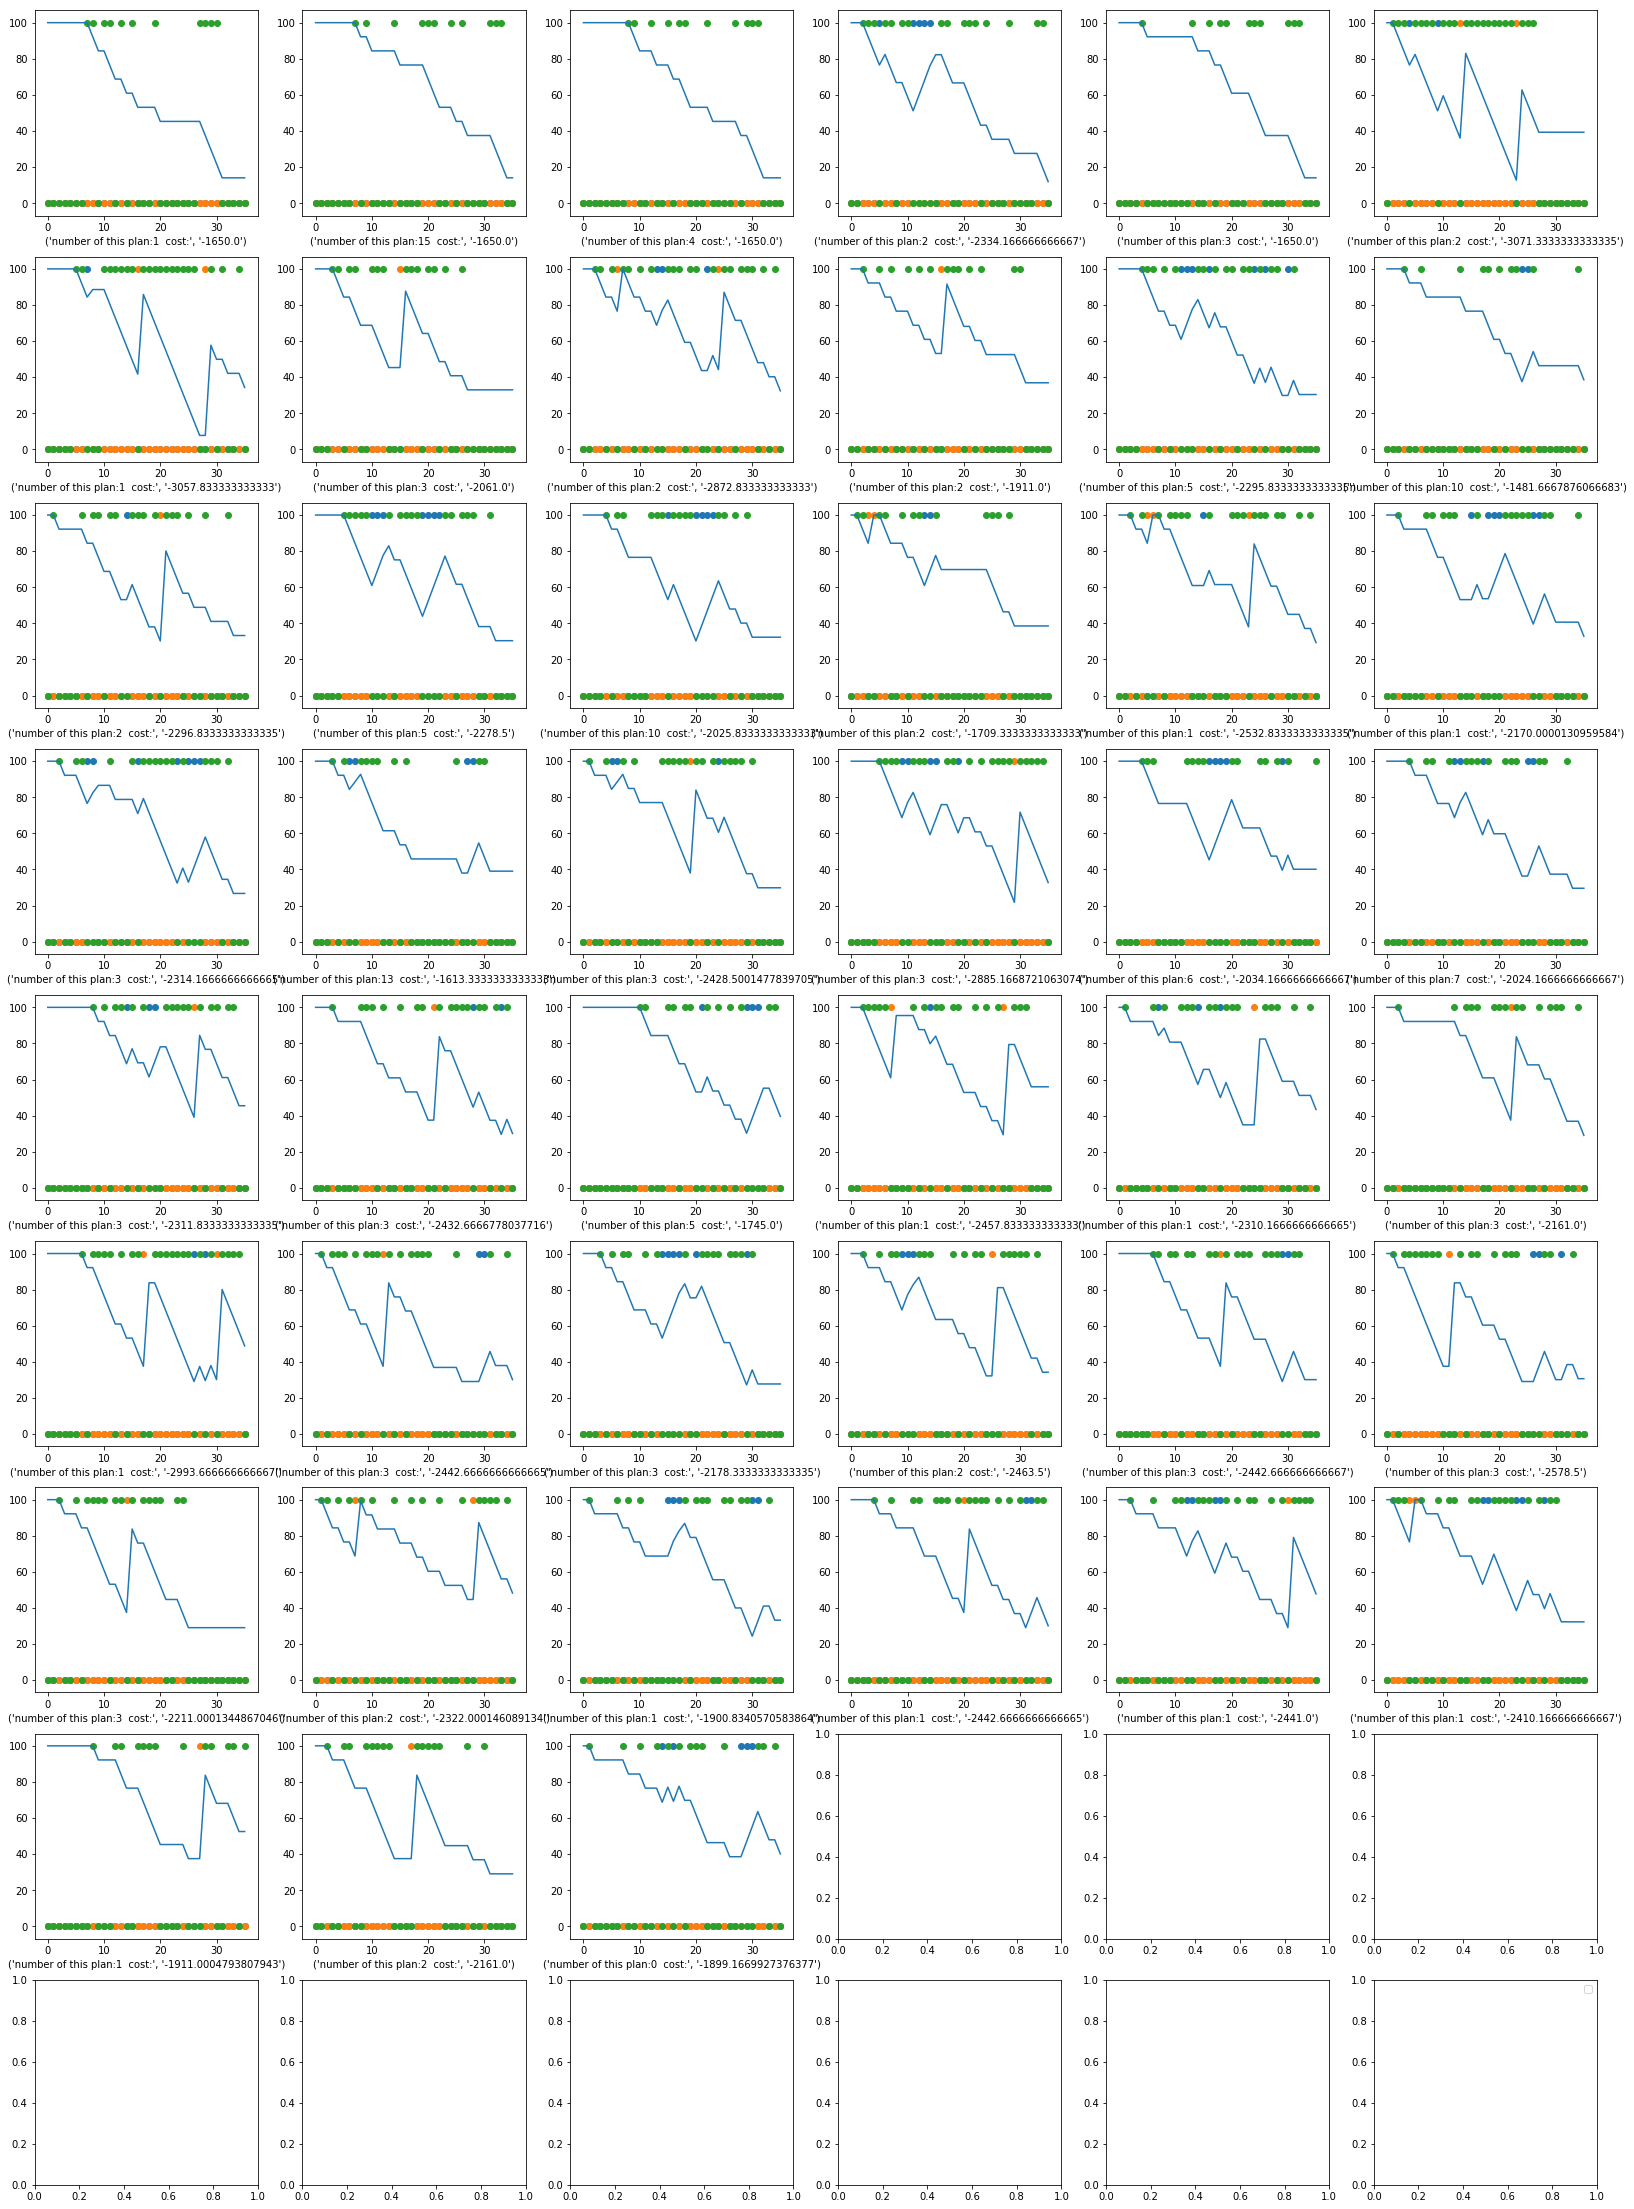

In [1329]:
k=np.shape(group_plan)[1]
x_coordinate = [ i for i in range(number_of_time_slots) ]
charge_level_day_CG=np.zeros([number_of_cars,number_of_time_slots])
slow_all=np.zeros([number_of_cars,number_of_time_slots])
fast_all=np.zeros([number_of_cars,number_of_time_slots])
demand_all=np.zeros([number_of_cars,number_of_time_slots])
charge_go_to_charge_all=np.empty([number_of_cars,number_of_time_slots])
go_to_charge_slow_all=np.empty([number_of_cars,number_of_time_slots])
go_to_charge_fast_all=np.empty([number_of_cars,number_of_time_slots])
charge_cut_charge_all=np.empty([number_of_cars,number_of_time_slots])
charge_go_to_charge_all[:]=np.nan
charge_cut_charge_all[:]=np.nan
veh_count=0
num_of_each=np.round(np.array(num_of_each),0).astype(int)
fig, ax = plt.subplots(nrows=int(k/6)+2, ncols=6,figsize=[28,(int(k/6)+1)*5])
                                               
c=0
for row in ax:
    for col in row:        
#         print('number of this plan:',num_of_each[c])
        slow=np.round(np.array(group_plan[:number_of_time_slots,c]),0)
        fast=np.round(np.array(group_plan[1*number_of_time_slots:2*number_of_time_slots,c]),0)
        demand=np.round(np.array(group_plan[2*number_of_time_slots:3*number_of_time_slots,c]),0)
        SoC, charge_go_to_charge, charge_cut_charge, go_to_charge_slow, go_to_charge_fast=calc_battery(slow, fast, demand)
        SoC=SoC[:-1]
        col.plot(x_coordinate,SoC,label='SoC')
        SoC[slow==1]=-1
        SoC[fast==1]=-1
        charge_level_day_CG[veh_count:(veh_count+int(num_of_each[c])),:]=np.tile(SoC,[int(num_of_each[c]),1])
        slow_all[veh_count:(veh_count+int(num_of_each[c])),:]=np.tile(slow,[int(num_of_each[c]),1])
        fast_all[veh_count:(veh_count+int(num_of_each[c])),:]=np.tile(fast,[int(num_of_each[c]),1])
        demand_all[veh_count:(veh_count+int(num_of_each[c])),:]=np.tile(demand,[int(num_of_each[c]),1])
        charge_go_to_charge_all[veh_count:(veh_count+int(num_of_each[c])),:]=np.tile(charge_go_to_charge,[int(num_of_each[c]),1])
        charge_cut_charge_all[veh_count:(veh_count+int(num_of_each[c])),:]=np.tile(charge_cut_charge,[int(num_of_each[c]),1])  
        
        go_to_charge_slow_all[veh_count:(veh_count+int(num_of_each[c])),:]=np.tile(go_to_charge_slow,[int(num_of_each[c]),1])  
        go_to_charge_fast_all[veh_count:(veh_count+int(num_of_each[c])),:]=np.tile(go_to_charge_fast,[int(num_of_each[c]),1])  

        col.scatter(x_coordinate,100*slow,label='slow')
        col.scatter(x_coordinate,100*fast,label='fast')
        col.scatter(x_coordinate,100*demand,label='demand')
        cap='number of this plan:'+str(int(num_of_each[c]))+'  cost:',str(optimal_column_costs[c])
        col.set_xlabel(cap)
        veh_count+=int(num_of_each[c])
#         col.xlabel('time')
#         col.ylabel("charge")
        c+=1
        if c==k:
            break
    if c==k:
        break
plt.legend()
# plt.savefig('car_plans_CG.png')       
plt.show()        
 

    


c:\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
c:\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
c:\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: All-NaN slice encountered
  
c:\python37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: All-NaN slice encountered
  import sys
c:\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: All-NaN slice encountered
  
c:\python37\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':
c:\python37\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


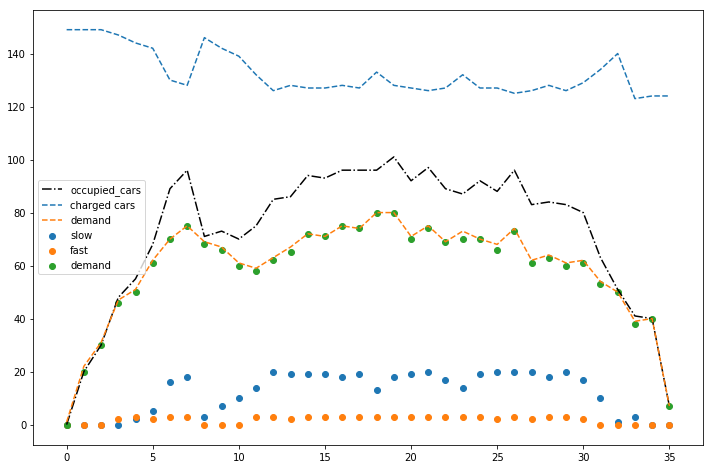

c:\python37\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less_equal


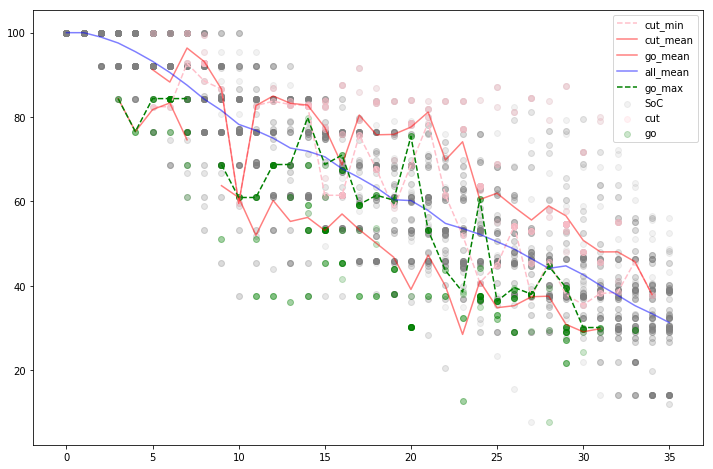

In [1330]:
agg_slow_charge=np.sum(np.multiply(np.round(group_plan[:number_of_time_slots,:],0),num_of_each[np.newaxis,:]),1)
agg_fast_charge=np.sum(np.multiply(np.round(group_plan[1*number_of_time_slots:2*number_of_time_slots,:],0),num_of_each[np.newaxis,:]),1)
agg_demand=np.sum(np.multiply(group_plan[2*number_of_time_slots:3*number_of_time_slots,:],num_of_each[np.newaxis,:]),1)
mean_charge_go_to_charge=np.nanmean(charge_go_to_charge_all,0)
mean_charge_cut_charge=np.nanmean(charge_cut_charge_all,0)
max_charge_go_to_charge=np.nanmax(charge_go_to_charge_all,0)
max_charge_cut_charge=np.nanmax(charge_cut_charge_all,0)
min_charge_go_to_charge=np.nanmin(charge_go_to_charge_all,0)
min_charge_cut_charge=np.nanmin(charge_cut_charge_all,0)
all_charge=charge_level_day_CG
all_charge[np.where(all_charge<=0)]=np.nan
mean_charge=np.nanmean(all_charge,0)
plt.figure(figsize=[12,8])
plt.scatter(x_coordinate,agg_slow_charge,label='slow')
plt.scatter(x_coordinate,agg_fast_charge,label='fast')
plt.scatter(x_coordinate,agg_demand,label='demand')

plt.plot(x_coordinate,(agg_demand+agg_slow_charge+agg_fast_charge),label='occupied_cars',linestyle='-.',color='black')
plt.plot(x_coordinate,np.sum(charge_level_day_CG>22,0),linestyle='--',label='charged cars')
plt.plot(x_coordinate,demand_sum_over_zones[:number_of_time_slots],linestyle='--',label='demand')
plt.legend()
# plt.savefig('CG_incharge')
plt.show()


plt.figure(figsize=[12,8])
# plt.plot(x_coordinate,mean_charge_cut_charge,label='cut_mean',linestyle='--',color='black')
# plt.plot(x_coordinate,max_charge_cut_charge,label='cut_max',linestyle='--',color='green')
plt.plot(x_coordinate,min_charge_cut_charge,label='cut_min',linestyle='--',color='pink')

plt.plot(x_coordinate,mean_charge_cut_charge,label='cut_mean',color='red', alpha=0.5)
plt.plot(x_coordinate,mean_charge_go_to_charge,label='go_mean',color='red', alpha=0.5)
plt.plot(x_coordinate,mean_charge,label='all_mean',color='blue', alpha=0.5)

# plt.plot(x_coordinate,min_charge_go_to_charge,label='go_min',color='pink')
plt.plot(x_coordinate,max_charge_go_to_charge,label='go_max',linestyle='--',color='green')
all_charge=charge_level_day_CG
all_charge[np.where(all_charge<=0)]=np.nan
plt.scatter(np.tile(x_coordinate,[number_of_cars,1]),all_charge,label='SoC',color='gray',alpha=0.1)    
plt.scatter(np.tile(x_coordinate,[number_of_cars,1]),charge_cut_charge_all,label='cut',color='pink',alpha=0.2)    
plt.scatter(np.tile(x_coordinate,[number_of_cars,1]),charge_go_to_charge_all,label='go',color='green',alpha=0.2)

plt.legend()
# plt.savefig('CG_SoC of go and cut charge')

plt.show()





## get results for online script

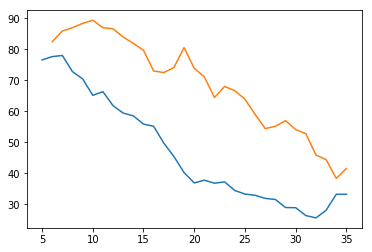

In [1076]:
#get in charge - go to charge 

X_day={'slow':list((np.sum(np.round(go_to_charge_slow_all,0),0))),'fast':list(np.sum(np.round(go_to_charge_fast_all,0),0))}
Y_day={'slow':list(agg_slow_charge),'fast':list(agg_fast_charge)}


#get SoC Up bound for going to charge and SoC Low bound for stopping charge

# SoC_Upper_bound_for_going_to_charge=mean_charge_go_to_charge*1.2
# SoC_Lower_bound_for_stopping_charge=mean_charge_cut_charge*0.8
def rolling_mean(x,k):
    ts = pd.Series(x)
    ts=ts.rolling(k,min_periods=1).mean()
    ts.plot()
    return ts


mean_charge_go_to_charge=rolling_mean(mean_charge_go_to_charge,3)
mean_charge_cut_charge=rolling_mean(mean_charge_cut_charge,3)
dic_from_A={'X_day':X_day,
           'Y_day':Y_day,
           'mean_charge_go_to_charge':list(mean_charge_go_to_charge),
           'mean_charge_cut_charge':list(mean_charge_cut_charge)}

path=path_dic['scenario']
with open(path+'DailyPlan.json', "w") as f:
    json.dump(dic_from_A, f)

### get data for calculating metric 

In [1077]:
in_charge=charge_level_day_CG==-1    

print('shape in charge',np.shape(in_charge))
mean_charge_in_charge=np.nanmean(charge_go_to_charge_all,0)
mean_charge_cut_charge=np.nanmean(charge_cut_charge_all,0)
max_charge_go_to_charge=np.nanmax(charge_go_to_charge_all,0)
max_charge_cut_charge=np.nanmax(charge_cut_charge_all,0)
min_charge_go_to_charge=np.nanmin(charge_go_to_charge_all,0)
min_charge_cut_charge=np.nanmin(charge_cut_charge_all,0)



print('shape charge',(np.shape(charge_level_day_CG)))

stop_charge=np.invert(np.isnan(charge_cut_charge_all))
go_charge=np.invert(np.isnan(charge_go_to_charge_all))

shape in charge (150, 36)
shape charge (150, 36)


c:\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
c:\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
c:\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: All-NaN slice encountered
  
c:\python37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: All-NaN slice encountered
  import sys
c:\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: All-NaN slice encountered
  
c:\python37\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':


In [1078]:
def metric_soc_CG(number_of_time_slots,stop_charge,go_charge,mean_charge_cut_charge,mean_charge_in_charge,charge,
                  in_charge,decharge_rate,IP_demand_sum_over_zones,group_size,for_above,charge_go_to_charge_all, charge_cut_charge_all):
    metric=np.ones([number_of_time_slots,1])
    index_array=np.ones([number_of_time_slots,1])
    number_of_vehicles_above=np.ones([number_of_time_slots,1])
    free_capacity=np.zeros([number_of_time_slots,number_of_time_slots])
    capacity_of_above=np.zeros([number_of_time_slots,number_of_time_slots])
    metric_t=np.zeros([1])
    t_critical=np.zeros([number_of_time_slots,1])
    delta_mat=np.zeros([number_of_time_slots,number_of_time_slots])
    for t in range(0,number_of_time_slots):
        metric_t=np.zeros([1])
        for delta in range (1,min(38,number_of_time_slots-t)):

            tt=t+delta
    #         print(t,tt)
            t_list=list(range(t,tt+1))
            assert len(t_list)==delta+1
#             print(t_list)
    #         total_to_charge=np.sum(go_to_charge[:,t_list].flatten())
    #         avg_charge_to_charge=mean_charge_go_to_charge[t_list]
            t_out_of_charge=np.sum(stop_charge,0)[t_list]
            t_go_charge=np.sum(go_charge,0)[t_list]
            t_charge_out_of_charge=mean_charge_cut_charge[[t_list]].astype(float)   
            t_charge_out_of_charge=np.nan_to_num(t_charge_out_of_charge)
            
            t_charge_in_charge=mean_charge_in_charge[[t_list]].astype(float)   
            t_charge_in_charge=np.nan_to_num(t_charge_in_charge)
#             t_charge_in_charge=np.minimum(t_charge_in_charge,30*np.ones(np.shape(t_charge_in_charge)[0]))
    #         print(t_charge_out_of_charge)
    #         print(((1/decharge_rate)*t_charge_out_of_charge).astype(int))
    #         print(np.array(list(reversed(range(1,len(t_list)+1)))))
            t_num_can_serve_from_chargers=np.minimum(np.round(((1/decharge_rate)*(t_charge_out_of_charge)),0).astype(int),np.array(list(reversed(range(1,len(t_list)+1)))))
    #         print(((1/decharge_rate)*t_charge_out_of_charge).astype(int))
    #         print(np.array(list(reversed(range(1,len(t_list)+1)))))
    #         print()
            t_num_have_to_go_to_charge=((1/decharge_rate)*(t_charge_in_charge)).astype(int)
            t_num_have_to_go_to_charge=np.repeat(t_num_have_to_go_to_charge,t_go_charge)
            t_num_can_serve_from_chargers[0]=0
            if len(t_num_have_to_go_to_charge)>0:
                t_num_have_to_go_to_charge[0]=0
            t_num_can_serve_from_chargers=np.repeat(t_num_can_serve_from_chargers,t_out_of_charge)
    #         print(t_out_of_charge)
#             print(t_num_can_serve_from_chargers)
            charge_=deepcopy(charge[:,t])
            charge_[in_charge[:,t].astype(bool)]=0
    #         print('charge_',charge_)
            num_can_serve=((1/decharge_rate)*(charge_)).astype(int)
            num_can_serve=np.minimum(num_can_serve,np.ones([len(num_can_serve)])*(delta+1))
    #         total_num_can_serve=np.concatenate([num_can_serve,t_num_can_serve_from_chargers])
            total_num_can_serve=num_can_serve
    #         print(total_num_can_serve)
            total_num_can_serve=np.tile(total_num_can_serve,group_size)
            total_num_can_serve=total_num_can_serve[total_num_can_serve>0]
#             print('cars with charge',len(total_num_can_serve))
            total_num_can_serve_sort=total_num_can_serve[np.argsort(total_num_can_serve)]
    #         total_num_can_serve_acc=np.cumsum(total_num_can_serve_sort)
            t_demand=IP_demand_sum_over_zones[t_list]

            number_of_vehicles_above[t,0]=np.sum(total_num_can_serve_sort>int(for_above/decharge_rate))

    
            put_roof_for_can_serve=lambda x: np.minimum(x,np.tile((np.array(list(reversed(range(1,len(t_list)+1))))[np.newaxis,:]),[np.shape(x)[0],1]))
            charge_go_to_charge_all_=np.nan_to_num(charge_go_to_charge_all[:,t_list].astype(float))
            charge_cut_charge_all_=np.nan_to_num(charge_cut_charge_all[:,t_list].astype(float))
            charge_go_to_charge_all_=((1/decharge_rate)*charge_go_to_charge_all_).astype(int)
            charge_cut_charge_all_=((1/decharge_rate)*charge_cut_charge_all_).astype(int)
            charge_go_to_charge_all_[:,0]=0
            charge_cut_charge_all_[:,0]=0
            charge_go_to_charge_all_=put_roof_for_can_serve(charge_go_to_charge_all_)
            charge_cut_charge_all_=put_roof_for_can_serve(charge_cut_charge_all_)            
#             ratio=1
#             avg_demand=(np.maximum((np.sum(t_demand)-(np.sum(t_num_can_serve_from_chargers))),0)/len(total_num_can_serve_sort))
# #             print('avg_demand',avg_demand)
#             below=total_num_can_serve_sort<avg_demand
#             above=total_num_can_serve_sort>=avg_demand
#     #         print(np.sum(below))
#     #         index_=(total_num_can_serve_sort>((move/np.sum(above))+avg_demand))*np.array(list(range(len(total_num_can_serve_sort))))
#             index_=(total_num_can_serve_sort>=(avg_demand))*np.arange(len(total_num_can_serve_sort))

#             index_=index_[index_>0]
#             if len(index_)>0:
#                 index=np.min(index_)
#             else:
#                 index=0

#     #         print('index',index)
            index_above_50=np.sum(total_num_can_serve_sort<(for_above/decharge_rate))
# #             index_above_50=np.maximum(index,index_above_50)
#             new_avg_demand=(np.sum(t_demand)-(ratio*group_size*np.sum(t_num_can_serve_from_chargers))-np.sum(total_num_can_serve_sort[:index]))/(len(total_num_can_serve_sort)-index)
#     #         print('new_avg_demand',new_avg_demand)
#     #         print(np.sum(new_avg_demand*((len(total_num_can_serve_sort)-index))),np.sum(total_num_can_serve_sort[index:]))

#     #         index=np.maximum(index,index_above_50)
#             met=(new_avg_demand*len(total_num_can_serve_sort[index_above_50:]))/(np.sum(total_num_can_serve_sort[index_above_50:]))
        
#             #+np.sum(t_num_have_to_go_to_charge)
        
        
        
#new version            

            
            free_capacity[t,t_list[-1]]=np.sum(total_num_can_serve_sort)+np.sum(charge_cut_charge_all_.flatten())-np.sum(t_demand)-np.sum(charge_go_to_charge_all_.flatten())
#             free_capacity[t,t_list[-1]]=np.sum(total_num_can_serve_sort)+np.sum(t_num_can_serve_from_chargers)-np.sum(t_demand)-np.sum(t_num_have_to_go_to_charge)

            capacity_of_above[t,t_list[-1]]=np.sum(total_num_can_serve_sort[index_above_50:])
            if free_capacity[t,t_list[-1]]<0:
                print('dont have charge over:', t_list)
            delta_mat[t,t_list[-1]]=len(t_list)
        

    
    return free_capacity, capacity_of_above,delta_mat, number_of_vehicles_above
        
        

In [1079]:
def metric_soc_CG_t(t,number_of_time_slots,stop_charge,go_charge,mean_charge_cut_charge,mean_charge_in_charge,charge,
                  in_charge,decharge_rate,IP_demand_sum_over_zones,group_size,for_above,charge_go_to_charge_all, charge_cut_charge_all):
    index_array=np.ones([number_of_time_slots,1])
    free_capacity=np.zeros([number_of_time_slots])
    capacity_of_above=np.zeros([number_of_time_slots])
    metric_t=np.zeros([1])
    t_critical=np.zeros([number_of_time_slots,1])
    delta_mat=np.zeros([number_of_time_slots])
    metric_t=np.zeros([1])
    for delta in range (1,min(38,number_of_time_slots-t)):
        tt=t+delta
        t_list=list(range(t,tt+1))
        assert len(t_list)==delta+1

        t_out_of_charge=np.sum(stop_charge,0)[t_list]
        t_go_charge=np.sum(go_charge,0)[t_list]
        t_charge_out_of_charge=mean_charge_cut_charge[[t_list]].astype(float)   
        t_charge_out_of_charge=np.nan_to_num(t_charge_out_of_charge)

        t_charge_in_charge=mean_charge_in_charge[[t_list]].astype(float)   
        t_charge_in_charge=np.nan_to_num(t_charge_in_charge)

        t_num_can_serve_from_chargers=np.minimum(np.round(((1/decharge_rate)*(t_charge_out_of_charge)),0).astype(int),np.array(list(reversed(range(1,len(t_list)+1)))))

        t_num_have_to_go_to_charge=((1/decharge_rate)*(t_charge_in_charge)).astype(int)
        t_num_have_to_go_to_charge=np.repeat(t_num_have_to_go_to_charge,t_go_charge)
        t_num_can_serve_from_chargers[0]=0
        if len(t_num_have_to_go_to_charge)>0:
            t_num_have_to_go_to_charge[0]=0
        t_num_can_serve_from_chargers=np.repeat(t_num_can_serve_from_chargers,t_out_of_charge)

        charge_=deepcopy(charge)
        charge_[in_charge.astype(bool)]=0
        num_can_serve=((1/decharge_rate)*(charge_)).astype(int)
        num_can_serve=np.minimum(num_can_serve,np.ones([len(num_can_serve)])*(delta+1))
        total_num_can_serve=num_can_serve
        total_num_can_serve=np.tile(total_num_can_serve,group_size)
        total_num_can_serve=total_num_can_serve[total_num_can_serve>0]
        total_num_can_serve_sort=total_num_can_serve[np.argsort(total_num_can_serve)]
        t_demand=IP_demand_sum_over_zones[t_list]

        number_of_vehicles_above=np.sum(total_num_can_serve_sort>int(for_above/decharge_rate))


        put_roof_for_can_serve=lambda x: np.minimum(x,np.tile((np.array(list(reversed(range(1,len(t_list)+1))))[np.newaxis,:]),[np.shape(x)[0],1]))
        charge_go_to_charge_all_=np.nan_to_num(charge_go_to_charge_all[:,t_list].astype(float))
        charge_cut_charge_all_=np.nan_to_num(charge_cut_charge_all[:,t_list].astype(float))
        charge_go_to_charge_all_=((1/decharge_rate)*charge_go_to_charge_all_).astype(int)
        charge_cut_charge_all_=((1/decharge_rate)*charge_cut_charge_all_).astype(int)
        charge_go_to_charge_all_[:,0]=0
        charge_cut_charge_all_[:,0]=0
        charge_go_to_charge_all_=put_roof_for_can_serve(charge_go_to_charge_all_)
        charge_cut_charge_all_=put_roof_for_can_serve(charge_cut_charge_all_)            
        index_above_50=np.sum(total_num_can_serve_sort<(for_above/decharge_rate))
        free_capacity[t_list[-1]]=np.sum(total_num_can_serve_sort)+np.sum(charge_cut_charge_all_.flatten())-np.sum(t_demand)-np.sum(charge_go_to_charge_all_.flatten())
        capacity_of_above[t_list[-1]]=np.sum(total_num_can_serve_sort[index_above_50:])
        if free_capacity[t_list[-1]]<0:
            print('dont have charge over:', t_list)
        delta_mat[t_list[-1]]=len(t_list)

    return free_capacity, capacity_of_above,delta_mat, number_of_vehicles_above
        
        

In [1080]:

import pickle
metric_input_data={}
for var in ['number_of_time_slots', 'stop_charge','go_charge', 'mean_charge_cut_charge', 'mean_charge_in_charge', 
            'decharge_rate',  'demand_sum_over_zones','charge_go_to_charge_all', 'charge_cut_charge_all']:
    metric_input_data[var]=eval(var)
    
path=path_dic['scenario']
with open(path+'metric_input_data.pickle', 'wb') as handle:
    pickle.dump(metric_input_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1081]:
# t=10
# convert_nan=lambda x: np.nan_to_num(x.astype('float'))

# for_above=0
# free_capacity, capacity_of_above, delta_mat, number_of_vehicles_above=metric_soc_CG_t(t,number_of_time_slots, stop_charge,go_charge, 
#                                                                                     mean_charge_cut_charge, mean_charge_in_charge, 
#                                                                                     charge_level_day_CG[:,t], in_charge[:,t], decharge_rate, 
#                                                                                     demand_sum_over_zones, 1, for_above,
#                                                                                     charge_go_to_charge_all, charge_cut_charge_all)

# free_capacity=convert_nan(free_capacity)
# capacity_of_above=convert_nan(capacity_of_above)
# free_capacity=np.minimum(free_capacity,capacity_of_above)
# metric=(capacity_of_above-free_capacity)/(delta_mat*number_of_vehicles_above)  
# metric_0=np.nanmax(metric) 
# number_of_vehicles_above_0=number_of_vehicles_above
# metric_dic={}
# plt.figure(figsize=[15,7])
# for for_above in [80,60,40,20,0]:
    
#     free_capacity, capacity_of_above, delta_mat, number_of_vehicles_above=metric_soc_CG_t(t,number_of_time_slots, stop_charge,go_charge, 
#                                                                                     mean_charge_cut_charge, mean_charge_in_charge, 
#                                                                                     charge_level_day_CG[:,t], in_charge[:,t], decharge_rate, 
#                                                                                     demand_sum_over_zones, 1, for_above,
#                                                                                     charge_go_to_charge_all, charge_cut_charge_all)
#     free_capacity=convert_nan(free_capacity)
#     capacity_of_above=convert_nan(capacity_of_above)
#     free_capacity=np.minimum(free_capacity,capacity_of_above)
#     metric=((capacity_of_above-free_capacity)/(delta_mat*number_of_vehicles_above))
#     normal_metric=(np.nanmax(metric)/metric_0)/(number_of_vehicles_above/number_of_vehicles_above_0).flatten()
#     normal_metric[np.isnan(normal_metric)]=1
#     normal_metric=np.maximum(normal_metric,1)
#     metric_dic[for_above]=normal_metric[0]
#     print(metric_dic)

# # path=path_dic['scenario']
# # with open(path+'soc_metric.json', "w") as f:
# #     json.dump(metric_dic, f)

c:\python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
c:\python37\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: All-NaN slice encountered
c:\python37\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
c:\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: All-NaN slice encountered


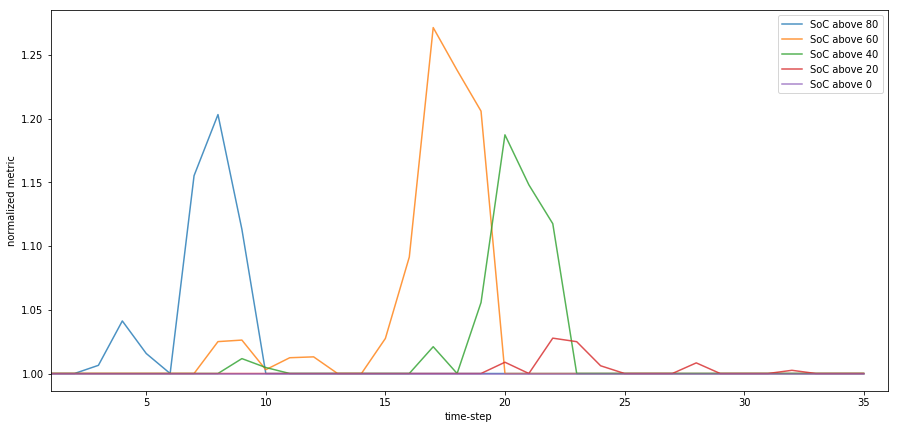

In [1082]:
convert_nan=lambda x: np.nan_to_num(x.astype('float'))
for_above=50


for for_above in [0]:
    
    free_capacity, capacity_of_above, delta_mat, number_of_vehicles_above=metric_soc_CG(number_of_time_slots, stop_charge,go_charge, 
                                                                                        mean_charge_cut_charge, mean_charge_in_charge, 
                                                                                        charge_level_day_CG, in_charge, decharge_rate, 
                                                                                        demand_sum_over_zones, 1, for_above,
                                                                                        charge_go_to_charge_all, charge_cut_charge_all)

    free_capacity=convert_nan(free_capacity)
    capacity_of_above=convert_nan(capacity_of_above)
    free_capacity=np.minimum(free_capacity,capacity_of_above)
    metric=(capacity_of_above-free_capacity)/(delta_mat*number_of_vehicles_above)  
    metric_0=np.array([np.nanmax(metric[t,:]) for t in list(range(number_of_time_slots))])
    number_of_vehicles_above_0=number_of_vehicles_above
metric_dic={}
plt.figure(figsize=[15,7])
for for_above in [80,60,40,20,0]:
    
    free_capacity, capacity_of_above, delta_mat, number_of_vehicles_above=metric_soc_CG(number_of_time_slots, stop_charge,go_charge, mean_charge_cut_charge, mean_charge_in_charge, 
                                                   charge_level_day_CG, in_charge, decharge_rate, demand_sum_over_zones, 1, for_above,charge_go_to_charge_all, charge_cut_charge_all)

    free_capacity=convert_nan(free_capacity)
    capacity_of_above=convert_nan(capacity_of_above)
    free_capacity=np.minimum(free_capacity,capacity_of_above)
    metric=((capacity_of_above-free_capacity)/(delta_mat*number_of_vehicles_above))
    normal_metric=(np.array([np.nanmax(metric[t,:]) for t in list(range(number_of_time_slots))])/metric_0)/(number_of_vehicles_above/number_of_vehicles_above_0).flatten()
    normal_metric[np.isnan(normal_metric)]=1
    normal_metric=np.maximum(normal_metric,1)
    metric_dic[for_above]=list(normal_metric)
    plt.plot(normal_metric,label='SoC above '+str(for_above),alpha=0.8)
plt.legend()
plt.xlim([1, number_of_time_slots])
plt.xlabel('time-step')
plt.ylabel('normalized metric')
plt.show()

# plt.figure(figsize=[15,7])
# for for_above in [80,60,40,20,0]:
    
#     free_capacity, capacity_of_above, delta_mat, number_of_vehicles_above=metric_soc_CG(number_of_time_slots, stop_charge,go_charge, mean_charge_cut_charge, mean_charge_in_charge, 
#                                                    charge_level_day_CG, in_charge, decharge_rate, demand_sum_over_zones, 1, for_above,charge_go_to_charge_all, charge_cut_charge_all)

#     free_capacity=convert_nan(free_capacity)
#     capacity_of_above=convert_nan(capacity_of_above)
#     free_capacity=np.minimum(free_capacity,capacity_of_above)
#     metric=((capacity_of_above-free_capacity)/(delta_mat*number_of_vehicles_above))
#     metric_=np.array([np.nanmax(metric[t,:]) for t in list(range(number_of_time_slots))])
#     plt.plot(metric_,label='SoC above '+str(for_above),alpha=0.8)
# plt.legend()
# plt.xlim([1, number_of_time_slots])
# plt.xlabel('time-step')
# plt.ylabel('unnormalized metric')
# plt.show()
path=path_dic['scenario']
with open(path+'soc_metric.json', "w") as f:
    json.dump(metric_dic, f)

# Visulize final results: stage[4]

In [10]:
SoC_in_assignment=False
lazy_charging=True

In [12]:
def plt_finish(name):
    path=path_dic['results']+name.replace(" ", "_")
    plt.savefig(path,  transparent=True)
    plt.show()
df_list_of_vehicles=pd.DataFrame(data={'VehicleId':np.arange(1,fleet_size+1)})
files_to_track_performance={'cost_to_charger':{'df':[],
                                     'columns':['time','VehicleId','cost_charge','cost_time','cost_distance','charger','SoC']},
                    'cost_relocation':{'df':[],
                                     'columns':['time','VehicleId','cost_charge','cost_time','cost_distance','from_zone','to_zone','SoC']},
                    'deleted_relocation':{'df':[],
                                     'columns':['time','VehicleId']},
                    'cost_from_charger':{'df':[],
                                     'columns':['time','VehicleId','cost_charge','cost_time','cost_distance','charger','to_zone','SoC']},
                    'SoC_distribution':{'df':[],
                                     'columns':['time','VehicleId','SoC']},
                    'charger_occupation':{'df':[],
                                     'columns':['time','charger','num']},
                    'B_slack_going':{'df':[],
                                     'columns':['time','slow_in','fast_in','slow_go','fast_go', 'X_slow', 'X_fast', 'chargable']},
                    'C_slack':{'df':[],
                                     'columns':['time','flow_slack','in_charge_slow','in_charge_fast']},
                    'charge_gained':{'df':[],
                                     'columns':['time','slow','fast']}}

def make_files_to_track_performance(files_to_track_performance,task,to_append={}):
    path=path_dic['scenario']+'results/'+str(3)+'/'
    for name in list(files_to_track_performance.keys()): 
        if task=='make':
            files_to_track_performance[name]['df']=pd.DataFrame(columns=files_to_track_performance[name]['columns'])
            files_to_track_performance[name]['df'].to_csv(path+name+'.csv',sep=';',index=False)
        if task=='read':
            files_to_track_performance[name]['df']=pd.read_csv(path+name+'.csv',sep=';')
        if task=='write':
            with open(path+name+'.csv', 'a') as f:
                files_to_track_performance[name]['df'].to_csv(f, header=False, index=False,sep=';')
    if task=='update':
        for name in list(to_append.keys()): 
            to_append[name]['time']=time_in_simulation
            to_append[name]=to_append[name][files_to_track_performance[name]['columns']]
##            files_to_track_performance[name]['df']=pd.concat ([files_to_track_performance[name]['df'],to_append[name]])
            files_to_track_performance[name]['df']=to_append[name]
    return files_to_track_performance
path=path_dic['scenario']
charger_attribute=pd.read_csv(path+'charger_attribute.csv',sep=';')
charger_attribute['charger_location']=charger_attribute['charger_location'].apply(lambda x: literal_eval(x)).tolist()
df_results=make_files_to_track_performance(files_to_track_performance,'read')

path=path_dic['scenario']
with open(path+'DailyPlan.json', "r") as f:
    DailyPlan=json.load(f)

## Charging 

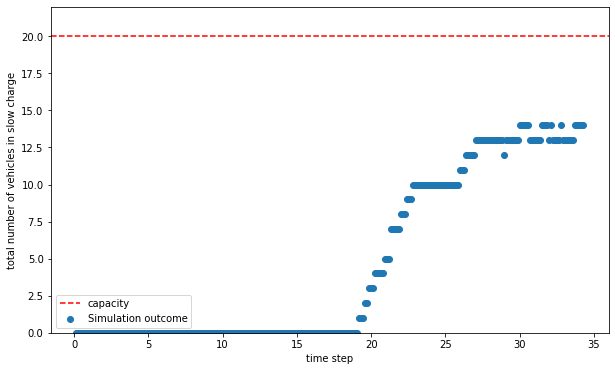

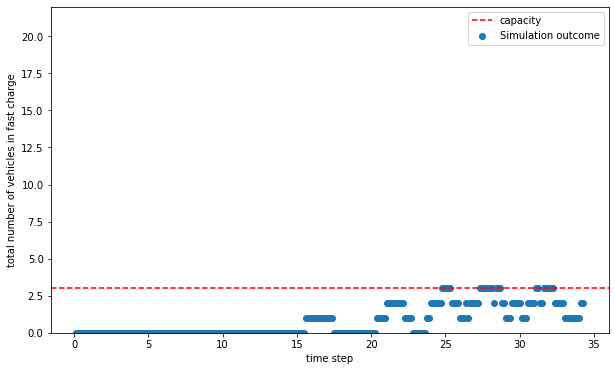

total charging trips 39
by slow 22


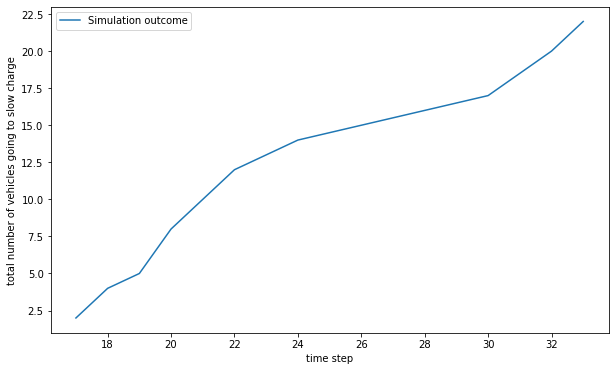

by fast 17


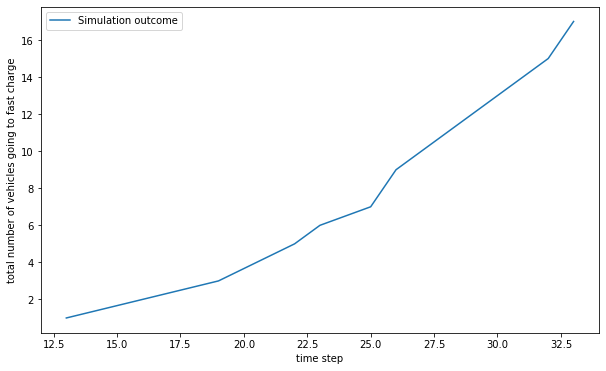

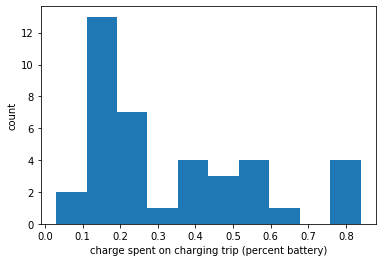

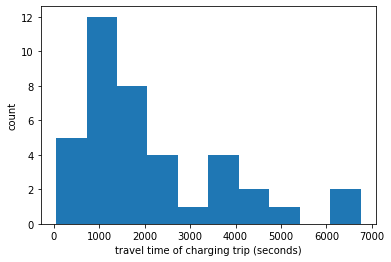

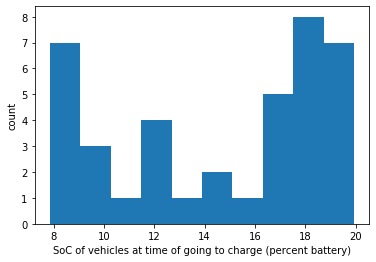

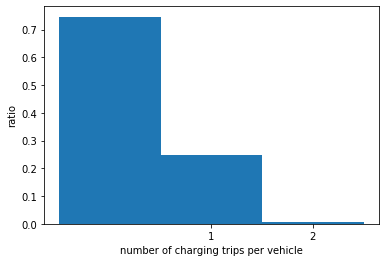

In [13]:
df=df_results['charger_occupation']['df']
charger_occupation_sum_over_time={}
path=path_dic['scenario']
with open(path+'DailyPlan.json', "r") as f:
    DailyPlan=json.load(f)
for type_ in ['slow','fast']:
    list_=charger_attribute[charger_attribute[type_]==1]['charger_id'].tolist()
    df_results['charger_occupation']['df'][type_]=df['charger'].isin(list_)
    charger_occupation_sum_over_time[type_]=df[df['charger'].isin(list_)].groupby(['time']).sum()['num'].reset_index()
    plt.figure(figsize=[10,6])
    T=int((charger_occupation_sum_over_time[type_]['time']/1800).max())+1
    plt.scatter(charger_occupation_sum_over_time[type_]['time']/1800,charger_occupation_sum_over_time[type_]['num'],label='Simulation outcome')
    plt.xlabel('time step')
    name='total number of vehicles in '+type_+' charge'
    plt.ylabel(name)
    plt.ylim(0,2+charger_attribute[charger_attribute['slow']==1]['capacity'].sum())
    plt.axhline(y=charger_attribute[charger_attribute[type_]==1]['capacity'].sum(), color='r', linestyle='--',label='capacity')
    plan=np.array(DailyPlan['Y_day'][type_][:T]).astype(int)
    x_axis=np.arange(len(plan))
    plan=np.repeat(plan,10)
    x_axis=np.repeat(x_axis,10)+np.tile(np.arange(10)/10,len(x_axis))
    if not lazy_charging:
        plt.plot(x_axis,plan, color='m', linestyle=':',label='plan by algorithm A')
    plt.legend()
    plt_finish(name)
    
    
df=df_results['cost_to_charger']['df'][:].drop_duplicates()
print('total charging trips',len(df))
df['time_step']=(df['time']/1800).astype(int)
df['one']=1
going_to_charger={}
path=path_dic['scenario']
with open(path+'DailyPlan.json', "r") as f:
    DailyPlan=json.load(f)
for type_ in ['slow','fast']:
    list_=charger_attribute[charger_attribute[type_]==1]['charger_id'].tolist()
    going_to_charger[type_]=df[df['charger'].isin(list_)].groupby(['time_step']).sum()['one'].reset_index()
    plt.figure(figsize=[10,6])
#     T=int(going_to_charger[type_]['time_step'].max())+1
    print('by',type_,going_to_charger[type_]['one'].sum())
    data=np.cumsum(going_to_charger[type_]['one'].values)
    plt.plot(going_to_charger[type_]['time_step'],data,label='Simulation outcome')
    plt.xlabel('time step')
    name='total number of vehicles going to '+type_+' charge'
    plt.ylabel(name)
#     plt.ylim(0,2+charger_attribute[charger_attribute['slow']==1]['capacity'].sum())
#     plt.axhline(y=charger_attribute[charger_attribute[type_]==1]['capacity'].sum(), color='r', linestyle='--',label='capacity')
    plan=np.cumsum(np.array(DailyPlan['X_day'][type_][:T]).astype(int))
    x_axis=np.arange(len(plan))
    plan=np.repeat(plan,10)
    x_axis=np.repeat(x_axis,10)+np.tile(np.arange(10)/10,len(x_axis))
    if not lazy_charging:
        plt.plot(x_axis,plan, color='m', linestyle=':',label='plan by algorithm A')
    plt.legend()
    plt_finish(name)


for a in ['charger']:
    df[a]=df[a].astype(int)
list_column_name=['cost_charge','cost_time','SoC']
list_name_print=['charge spent on charging trip','travel time of charging trip','SoC of vehicles at time of going to charge']
list_unit=['percent battery','seconds','percent battery']

for i in range(len(list_column_name)):
    plt.hist(df[list_column_name[i]])
    name=list_name_print[i]
    unit=list_unit[i]
    plt.xlabel(name+' ('+unit+')')
    plt.ylabel('count')
    plt_finish('histogram of '+name)
    
    
df_by={}
df_by['VehicleId']=df.groupby('VehicleId').sum().reset_index()
df_by['VehicleId']=pd.merge(df_list_of_vehicles,df_by['VehicleId'],how='left',on='VehicleId')
df_by['VehicleId'].fillna(0,inplace =True)
n=int(df_by['VehicleId']['one'].max())
data=df_by['VehicleId']['one']
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), weights=np.ones(len(data)) / len(data))
name='number of charging trips per vehicle'
plt.xlabel(name)
plt.xticks(range(1,n+1))
plt.ylabel('ratio')
plt_finish('histogram of '+name)

## Relocation 

In [14]:
if not lazy_charging:
    df=df_results['cost_relocation']['df']
    for a in ['from_zone','to_zone']:
        df[a]=df[a].astype(int)
    df['one']=1
    df['time_step']=(df['time']/1800).astype(int)
    list_column_name=['time_step','cost_charge','cost_time','SoC']
    list_name_print=['time-step','charge spent on relocation trip','travel time of relocation trip','SoC of vehicles at time of relocation']
    list_unit=['',' (percent battery)',' (seconds)',' (percent battery)']

    for i in range(len(list_column_name)):
        plt.hist(df[list_column_name[i]])
        name=list_name_print[i]
        unit=list_unit[i]
        plt.xlabel(name+unit)
        plt.ylabel('count')
        plt_finish('histogram of '+name)



    list_column_name=['from_zone','to_zone']
    list_label=['origin','destination']
    data={}
    X=list(set(list(np.sort(np.append(df['from_zone'].values,df['to_zone'].values).astype(int)))))
    for i in range(len(list_column_name)):
        df_=df.groupby([list_column_name[i]])['one'].sum().reset_index()
        df_=pd.merge(pd.DataFrame(data={'zone':X}),df_,how='left',left_on='zone',right_on=list_column_name[i])
        data[list_label[i]]=df_['one'].values
    df__ = pd.DataFrame(data=data, index=X)
    plt.ticklabel_format(useOffset=False)
    df__.plot.bar()

    name='origin and destination of relocation trips'
    plt.xlabel(name)
    plt.ylabel('count')
    plt_finish('histogram of '+name)
    # plt.legend()



    df['one']=1
    df_by={}
    df_by['VehicleId']=df.groupby('VehicleId')['one'].sum().reset_index()
    df_by['VehicleId']=pd.merge(df_list_of_vehicles,df_by['VehicleId'],how='left',on='VehicleId')
    df_by['VehicleId'].fillna(0,inplace =True)
    data=df_by['VehicleId']['one']
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), weights=np.ones(len(data)) / len(data))
    name='number of relocations per vehicle'
    plt.xlabel(name)
    plt.xticks(range(0,bins))
    plt.ylabel('ratio')
    plt_finish('histogram of '+name)


    for direction in ['from','to']:
        plt.figure(figsize=[10,6])
        df_by['time-step'+'_'+direction+'_zone']=df.groupby(['time_step',direction+'_zone']).sum().reset_index()
        for zone in df[direction+'_zone'].unique():
            df_=df_by['time-step'+'_'+direction+'_zone'][df_by['time-step'+'_'+direction+'_zone'][direction+'_zone']==zone]
            plt.plot(df_['time_step'],df_['one'],label='zone '+str(int(zone)), linestyle='--',alpha=0.5)
            name='count of relocation trips '+direction+' each zone over time'
            plt.xlabel('time-step')
            plt.ylabel('count')
        plt.legend()
        plt_finish(name)


## Vehicles

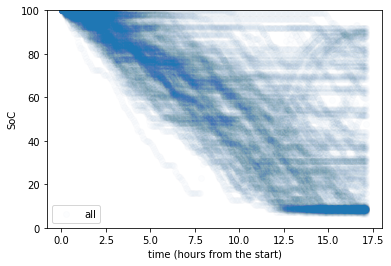

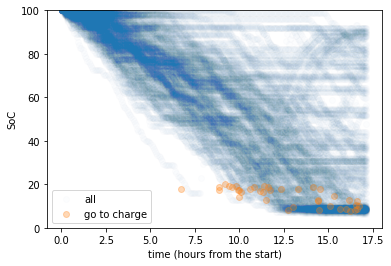

No handles with labels found to put in legend.


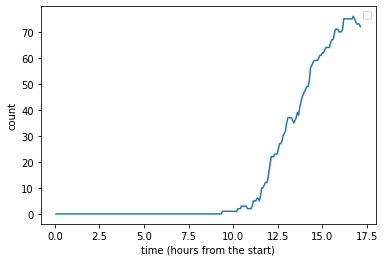

In [15]:
df=df_results['SoC_distribution']['df']
plt.scatter(df['time']/3600,df['SoC'],alpha=0.01,label='all')
df=df_results['cost_to_charger']['df']
# plt.scatter(df['time']/3600,df['SoC'],alpha=0.8,label='go to charge')
# df=df_results['cost_from_charger']['df']
# plt.scatter(df['time']/3600,df['SoC'],alpha=0.8,label='stop charging')

plt.ylim(0,100)
name='SoC of vehicles in time'
plt.xlabel('time (hours from the start)')
plt.ylabel('SoC')
plt.legend()
plt_finish(name)


df=df_results['SoC_distribution']['df']
plt.scatter(df['time']/3600,df['SoC'],alpha=0.01,label='all')
df=df_results['cost_to_charger']['df']
plt.scatter(df['time']/3600,df['SoC'],alpha=0.3,label='go to charge')
if not lazy_charging:
    df=df_results['cost_from_charger']['df']
    plt.scatter(df['time']/3600,df['SoC'],alpha=0.3,label='stop charging')

plt.ylim(0,100)
name='SoC of vehicles in time (specifying SoC of in and out of charging)'
plt.xlabel('time (hours from the start)')
plt.ylabel('SoC')
plt.legend()
plt_finish(name)


df=df_results['SoC_distribution']['df']
df['no_charge']=df['SoC'].apply(lambda x:x<15)
no_charge=df.groupby('time')['no_charge'].sum()
plt.plot((df['time']/3600).unique(),no_charge)
# df=df_results['cost_to_charger']['df']
# plt.scatter(df['time']/3600,df['SoC'],alpha=0.3,label='go to charge')
# df=df_results['cost_from_charger']['df']
# plt.scatter(df['time']/3600,df['SoC'],alpha=0.3,label='stop charging')


name='Vehicles with SoC below 15'
plt.xlabel('time (hours from the start)')
plt.ylabel('count')
plt.legend()
plt_finish(name)

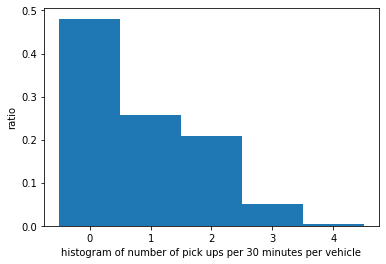

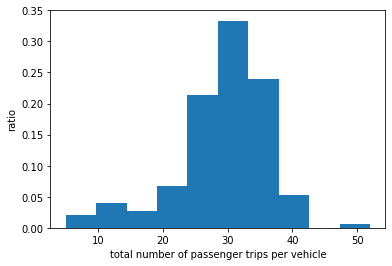

In [22]:
effective_relocation_thereshlod_in_minutes=20
path=path_dic['scenario']+'results/'+str(int(3))+'/toure and trajectory/'
df_EVehicleTours_day=pd.read_csv(path+'df_EVehicleTours_day.csv',sep=';')
# df_EVehicleTours_day=df_EVehicleTours_day[df_EVehicleTours_day['time']<=max_time]
df_EVehicleTours_day_agg=get_df_EVehicleTours_day_agg(df_EVehicleTours_day)
data=df_EVehicleTours_day_agg['num_pickups_in_30_min']
d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), weights=np.ones(len(data)) / len(data))
# plt.hist(data,bins=max(data)+1, weights=np.ones(len(data)) / len(data),align='left')
name='histogram of number of pick ups per 30 minutes per vehicle'
plt.xlabel(name)
plt.ylabel('ratio')
plt_finish(name)

vehicles_all_trip=df_EVehicleTours_day_agg.groupby('VehicleId')['TripIds_with_pickup_in_step'].apply(sum).reset_index()
vehicles_all_trip['num_trips']=vehicles_all_trip['TripIds_with_pickup_in_step'].apply(lambda x:len(x))

data=vehicles_all_trip['num_trips']
plt.ticklabel_format(useOffset=False)
plt.hist(data, weights=np.ones(len(data)) / len(data))
name='total number of passenger trips per vehicle'
plt.xlabel(name)
plt.ylabel('ratio')
plt_finish('histogram of '+name)

path=path_dic['scenario']
with open(path+'TripRequests.json', "r") as f:
    request_list=json.load(f)
    
if not lazy_charging:    
    def get_birth_time_for_trips(list_trip_id):
        list_birth_times=[t['BirthTime'] for t in request_list if int(t['Id']) in list_trip_id]
        return np.sort(np.array(list_birth_times))
    vehicles_all_trip['trip_bith_times']=vehicles_all_trip['TripIds_with_pickup_in_step'].apply(get_birth_time_for_trips)


    vehicles_all_relocations=df_results['cost_relocation']['df'][:].drop_duplicates()
    vehicles_all_relocations['VehicleId']=vehicles_all_relocations['VehicleId'].astype(int)
    df_by={}
    vehicles_all_relocations=vehicles_all_relocations.groupby(['VehicleId'])['time'].apply(list).reset_index()
    vehicles_all_relocations['time_relocations']=vehicles_all_relocations['time'].apply(lambda x:np.sort(np.array(x)))
    vehicles_all_relocations=pd.merge(vehicles_all_relocations,vehicles_all_trip[['VehicleId','trip_bith_times']],how='left',on='VehicleId')
    def get_time_until_next_trip_from_relocation(relocations, trips):
        delta=[]
        for i in range(len(relocations)):
            b=trips[trips>relocations[i]]
            if len(b)>0:
                d=np.min(b)-relocations[i]
            else:
                d=10000
            delta+=[d]
        return np.array(delta)
    vehicles_all_relocations['time_wait_for_trip_after_relocation']=vehicles_all_relocations.apply(lambda row:
                                                                                                  get_time_until_next_trip_from_relocation(row['time_relocations'],
                                                                                                                                          row['trip_bith_times']),axis=1)
    vehicles_all_relocations['num_effective_relocations']=vehicles_all_relocations['time_wait_for_trip_after_relocation'].apply(lambda x:len(x[x<effective_relocation_thereshlod_in_minutes*60]))
    vehicles_all_relocations['num_total_relocation']=vehicles_all_relocations['time_relocations'].apply(lambda x:len(x))
    vehicles_all_relocations['percent_effective_relocations']=vehicles_all_relocations['num_effective_relocations']/vehicles_all_relocations['num_total_relocation']
    data=vehicles_all_relocations['percent_effective_relocations']
    plt.ticklabel_format(useOffset=False)
    plt.hist(data, weights=np.ones(len(data)) / len(data))
    name='ratio of relocation effectiveness per vehicle \n  effective = relocation lead to assignment of a request within '+str(effective_relocation_thereshlod_in_minutes)+' minutes'
    plt.xlabel(name)
    plt.ylabel('ratio')
    plt_finish('histogram of ratio of relocation effectiveness per vehicle')


    kpi_effective_relocation=vehicles_all_relocations['num_effective_relocations'].sum()/vehicles_all_relocations['num_total_relocation'].sum()
    print('total number of relocation:',vehicles_all_relocations['num_total_relocation'].sum(),
          'number of effective relocation:',vehicles_all_relocations['num_effective_relocations'].sum(),
          'relocation efficiency:',kpi_effective_relocation)

## trips

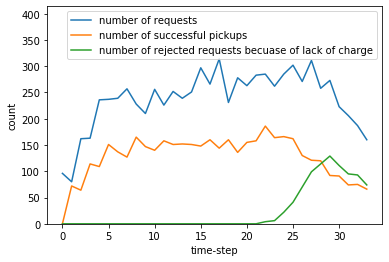

c:\python37\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\python37\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


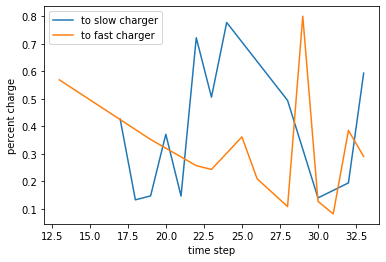

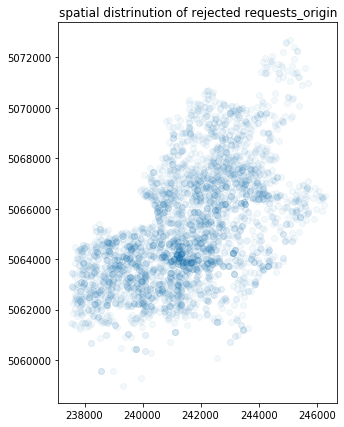

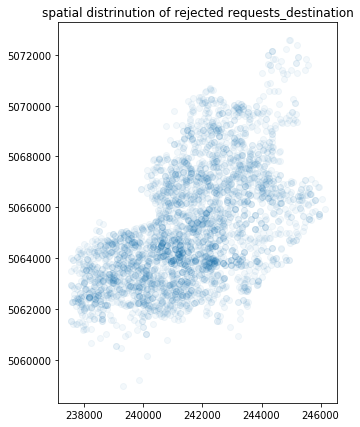

In [23]:
total_pick_ups=df_EVehicleTours_day_agg.groupby('timestep')['num_pickups_in_30_min'].sum().reset_index()
df_request=json_normalize(request_list)
df_request['timestep']=(df_request['BirthTime']/1800).astype(int)
df_request_agg=df_request.groupby(['timestep'])['Id'].count().reset_index()
path=path_dic['scenario']+'results/'+str(3)+'/'
newpath=path+'rejected_by_lack_of_charge.csv'
if os.path.exists(newpath):
    df_rejected=pd.read_csv(path+'rejected_by_lack_of_charge.csv',sep=';')
else:
    df_rejected=pd.DataFrame(columns=['time','TripId'])
df_rejected['timestep']=(df_rejected['time']/1800).astype(int)
df_rejected_agg=df_rejected.groupby(['timestep'])['TripId'].count().reset_index()
merged=pd.merge(df_request_agg,total_pick_ups,how='left',on='timestep')
merged=pd.merge(merged,df_rejected_agg,how='left',on='timestep')
merged.fillna(0,inplace=True)
plt.plot(merged['timestep'],merged['Id'],label='number of requests')
plt.plot(merged['timestep'],merged['num_pickups_in_30_min'],label='number of successful pickups')
plt.plot(merged['timestep'],merged['TripId'],label='number of rejected requests becuase of lack of charge')
name='trips'
plt.xlabel('time-step')
plt.ylabel('count')
plt.ylim(0,merged['Id'].max()+100)
plt.legend()
plt_finish(name)


for direc in ['to','from']:
    if not lazy_charging or direc=='to':
        df=df_results['cost_'+direc+'_charger']['df'][:]
        df['time_step']=(df['time']/1800).astype(int)
        df['one']=1
        for type_ in ['slow','fast']:
            list_=charger_attribute[charger_attribute[type_]==1]['charger_id'].tolist()
            going_to_charger[type_]=df[df['charger'].isin(list_)].groupby(['time_step']).mean()['cost_charge'].reset_index()
        #     T=int(going_to_charger[type_]['time_step'].max())+1
            data=going_to_charger[type_]['cost_charge']
            plt.plot(going_to_charger[type_]['time_step'],data,label=direc+' '+type_+' charger')
            plt.xlabel('time step')
            name='Average cost of going to charger and back'
            plt.ylabel('percent charge')

plt.legend()
plt_finish(name)


if not lazy_charging:
    df=df_results['cost_relocation']['df']
    df['time_step']=(df['time']/1800).astype(int)
    list_column_name=['time_step','cost_charge','cost_time','SoC']
    df_agg=df.groupby(['time_step'])['cost_charge'].sum().reset_index()
    data=df_agg['cost_charge'].values / merged['num_pickups_in_30_min'].values[:len(df_agg['time_step'])]
    plt.plot(df_agg['time_step'],data)
    name='Average charge spent on relocation per succesful pickup'
    plt.xlabel('time-step')
    plt.ylabel('percent charge')
    plt_finish(name)

list_trip_ids_satisfied=vehicles_all_trip['TripIds_with_pickup_in_step'].sum()

plt.figure(figsize=(5,7))
df_to_plot_rejected=df_request[df_request['Id'].astype(int).isin(list_trip_ids_satisfied)==0][['FromX','FromY','ToX','ToY']]
plt.scatter(df_to_plot_rejected['FromX'],df_to_plot_rejected['FromY'],alpha=0.05)
name='spatial distrinution of rejected requests_origin'
plt.title(name)
plt_finish(name)
plt.figure(figsize=(5,7))
plt.scatter(df_to_plot_rejected['ToX'],df_to_plot_rejected['ToY'],alpha=0.05)
name='spatial distrinution of rejected requests_destination'
plt.title(name)
plt_finish(name)

## algorithm R

In [24]:
if not lazy_charging and SoC_in_assignment:
    path=path_dic['scenario']+'results/'+str(3)+'/'
    df_R={}
    df_R['R']=pd.read_csv(path+'chosen_vehicles.csv',sep=';')
    df_R['Dispatcher']=pd.read_csv(path+'ptv_chosen_vehicles.csv',sep=';')
    df_compare_R=df_R['R'][['time_in_simulation','TripId','VehicleId','SoC_now','insertion_cost','utility']]
    for i in ['VehicleId','SoC_now','insertion_cost','utility']:
        df_compare_R['PTV_'+i]=df_R['Dispatcher'][i]
    df_compare_R['same']=df_compare_R.apply(lambda row:row['VehicleId']==row['PTV_VehicleId'],axis=1)
    df_compare_R['one']=1
    df_compare_R['time_step']=(df_compare_R['time_in_simulation']/3600).astype(int)\

    print_name_dic={'SoC_now':'SoC','insertion_cost':'insertion cost','utility':'generalized cost'}
    for i in ['SoC_now','insertion_cost','utility']:
        plt.scatter(df_compare_R['PTV_'+i],df_compare_R[i],alpha=0.1,label='all')
        name=print_name_dic[i]+' of vehicles chosen by algorithm R compared to vehicles chosen by the Dispatcher'
        plt.xlabel(print_name_dic[i]+' (from Dispatcher)')
        plt.ylabel(print_name_dic[i]+' (from algorithm R)')
        # plt.legend()
        plt_finish(name)
    df_compare_R_by_time_step=df_compare_R.groupby(['time_step'])['one','same'].sum().reset_index()
    plt.bar(df_compare_R_by_time_step['time_step'],df_compare_R_by_time_step['same']/df_compare_R_by_time_step['one'])
    name='ratio of trips who had the same choice of vehicle by Dispatcher and algorithm R'
    plt.xlabel('hours from the start')
    plt.ylabel('ratio')
    # plt.legend()
    plt_finish(name)

## Look what is happening! 
#they will be saved in the folder of results

In [25]:
def get_active_tours(NextStopIndex,x):
    dic_tours=literal_eval(x)
    dic_tours_active=[k for k in dic_tours if k['DropoffIndex']>=NextStopIndex]
    return dic_tours_active

def get_trip_ids(x):
    list_TripId=[k['TripId'] for k in x]
    return list_TripId


df_EVehicleTours_day['Trips_dic_active']=df_EVehicleTours_day[['Tour.NextStopIndex','Tour.Trips']].apply(lambda row:get_active_tours(row['Tour.NextStopIndex'],row['Tour.Trips']),axis=1)  
df_EVehicleTours_day['TripIds_active']=df_EVehicleTours_day['Trips_dic_active'].apply(lambda x:get_trip_ids(x)) 
df_EVehicleTours_day['state']=''
df_EVehicleTours_day.loc[df_EVehicleTours_day['TripIds_active'].apply(len)==0,'state']='idle'
df_EVehicleTours_day['last_trip']=-1
df_EVehicleTours_day.loc[df_EVehicleTours_day['state']!='idle','last_trip']=df_EVehicleTours_day.loc[df_EVehicleTours_day['state']!='idle']['TripIds_active'].apply(lambda x:x[-1])
df_EVehicleTours_day.loc[(df_EVehicleTours_day['last_trip']>-1)&
                         (df_EVehicleTours_day['last_trip']<10000),'state']='working'
df_EVehicleTours_day.loc[(df_EVehicleTours_day['last_trip']>=10000)&
                        ( df_EVehicleTours_day['last_trip']<1000000),'state']='relocating'
df_EVehicleTours_day.loc[(df_EVehicleTours_day['last_trip']>=1000000),'state']='charging'
df_for_gif=df_EVehicleTours_day[['time','timestep','VehicleId','CurrentLocation.X','CurrentLocation.Y','state']]

df_for_gif=pd.merge(df_for_gif,df_results['SoC_distribution']['df'],how='left',on=['VehicleId','time'])

minx=df_for_gif['CurrentLocation.X'].min()
miny=df_for_gif['CurrentLocation.Y'].min()
maxx=df_for_gif['CurrentLocation.X'].max()
maxy=df_for_gif['CurrentLocation.Y'].max()

In [28]:
import imageio
import seaborn as sns
x_charger=charger_attribute['charger_location'].apply(lambda x:x[0]).values
y_charger=charger_attribute['charger_location'].apply(lambda x:x[1]).values

def plot_for_offset(time_):

    fig, ax = plt.subplots(figsize=(17,21))
#     gdf_for_gif[gdf_for_gif['time']==time].plot(ax=ax, column= 'SoC',vmin=0, vmax=100)

    ax.scatter(x_charger, y_charger,c='coral', s=500,marker='v')
    x= df_for_gif[df_for_gif['time']==time_]['CurrentLocation.X'].values/10
    y=df_for_gif[df_for_gif['time']==time_]['CurrentLocation.Y'].values/10
    z= df_for_gif[df_for_gif['time']==time_]['SoC'].values
    cmap = sns.diverging_palette(2, 140, n=100, center="dark",as_cmap=True)#light_palette("green",as_cmap=True)#sns.cubehelix_palette(as_cmap=True)
    points = ax.scatter(x, y, c=z, s=250, cmap=cmap,vmin=0, vmax=100,alpha=0.7)
    fig.colorbar(points)
    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    ax.set_ylim(miny/10, maxy/10)
    ax.set_xlim(minx/10,maxx/10)
    ax.text((minx+0.85*(maxx-minx))/10,(miny+0.04*(maxy-miny))/10,'time: '+str(time_), fontsize=14)
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()

    return image
path=path_dic['results']
kwargs_write = {'fps':0.1, 'quantizer':'nq'}
imageio.mimsave(path+'SoC.gif', [plot_for_offset(time_) for time_ in df_for_gif['time'].unique()], fps=5)

In [29]:
import matplotlib.patches as mpatches
colors = {'idle':'gold', 'charging':'cyan', 'working':'chartreuse', 'relocating':'plum'}
handles=[]
for b in list(colors.keys()):
    handles+=[mpatches.Patch(color=colors[b], label=b)]
def plot_for_offset(time_):

    fig, ax = plt.subplots(figsize=(15,21))
#     gdf_for_gif[gdf_for_gif['time']==time].plot(ax=ax, column= 'SoC',vmin=0, vmax=100)

    ax.scatter(x_charger, y_charger,c='coral', s=500,marker='v')
    x= df_for_gif[df_for_gif['time']==time_]['CurrentLocation.X'].values/10
    y=df_for_gif[df_for_gif['time']==time_]['CurrentLocation.Y'].values/10
    
    z= df_for_gif[df_for_gif['time']==time_]['state'].apply(lambda x: colors[x]).tolist()
#     colors = {'D':'red', 'E':'blue', 'F':'green', 'G':'black'}
#     ax.scatter(df['carat'], df['price'], c=df['color'].apply(lambda x: colors[x]))
#     cmap = sns.diverging_palette(2, 140, n=100, center="dark",as_cmap=True)#light_palette("green",as_cmap=True)#sns.cubehelix_palette(as_cmap=True)
    points = ax.scatter(x, y, c=z, s=250,alpha=0.7)

    plt.legend(handles=handles)
#     fig.colorbar(points)
    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    ax.set_ylim(miny/10, maxy/10)
    ax.set_xlim(minx/10,maxx/10)
    ax.text((minx+0.85*(maxx-minx))/10,(miny+0.04*(maxy-miny))/10,'time: '+str(time_), fontsize=14)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    return image
path=path_dic['results']
kwargs_write = {'fps':0.1, 'quantizer':'nq'}
imageio.mimsave(path+'state.gif', [plot_for_offset(time_) for time_ in df_for_gif['time'].unique()], fps=5)

#this will take quite some time, have a cup of tea, it is requesting travel time for all waypoints in the simulation

In [ ]:
path=path_dic['scenario']+'results/'+str(int(3))+'/toure and trajectory/'
df_EVehicleTrejectory_day_agg,fleet_size=read_daily_trejectories(path)
df_EVehicleTrejectory_day_agg.loc[df_EVehicleTrejectory_day_agg['travel_time']>1800,'travel_time']=1800

In [ ]:
import matplotlib.patches as mpatches
def plot_for_offset(time_):
    fig, ax = plt.subplots(figsize=(10,7))
    data=df_EVehicleTrejectory_day_agg[df_EVehicleTrejectory_day_agg['time_step']==time_]['travel_time']
    ax.hist(data, bins=10)#,weights=np.ones(len(data)) / len(data) )
    ax.set_ylim(0, 90)
    ax.set_xlim(0,1800)
    ax.text(1800*0.15,0.9*90,'time-step: '+str(time_), fontsize=14)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()
    return image
path=path_dic['results']
kwargs_write = {'fps':0.1, 'quantizer':'nq'}
imageio.mimsave(path+'travel_time_per_time_step.gif', [plot_for_offset(time_) for time_ in df_EVehicleTrejectory_day_agg['time_step'].tolist()], fps=2)

#### Write KPIs

In [ ]:
KPI={}
# dict_keys(['cost_to_charger', 'cost_relocation', 'deleted_relocation', 'cost_from_charger', 'SoC_distribution',
#            'charger_occupation', 'B_slack_going', 'C_slack', 'charge_gained'])


all_trip_ids_satisfied=vehicles_all_trip['TripIds_with_pickup_in_step'].sum()
all_trip_TT_satisfied=np.array([t['DirectTravelTime'] for t in request_list if int(t['Id']) in all_trip_ids_satisfied])
sum_all_direct_TT=np.sum(all_trip_TT_satisfied)

df_results['charge_gained']['df']['time-step']=(df_results['charge_gained']['df']['time']/1800).astype(int)
df_results_charge_gained_agg=df_results['charge_gained']['df'].groupby(['time-step']).sum().reset_index()
df_results_charge_gained_agg['charge']=df_results_charge_gained_agg['slow']+df_results_charge_gained_agg['fast']
max_time=df_EVehicleTours_day['time'].max()
# max_time=57600

# if 'E_price' not in locals():
E_price=0.5*np.ones([len(df_results_charge_gained_agg)])
E_price[[8,9,10,11,12,13,17,18,19,20,21,22,23]]=1.5

KPI['Trips']={}
KPI['Relocation']={}
KPI['Charging']={}

KPI['Trips']['All requests']=len([t for t in request_list if int(t['BirthTime'])<max_time] )
KPI['Trips']['Total accepted']=df_EVehicleTours_day_agg['num_pickups_in_30_min'].sum()
KPI['Trips']['Rejected requests for not having charge']=len(df_rejected[df_rejected['time']<=max_time])

KPI['Trips']['Total travel time']=df_EVehicleTrejectory_day_agg['travel_time'].sum()
KPI['Trips']['Ratio total travel time to sum of direct travel time']=KPI['Trips']['Total travel time']/sum_all_direct_TT
KPI['Trips']['Total distance']=df_EVehicleTrejectory_day_agg['distance'].sum()
KPI['Trips']['Distance per request' ]=KPI['Trips']['Total distance']/KPI['Trips']['Total accepted']


if not lazy_charging:
    KPI['Relocation']['Num relocations']=len(df_results['cost_relocation']['df'])
    KPI['Relocation']['Avg relocation distance']=df_results['cost_relocation']['df']['cost_distance'].mean()
    KPI['Relocation']['Total relocation distance']=df_results['cost_relocation']['df']['cost_distance'].sum()
    KPI['Relocation']['Percent of relocation who got a trip after']=kpi_effective_relocation



KPI['Charging']['Number trip to charger']=len(df_results['cost_to_charger']['df'])
KPI['Charging']['Avg trip distance to charger and back']=df_results['cost_to_charger']['df']['cost_distance'].mean()
if not lazy_charging:
    KPI['Charging']['Avg trip distance to charger and back']+=df_results['cost_from_charger']['df']['cost_distance'].mean()
KPI['Charging']['Total distance to charger trips and back']=df_results['cost_to_charger']['df']['cost_distance'].sum()
if not lazy_charging:
    KPI['Charging']['Total distance to charger trips and back']+=df_results['cost_from_charger']['df']['cost_distance'].sum()
KPI['Charging']['Total time in charge slow']=df_results['charger_occupation']['df'][df_results['charger_occupation']['df']['slow']==1]['num'].sum()*(240/3600)
KPI['Charging']['Total time in charge fast']=df_results['charger_occupation']['df'][df_results['charger_occupation']['df']['fast']==1]['num'].sum()*(240/3600)
KPI['Charging']['Electricity cost']= np.sum(np.multiply(E_price[:len(df_results_charge_gained_agg)],df_results_charge_gained_agg['charge'].values))
KPI['Charging']['Total charge gained in slow charging']=df_results['charge_gained']['df']['slow'].sum()
KPI['Charging']['Total charge gained in fast charging']=df_results['charge_gained']['df']['fast'].sum()
KPI['Charging']['ratio charge gained in charging to charge spent on charging trip']=((KPI['Charging']['Total charge gained in slow charging']+
                                                                                      KPI['Charging']['Total charge gained in fast charging'])/
                                                                                     (df_results['cost_to_charger']['df']['cost_charge'].sum()+
                                                                                     df_results['cost_from_charger']['df']['cost_charge'].sum()))
KPI['Charging']['Average electricity cost of an KW']=KPI['Charging']['Electricity cost']/(KPI['Charging']['Total charge gained in slow charging']+
                                                                                      KPI['Charging']['Total charge gained in fast charging'])
KPI['Charging']['Average charged gained for an hour of beingin charge']=((KPI['Charging']['Total charge gained in slow charging']+
                                                                                      KPI['Charging']['Total charge gained in fast charging'])/
                                                                        (KPI['Charging']['Total time in charge slow']+
                                                                        KPI['Charging']['Total time in charge fast']))
for a in list(KPI.keys()):
    for b in list(KPI[a].keys()):
        KPI[a][b]=float(KPI[a][b])
path=path_dic['results']
with open(path+'KPI.json', "w") as f:
    json.dump(KPI, f)
KPI

## compare more than one scenario

In [ ]:
dic={}
max_time=57600
dic['Unlimited charge']={'folder':'scenario_101_no_charge_limit','stage':2}
dic['Smart charging']={'folder':'scenario_101','stage':3}
dic['Lazy charging']={'folder':'scenario_101_with_lazy_charge','stage':3}

for a in list(dic.keys()):
    
    path=dic[a]['folder']+'/'+'results/'+str(int(dic[a]['stage']))+'/toure and trajectory/'
    df_EVehicleTours_day=pd.read_csv(path+'df_EVehicleTours_day.csv',sep=';')
    df_EVehicleTours_day=df_EVehicleTours_day[df_EVehicleTours_day['time']<=max_time]
    df_EVehicleTours_day_agg=get_df_EVehicleTours_day_agg(df_EVehicleTours_day)
    total_pick_ups=df_EVehicleTours_day_agg.groupby('timestep')['num_pickups_in_30_min'].sum().reset_index()
    dic[a]['data']=total_pick_ups
    

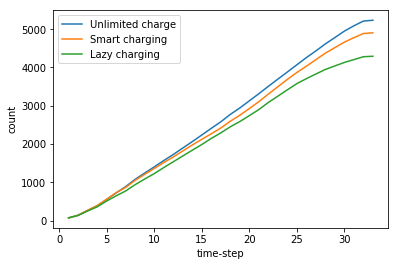

In [1310]:
for a in list(dic.keys()):
    plt.plot(dic[a]['data']['timestep'],dic[a]['data']['num_pickups_in_30_min'].cumsum(),label=a)

name='cumulative trips'
plt.xlabel('time-step')
plt.ylabel('count')
# plt.ylim(0,merged['Id'].max()+100)
plt.legend()
plt_finish(name)